# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE661 Fall 2022

## Setup

You shouldn't have to change anything in these cells

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training

Train a model and save the checkpoint. This cell is used in Lab-1 and Lab-3

In [81]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
#model_checkpoint = "netA_standard.pt"
#model_checkpoint = "netB_standard.pt"
model_checkpoint = "netA_advtrain_pgd0p1_eps20.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    
    eps = 0.20
    iters = 4
    alp = 1.85 * (eps/iters)
    
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        
        #data = attacks.rFGSM_attack(net, device, data, labels, 0.1)
        data = attacks.PGD_attack(net, device, data, labels, eps, alp, iters, rand_start = False)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.50578; TrainLoss: 1.23267; TestAcc: 0.76550; TestLoss: 0.64318
Epoch: [ 1 / 20 ]; TrainAcc: 0.63458; TrainLoss: 0.88413; TestAcc: 0.78160; TestLoss: 0.56156
Epoch: [ 2 / 20 ]; TrainAcc: 0.69265; TrainLoss: 0.74384; TestAcc: 0.79790; TestLoss: 0.53718
Epoch: [ 3 / 20 ]; TrainAcc: 0.71853; TrainLoss: 0.68445; TestAcc: 0.80750; TestLoss: 0.51879
Epoch: [ 4 / 20 ]; TrainAcc: 0.73582; TrainLoss: 0.64898; TestAcc: 0.81890; TestLoss: 0.49802
Epoch: [ 5 / 20 ]; TrainAcc: 0.74688; TrainLoss: 0.62491; TestAcc: 0.81970; TestLoss: 0.48452
Epoch: [ 6 / 20 ]; TrainAcc: 0.75440; TrainLoss: 0.60317; TestAcc: 0.82130; TestLoss: 0.47128
Epoch: [ 7 / 20 ]; TrainAcc: 0.76100; TrainLoss: 0.58807; TestAcc: 0.82030; TestLoss: 0.46249
Epoch: [ 8 / 20 ]; TrainAcc: 0.76367; TrainLoss: 0.57992; TestAcc: 0.81920; TestLoss: 0.46967
Epoch: [ 9 / 20 ]; TrainAcc: 0.77058; TrainLoss: 0.56995; TestAcc: 0.82380; TestLoss: 0.45927
Epoch: [ 10 / 20 ]; TrainAcc: 0.77543; TrainLoss: 0.56046; T

**Visualize some perturbed samples**

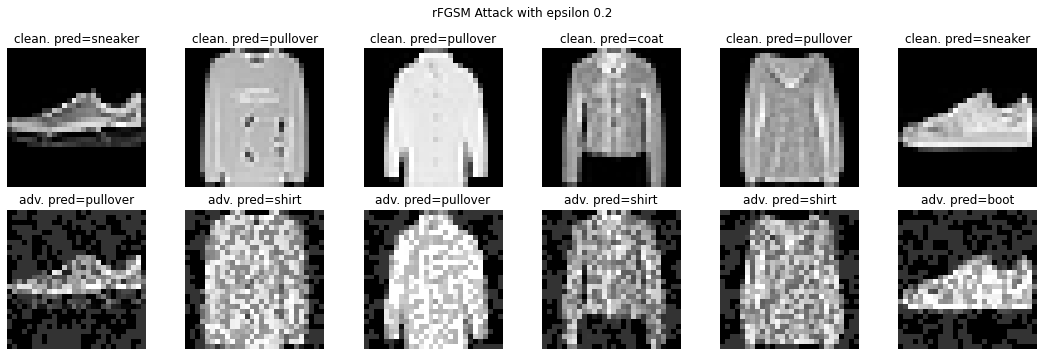

In [19]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        #EPS= ?
        #ITS=10
        #ALP = 1.85*(EPS/ITS)

        ###
        
        EPS= 0.2
        ITS= 10
        ALP = 1.85*(EPS/ITS)

        attack_name = 'rFGSM'
        #adv_data = attacks.PGD_attack(net, device, data, labels, EPS, ALP, ITS, rand_start = False)
        #adv_data = attacks.FGSM_attack(net, device, data, labels, EPS)
        adv_data = attacks.rFGSM_attack(net, device, data, labels, EPS)
        #adv_data = attacks.FGM_L2_attack(net, device, data, labels, EPS)
        
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
        plt.figure(figsize=(15,5))
        plt.suptitle(f'{attack_name} Attack with epsilon {EPS}')
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
        plt.tight_layout()
        plt.show()
        break

## Test Attacks - Whitebox & Blackbox

Don't forget to plot accuracy vs. epsilon curves!

In [21]:
epsilon_range = np.linspace(0,0.1,11)

In [29]:
rand_whitebox_accs = []
rand_blackbox_accs = []

fgsm_whitebox_accs = []
fgsm_blackbox_accs = []

rfgsm_whitebox_accs = []
rfgsm_blackbox_accs = []

fgsm_l2_whitebox_accs = []
fgsm_l2_blackbox_accs = []

pgd_whitebox_accs = []
pgd_blackbox_accs = []

Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


/home/jovyan/work/HW5/attacks.py:114: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_perturbed = x_nat.clone().detach() + eps * torch.Tensor(unit_grad).to(device)


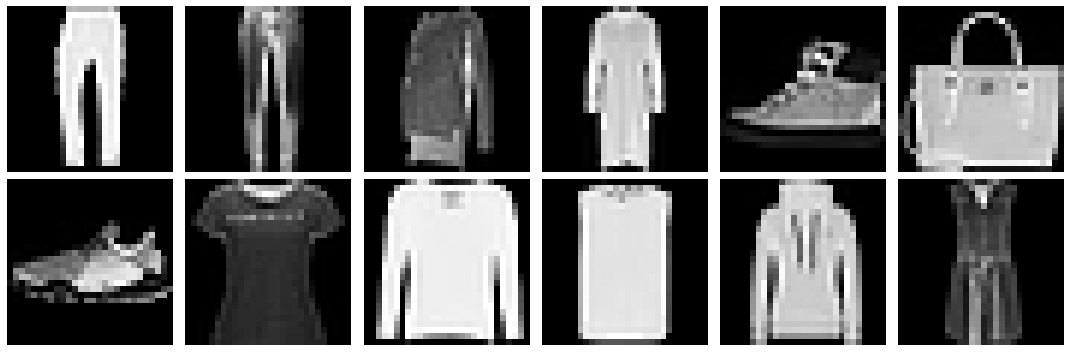

Attack Epsilon: 0.0; Whitebox Accuracy: 0.922; Blackbox Accuracy: 0.9242
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


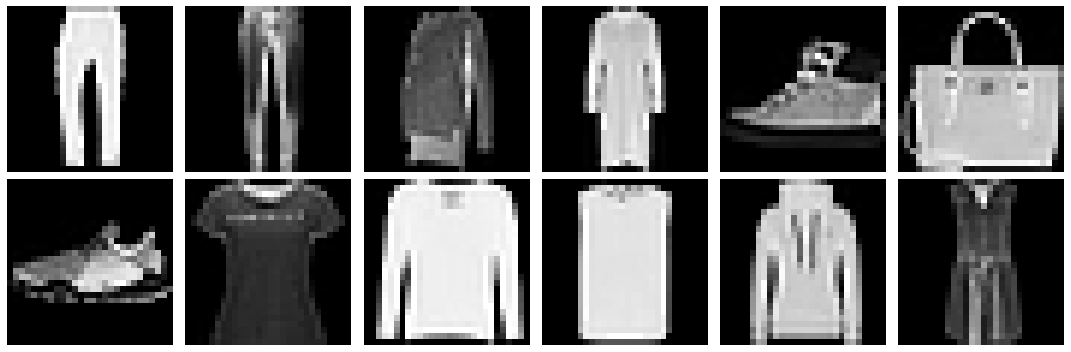

Attack Epsilon: 0.01; Whitebox Accuracy: 0.9122; Blackbox Accuracy: 0.9221
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


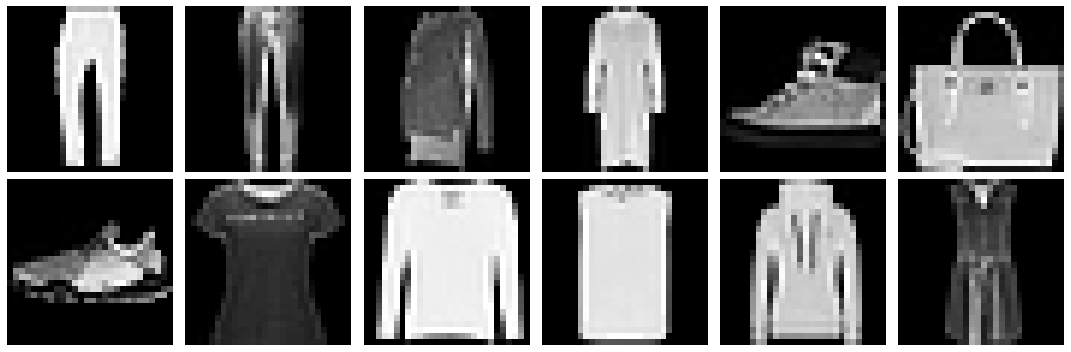

Attack Epsilon: 0.02; Whitebox Accuracy: 0.905; Blackbox Accuracy: 0.9209
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


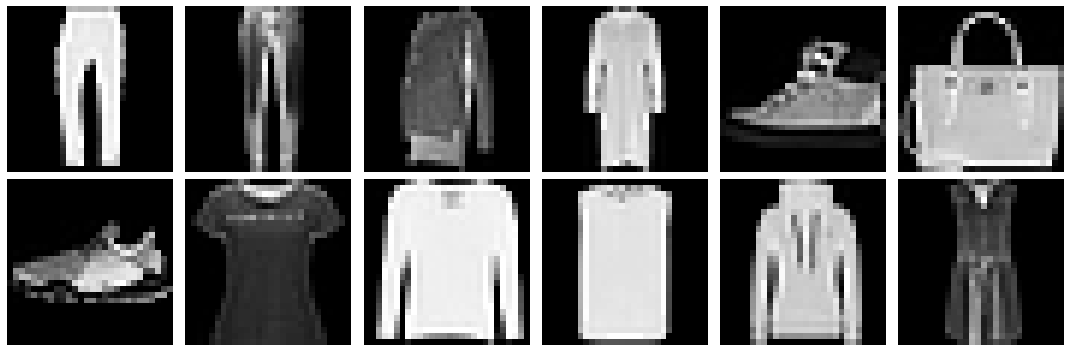

Attack Epsilon: 0.03; Whitebox Accuracy: 0.8963; Blackbox Accuracy: 0.9189
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


Attack Epsilon: 0.04; Whitebox Accuracy: 0.8846; Blackbox Accuracy: 0.9167
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


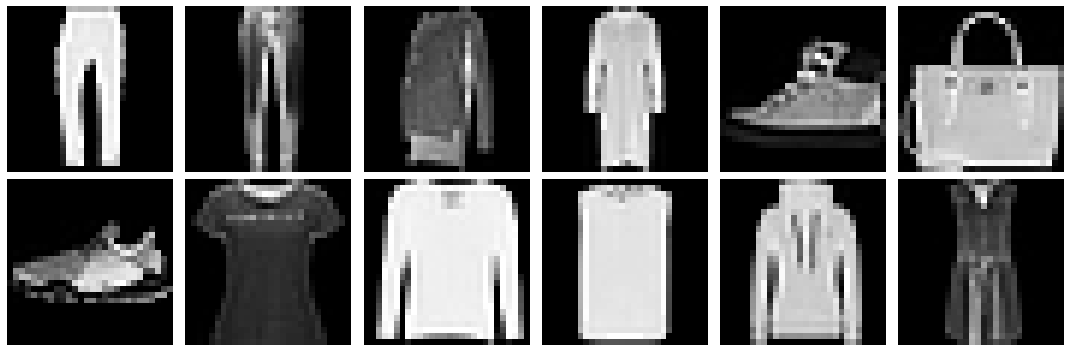

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8751; Blackbox Accuracy: 0.9147
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


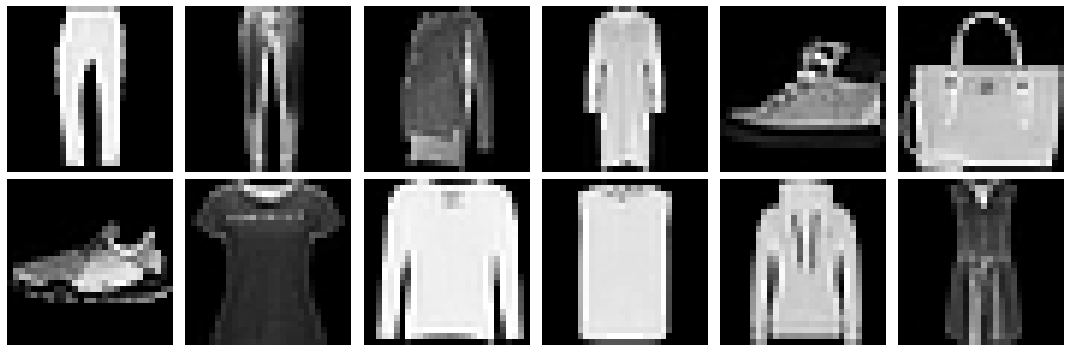

Attack Epsilon: 0.06; Whitebox Accuracy: 0.8651; Blackbox Accuracy: 0.9131
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


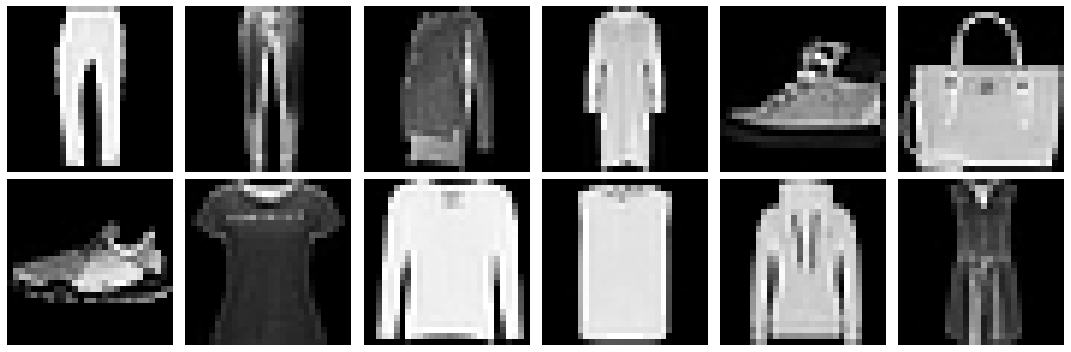

Attack Epsilon: 0.07; Whitebox Accuracy: 0.8565; Blackbox Accuracy: 0.9117
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


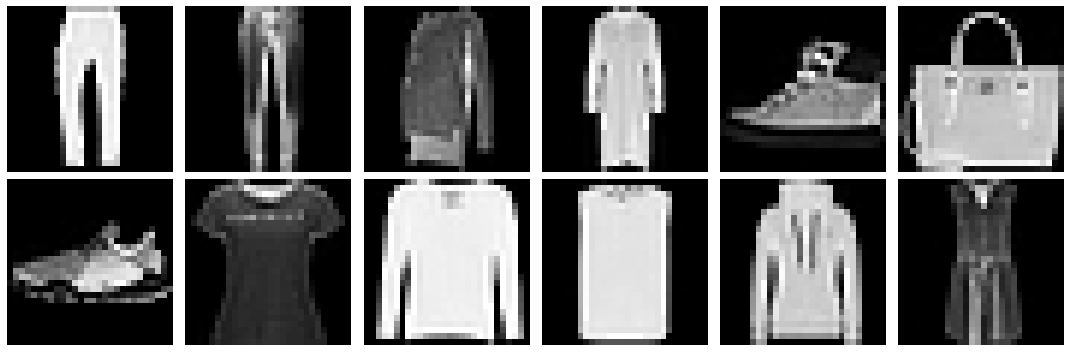

Attack Epsilon: 0.08; Whitebox Accuracy: 0.8465; Blackbox Accuracy: 0.9093
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


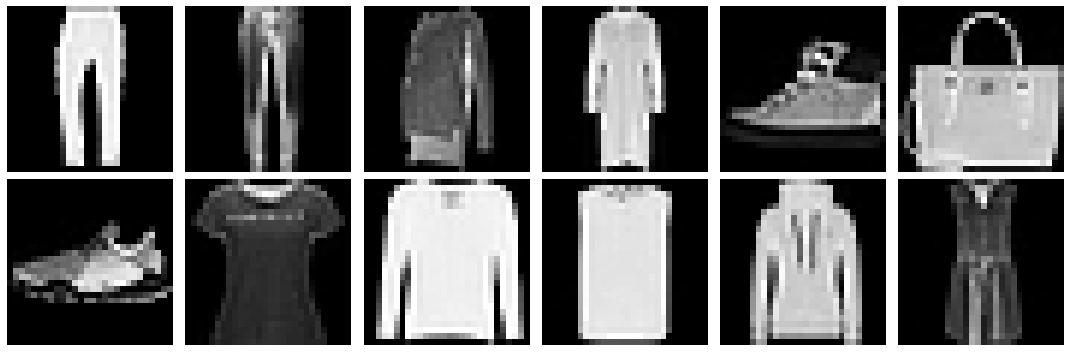

Attack Epsilon: 0.09; Whitebox Accuracy: 0.8379; Blackbox Accuracy: 0.9061
Done!
Initial Accuracy of Whitebox Model:  0.922
Initial Accuracy of Blackbox Model:  0.9242


Attack Epsilon: 0.1; Whitebox Accuracy: 0.8275; Blackbox Accuracy: 0.904
Done!


In [37]:
for eps in epsilon_range:
    ## Load pretrained models
    whitebox = models.NetA()
    blackbox = models.NetB()

    whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO
    blackbox.load_state_dict(torch.load("netB_standard.pt")) # TODO

    whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
    whitebox.eval(); blackbox.eval()

    test_acc,_ = test_model(whitebox,test_loader,device)
    print("Initial Accuracy of Whitebox Model: ",test_acc)
    test_acc,_ = test_model(blackbox,test_loader,device)
    print("Initial Accuracy of Blackbox Model: ",test_acc)

    ## Test the models against an adversarial attack

    # TODO: Set attack parameters here
    #ATK_EPS = ?
    #ATK_ITERS = ?
    #ATK_ALPHA = ?
    
    ATK_EPS = eps
    ATK_ITERS = 10
    ATK_ALPHA = 1.85*(EPS/ITS)

    whitebox_correct = 0.
    blackbox_correct = 0.
    running_total = 0.
    for batch_idx,(data,labels) in enumerate(test_loader):
        data = data.to(device) 
        labels = labels.to(device)

        # TODO: Perform adversarial attack here
        #adv_data = attacks.random_noise_attack(whitebox, device, data, ATK_EPS)
        #adv_data = attacks.PGD_attack(whitebox, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = False)
        #adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS)
        #adv_data = attacks.rFGSM_attack(whitebox, device, data, labels, ATK_EPS)
        adv_data = attacks.FGM_L2_attack(whitebox, device, data, labels, ATK_EPS)

        # Sanity checking if adversarial example is "legal"
        assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
        assert(adv_data.max() == 1.)
        assert(adv_data.min() == 0.)

        # Compute accuracy on perturbed data
        with torch.no_grad():
            # Stat keeping - whitebox
            whitebox_outputs = whitebox(adv_data)
            _,whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()
            # Stat keeping - blackbox
            blackbox_outputs = blackbox(adv_data)
            _,blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()
            running_total += labels.size(0)

        # Plot some samples
        if batch_idx == 1:
            plt.figure(figsize=(15,5))
            for jj in range(12):
                plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
            plt.tight_layout()
            plt.show()

    # Print final 
    whitebox_acc = whitebox_correct/running_total
    blackbox_acc = blackbox_correct/running_total
    
    fgsm_l2_whitebox_accs.append(whitebox_acc)
    fgsm_l2_blackbox_accs.append(blackbox_acc)

    print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

    print("Done!")

In [31]:
def plot_epsilon_performance(epsilons, performance, attack_name):
  plt.title(f'{attack_name} Performance for Various Epsilon Values')
  plt.xlabel('Epsilon Values')
  plt.ylabel('Model Accuracy')
  plt.ylim(0,1)
  plt.scatter(epsilons, performance)

In [32]:
plot_epsilon_performance(epsilon_range, rand_whitebox_accs, attack_name = 'Random Attack Whitebox')

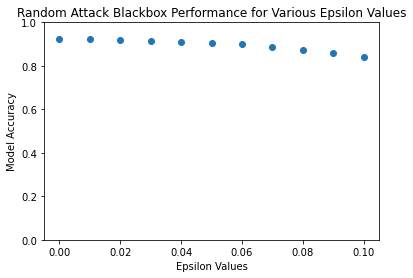

In [33]:
plot_epsilon_performance(epsilon_range, rand_blackbox_accs, attack_name = 'Random Attack Blackbox')

In [38]:
import matplotlib.pyplot as plt

In [42]:
def plot_epsilon_performance_comparison(epsilons, rands, fgsms, rfgsms, fgm_l2s, pgds, attack_type):
    plt.title(f'{attack_type} Accuracy for Different Attacks and Epsilon Values')
    plt.xlabel('Epsilon Values')
    plt.ylabel('Model Accuracy')
    plt.ylim(0,1)
    plt.scatter(epsilons, rands, label = 'Random')
    plt.scatter(epsilons, fgsms, label = 'FGSM')
    plt.scatter(epsilons, rfgsms, label = 'rFGSM')
    plt.scatter(epsilons, pgds, label = 'PGD')
    plt.legend()

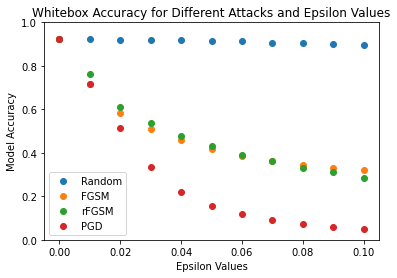

In [43]:
plot_epsilon_performance_comparison(epsilon_range, rand_whitebox_accs, fgsm_whitebox_accs, rfgsm_whitebox_accs, fgsm_l2_whitebox_accs, pgd_whitebox_accs, attack_type = 'Whitebox')

In [157]:
pgd_blackbox_accs[5]

0.5597

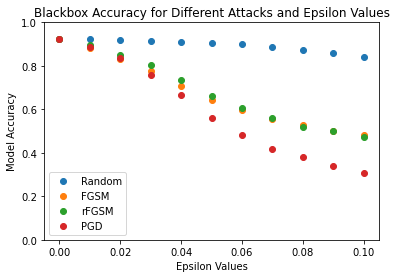

In [44]:
plot_epsilon_performance_comparison(epsilon_range, rand_blackbox_accs, fgsm_blackbox_accs, rfgsm_blackbox_accs, fgsm_l2_blackbox_accs, pgd_blackbox_accs, attack_type = 'Blackbox')

## Test Robust Models

Don't forget to plot accuracy vs. epsilon curves!

In [55]:
new_epsilon_range = np.linspace(0,0.14,8)

In [56]:
new_epsilon_range

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14])

In [104]:
def get_robust_accuracies(epsilon_range, model_name, attack_type):
    
    whitebox_accs = []
    
    for eps in epsilon_range:

        whitebox = models.NetA()
        whitebox.load_state_dict(torch.load(model_name)) # TODO: Load your robust models
        whitebox = whitebox.to(device)
        whitebox.eval(); 

        test_acc,_ = test_model(whitebox,test_loader,device)
        print("Initial Accuracy of Whitebox Model: ",test_acc)

        ## Test the model against an adversarial attack

        # TODO: Set attack parameters here
        ATK_EPS = eps
        ATK_ITERS = 10
        ATK_ALPHA = 1.85*(EPS/ITS)

        whitebox_correct = 0.
        running_total = 0.
        for batch_idx,(data,labels) in enumerate(test_loader):
            data = data.to(device) 
            labels = labels.to(device)

            # TODO: Perform adversarial attack here
            if attack_type == 'PGD':
                adv_data = attacks.PGD_attack(whitebox, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = False)
            elif attack_type == 'FGSM':
                adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS)
            elif attack_type == 'rFGSM':
                adv_data = attacks.rFGSM_attack(whitebox, device, data, labels, ATK_EPS)
            else:
                raise Exception()
            
            #adv_data = attacks.random_noise_attack(whitebox, device, data, ATK_EPS)
            #adv_data = attacks.PGD_attack(whitebox, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = False)
            #adv_data = attacks.FGSM_attack(whitebox, device, data, labels, ATK_EPS)
            #adv_data = attacks.rFGSM_attack(whitebox, device, data, labels, ATK_EPS)
            #adv_data = attacks.FGM_L2_attack(whitebox, device, data, labels, ATK_EPS)

            # Sanity checking if adversarial example is "legal"
            assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
            assert(adv_data.max() == 1.)
            assert(adv_data.min() == 0.)

            # Compute accuracy on perturbed data
            with torch.no_grad():
                whitebox_outputs = whitebox(adv_data)
                _,whitebox_preds = whitebox_outputs.max(1)
                whitebox_correct += whitebox_preds.eq(labels).sum().item()
                running_total += labels.size(0)

            # Plot some samples
            if batch_idx == 1:
                plt.figure(figsize=(15,5))
                for jj in range(12):
                    plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
                plt.tight_layout()
                plt.show()

        # Print final 
        whitebox_acc = whitebox_correct/running_total
        print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

        print("Done!")
        
        whitebox_accs.append(whitebox_acc)
    
    return whitebox_accs
        

In [61]:
fgsm_model_name = 'netA_advtrain_fgsm0p1.pt'

Initial Accuracy of Whitebox Model:  0.7237


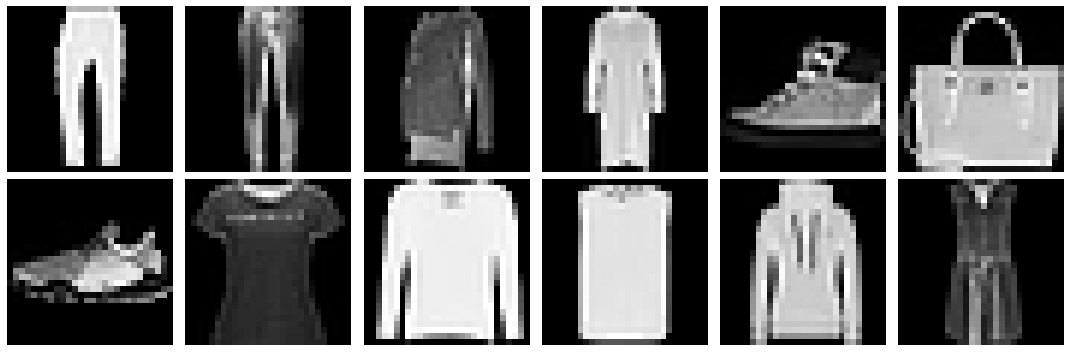

Attack Epsilon: 0.0; Whitebox Accuracy: 0.7237
Done!
Initial Accuracy of Whitebox Model:  0.7237


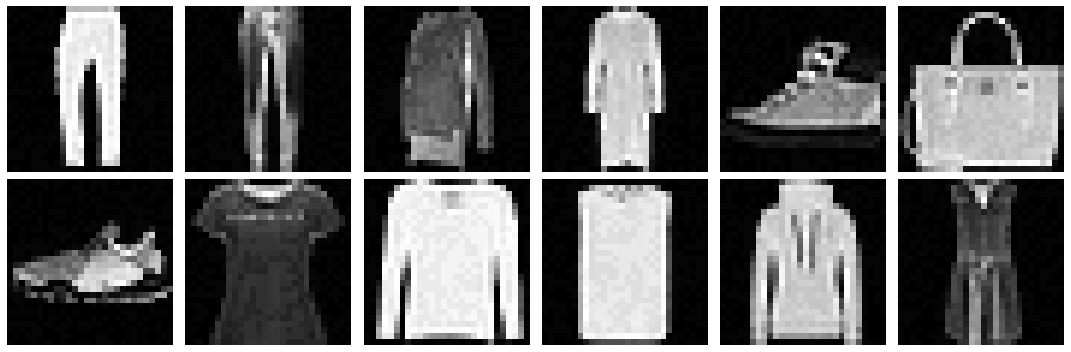

Attack Epsilon: 0.02; Whitebox Accuracy: 0.7868
Done!
Initial Accuracy of Whitebox Model:  0.7237


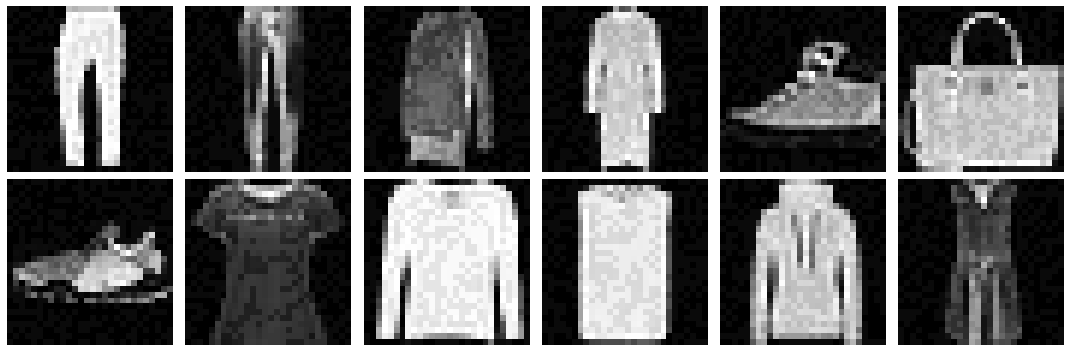

Attack Epsilon: 0.04; Whitebox Accuracy: 0.868
Done!
Initial Accuracy of Whitebox Model:  0.7237


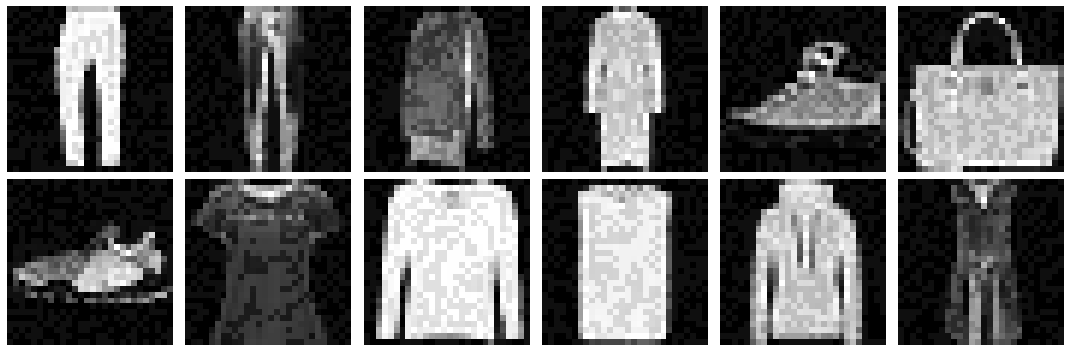

Attack Epsilon: 0.06; Whitebox Accuracy: 0.9457
Done!
Initial Accuracy of Whitebox Model:  0.7237


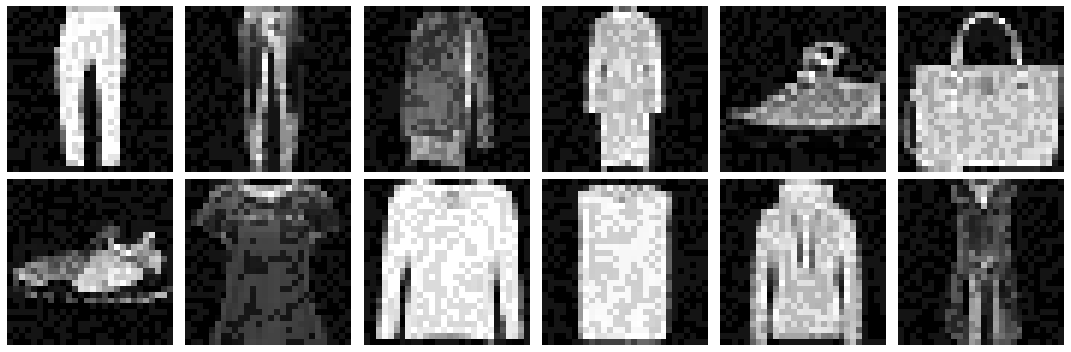

Attack Epsilon: 0.08; Whitebox Accuracy: 0.9651
Done!
Initial Accuracy of Whitebox Model:  0.7237


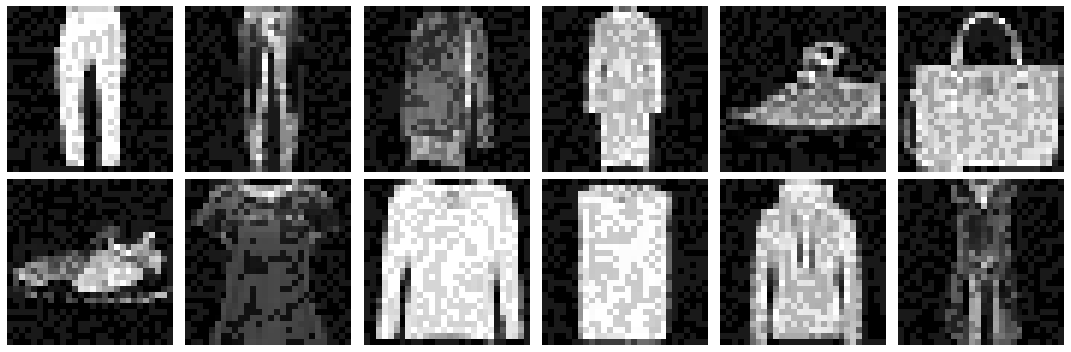

Attack Epsilon: 0.1; Whitebox Accuracy: 0.9675
Done!
Initial Accuracy of Whitebox Model:  0.7237


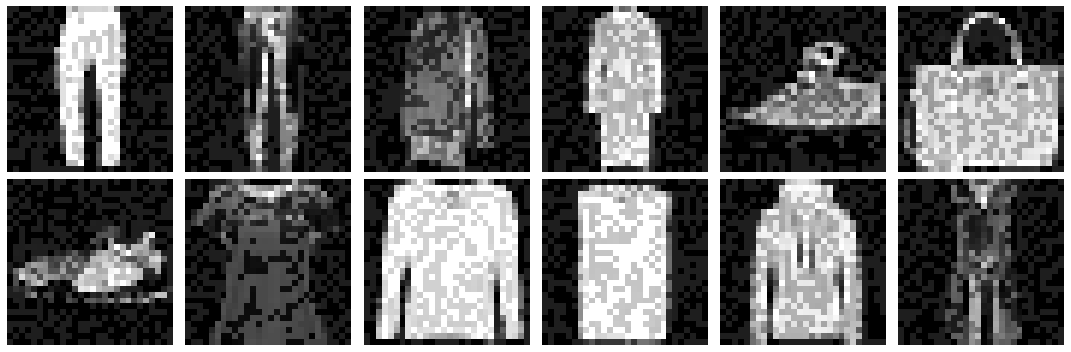

Attack Epsilon: 0.12; Whitebox Accuracy: 0.9578
Done!
Initial Accuracy of Whitebox Model:  0.7237


Attack Epsilon: 0.14; Whitebox Accuracy: 0.913
Done!


In [62]:
fgsm_trained_fgsm_whitebox_accs = get_robust_accuracies(new_epsilon_range, fgsm_model_name, attack_type = 'FGSM')

Initial Accuracy of Whitebox Model:  0.7237


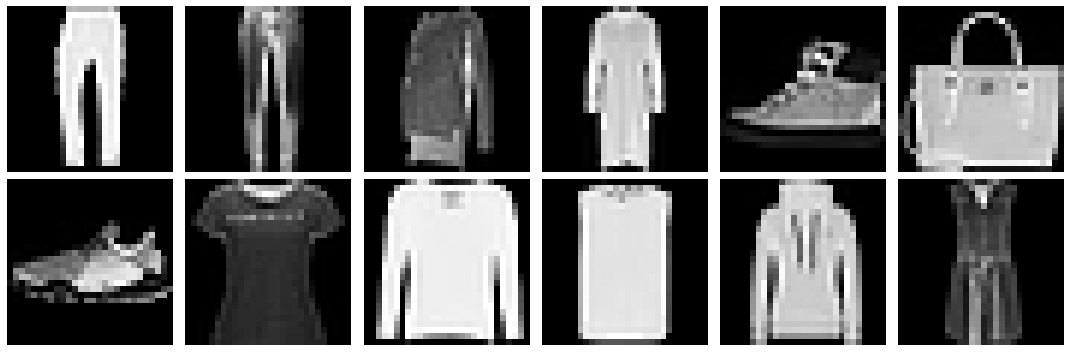

Attack Epsilon: 0.0; Whitebox Accuracy: 0.7237
Done!
Initial Accuracy of Whitebox Model:  0.7237


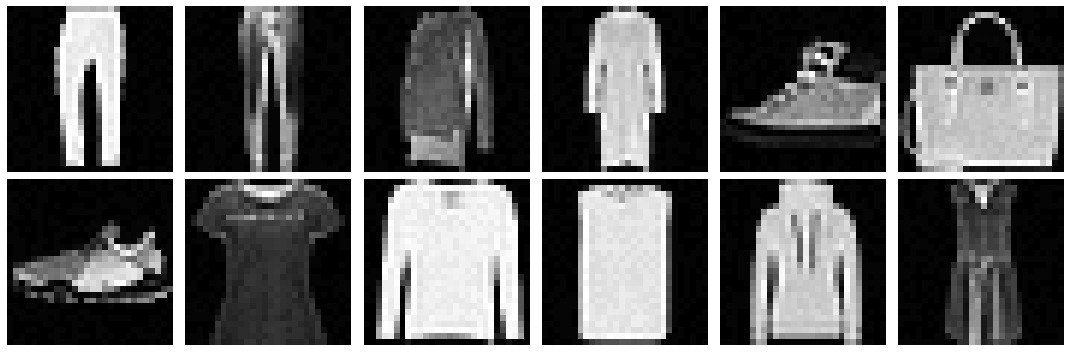

Attack Epsilon: 0.02; Whitebox Accuracy: 0.4982
Done!
Initial Accuracy of Whitebox Model:  0.7237


Attack Epsilon: 0.04; Whitebox Accuracy: 0.3303
Done!
Initial Accuracy of Whitebox Model:  0.7237


Attack Epsilon: 0.06; Whitebox Accuracy: 0.2485
Done!
Initial Accuracy of Whitebox Model:  0.7237


Attack Epsilon: 0.08; Whitebox Accuracy: 0.2085
Done!
Initial Accuracy of Whitebox Model:  0.7237


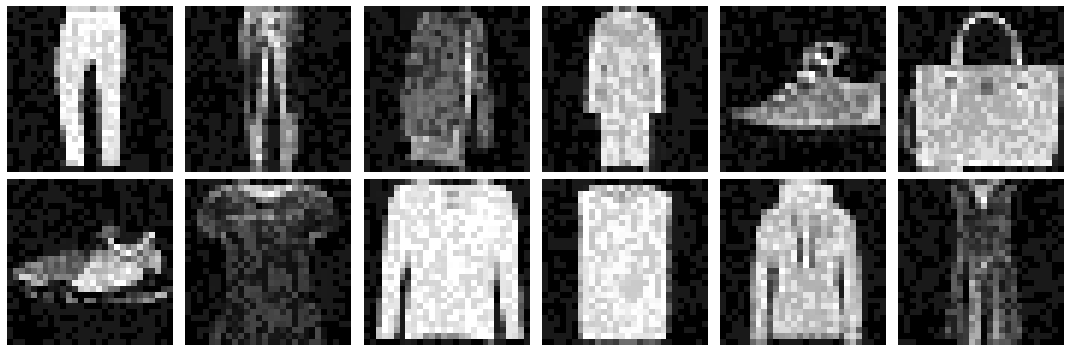

Attack Epsilon: 0.1; Whitebox Accuracy: 0.1945
Done!
Initial Accuracy of Whitebox Model:  0.7237


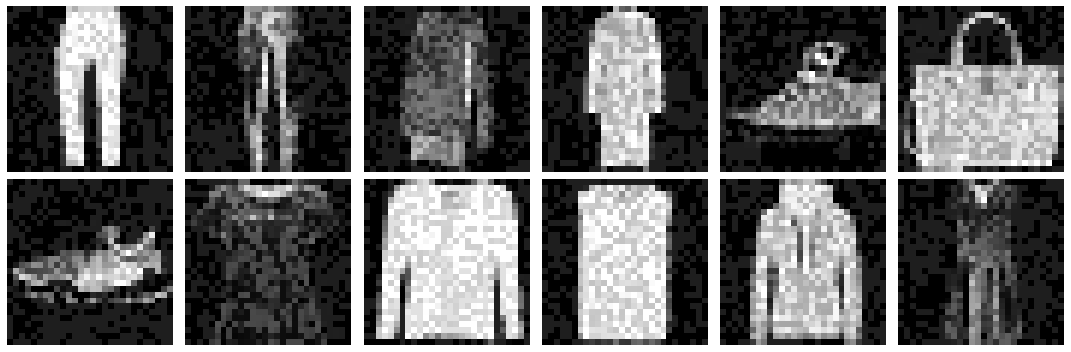

Attack Epsilon: 0.12; Whitebox Accuracy: 0.2176
Done!
Initial Accuracy of Whitebox Model:  0.7237


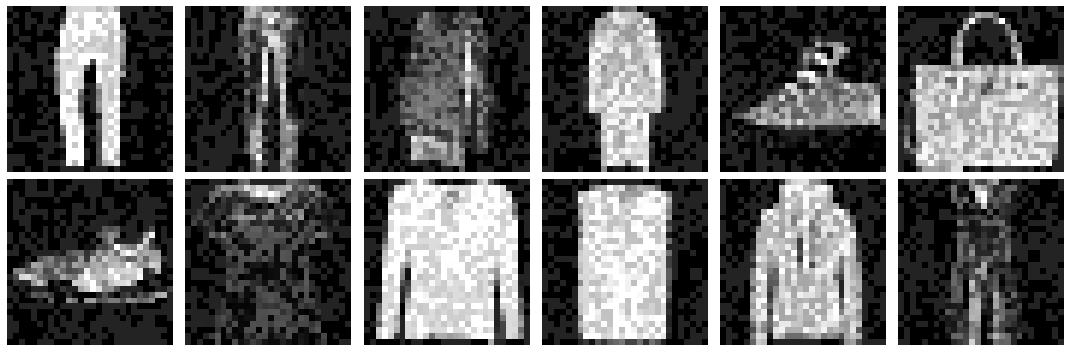

Attack Epsilon: 0.14; Whitebox Accuracy: 0.2637
Done!


In [63]:
fgsm_trained_rfgsm_whitebox_accs = get_robust_accuracies(new_epsilon_range, fgsm_model_name, attack_type = 'rFGSM')

Initial Accuracy of Whitebox Model:  0.7237


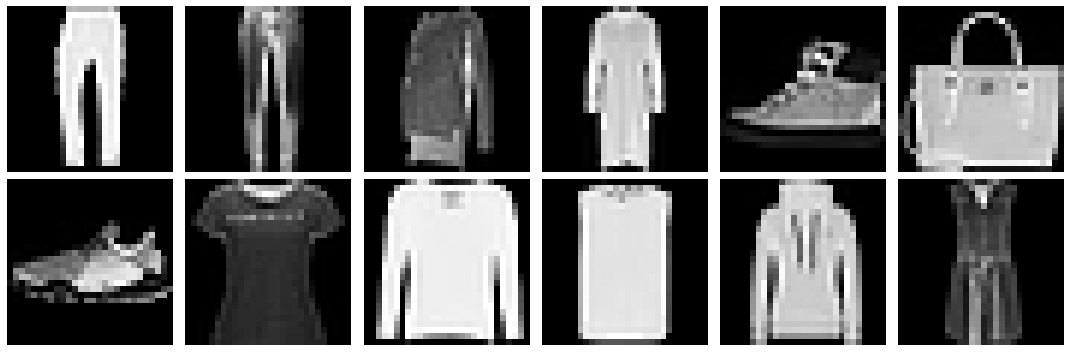

Attack Epsilon: 0.0; Whitebox Accuracy: 0.7237
Done!
Initial Accuracy of Whitebox Model:  0.7237


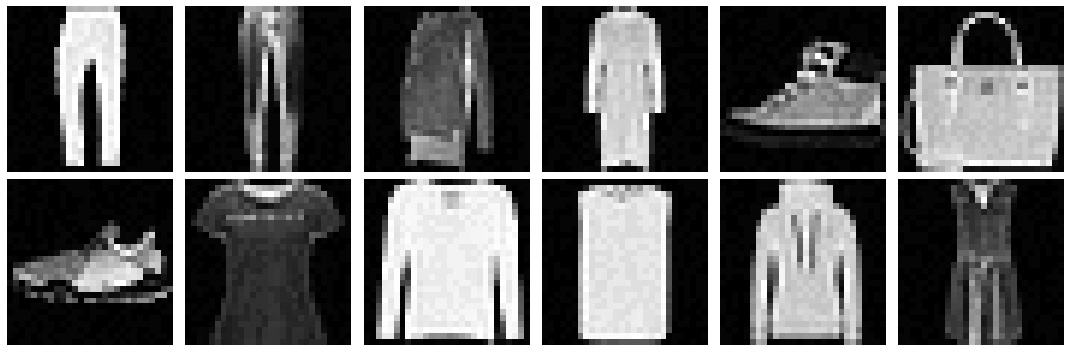

Attack Epsilon: 0.02; Whitebox Accuracy: 0.4015
Done!
Initial Accuracy of Whitebox Model:  0.7237


Attack Epsilon: 0.04; Whitebox Accuracy: 0.2134
Done!
Initial Accuracy of Whitebox Model:  0.7237


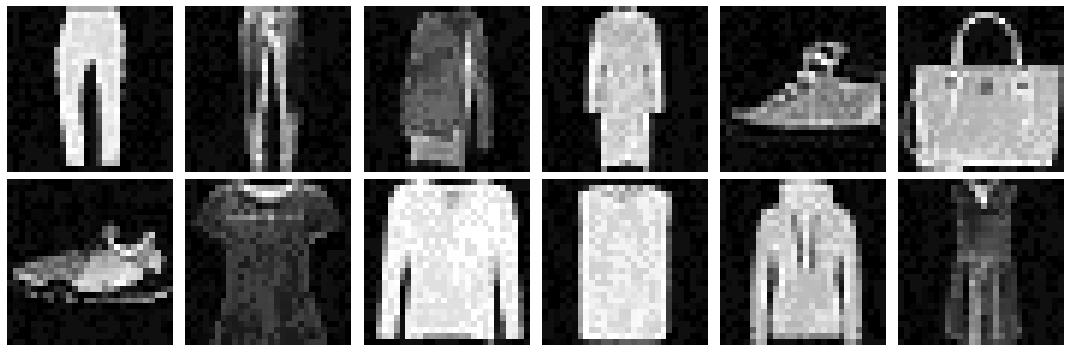

Attack Epsilon: 0.06; Whitebox Accuracy: 0.1101
Done!
Initial Accuracy of Whitebox Model:  0.7237


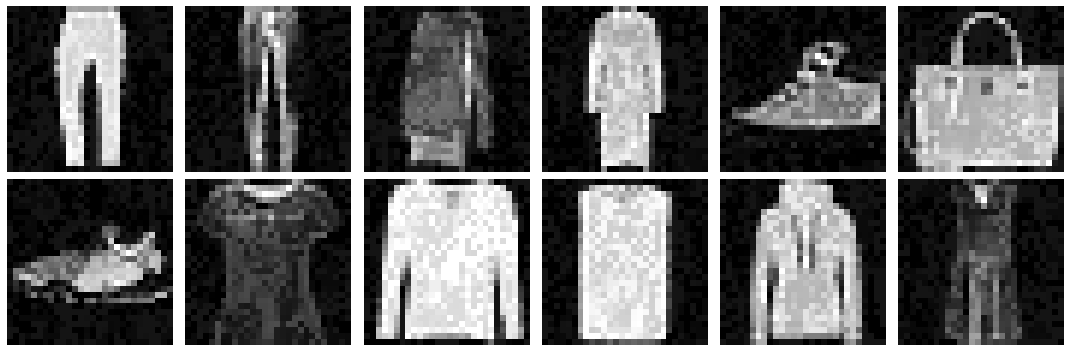

Attack Epsilon: 0.08; Whitebox Accuracy: 0.0547
Done!
Initial Accuracy of Whitebox Model:  0.7237


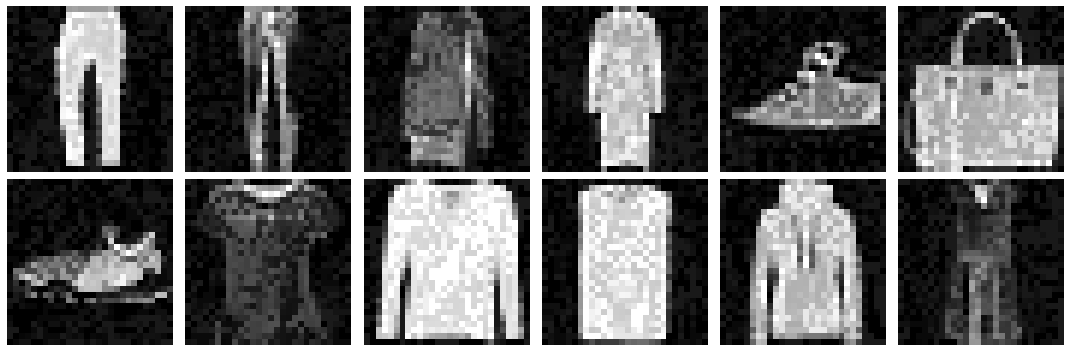

Attack Epsilon: 0.1; Whitebox Accuracy: 0.0341
Done!
Initial Accuracy of Whitebox Model:  0.7237


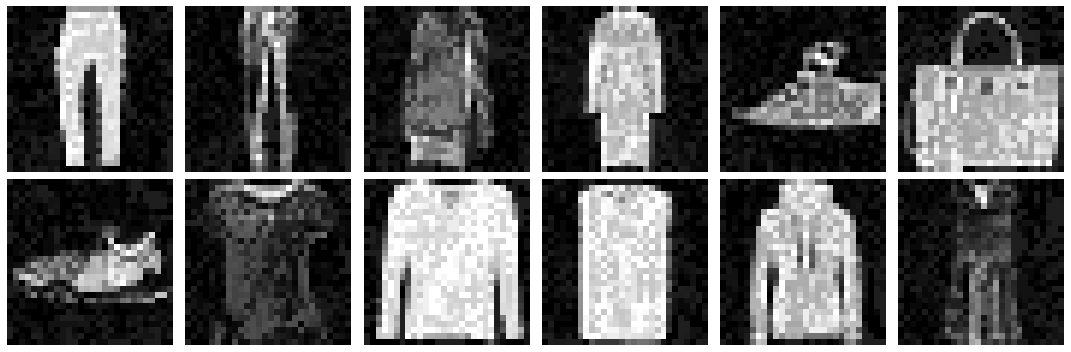

Attack Epsilon: 0.12; Whitebox Accuracy: 0.0236
Done!
Initial Accuracy of Whitebox Model:  0.7237


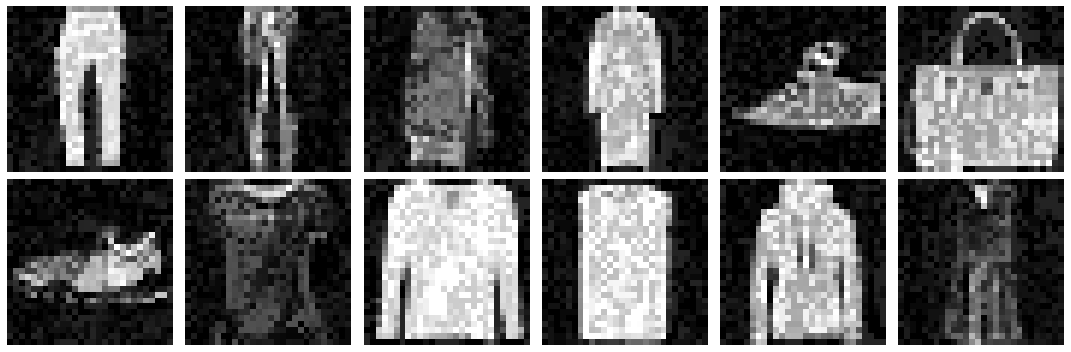

Attack Epsilon: 0.14; Whitebox Accuracy: 0.0174
Done!


In [64]:
fgsm_trained_pgd_whitebox_accs = get_robust_accuracies(new_epsilon_range, fgsm_model_name, attack_type = 'PGD')

In [66]:
def plot_AT_epsilon_performance_comparison(epsilons, fgsms, rfgsms, pgds, train_type):
    plt.title(f'Whitebox Accuracy on {train_type} Adversarially Trained for Different Attacks and Epsilon Values')
    plt.xlabel('Epsilon Values')
    plt.ylabel('Model Accuracy')
    plt.ylim(0,1)
    plt.scatter(epsilons, fgsms, label = 'FGSM')
    plt.scatter(epsilons, rfgsms, label = 'rFGSM')
    plt.scatter(epsilons, pgds, label = 'PGD')
    plt.legend()

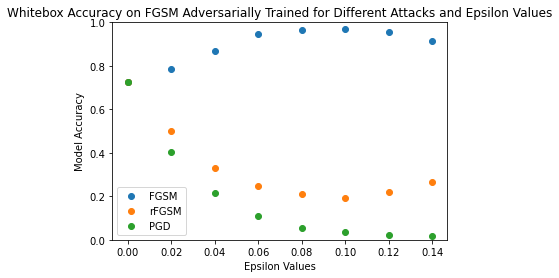

In [67]:
plot_AT_epsilon_performance_comparison(new_epsilon_range, fgsm_trained_fgsm_whitebox_accs, fgsm_trained_rfgsm_whitebox_accs, fgsm_trained_pgd_whitebox_accs, train_type = 'FGSM')

In [68]:
rfgsm_model_name = 'netA_advtrain_rfgsm0p1.pt'

Initial Accuracy of Whitebox Model:  0.8868


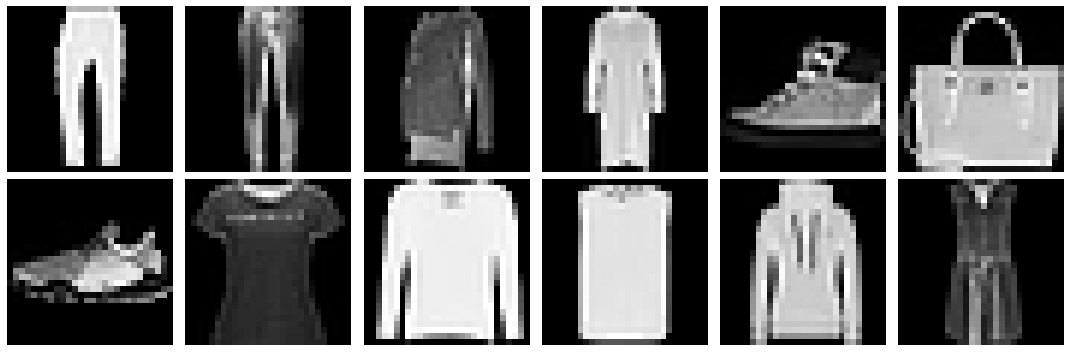

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8868
Done!
Initial Accuracy of Whitebox Model:  0.8868


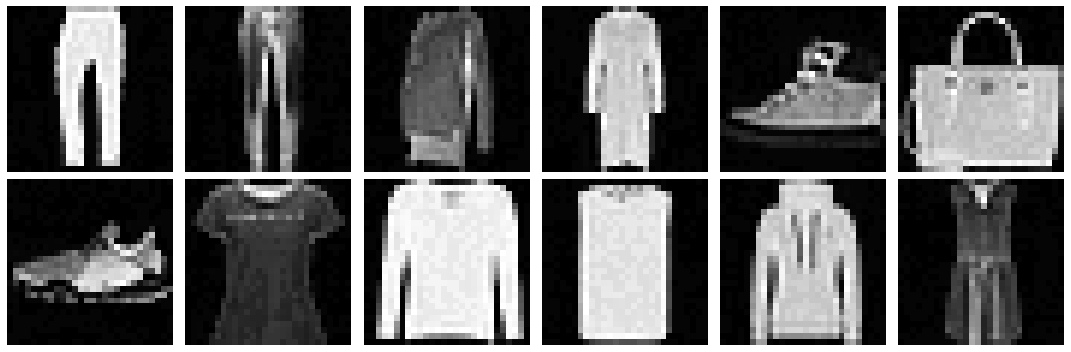

Attack Epsilon: 0.02; Whitebox Accuracy: 0.8642
Done!
Initial Accuracy of Whitebox Model:  0.8868


Attack Epsilon: 0.04; Whitebox Accuracy: 0.8461
Done!
Initial Accuracy of Whitebox Model:  0.8868


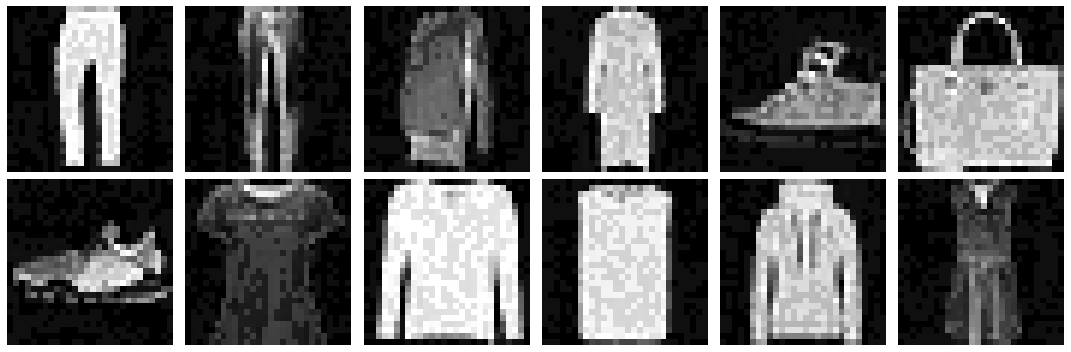

Attack Epsilon: 0.06; Whitebox Accuracy: 0.8313
Done!
Initial Accuracy of Whitebox Model:  0.8868


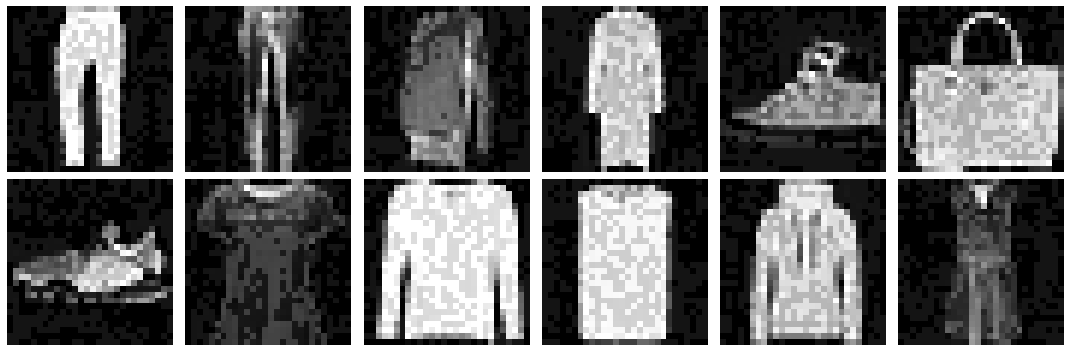

Attack Epsilon: 0.08; Whitebox Accuracy: 0.8188
Done!
Initial Accuracy of Whitebox Model:  0.8868


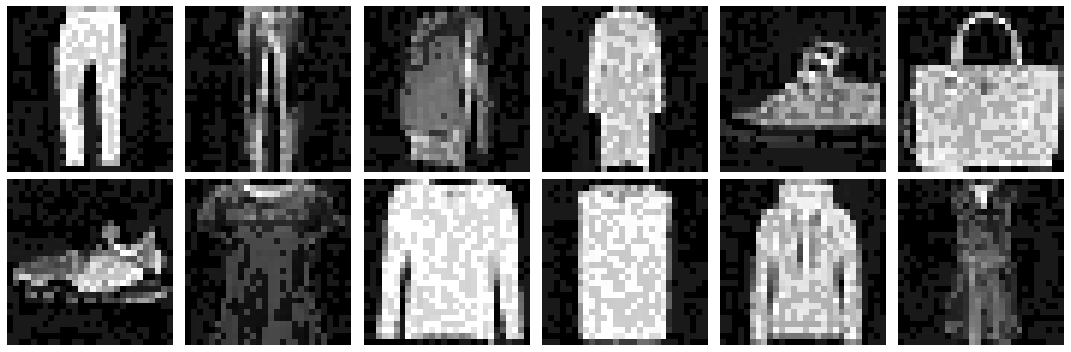

Attack Epsilon: 0.1; Whitebox Accuracy: 0.8061
Done!
Initial Accuracy of Whitebox Model:  0.8868


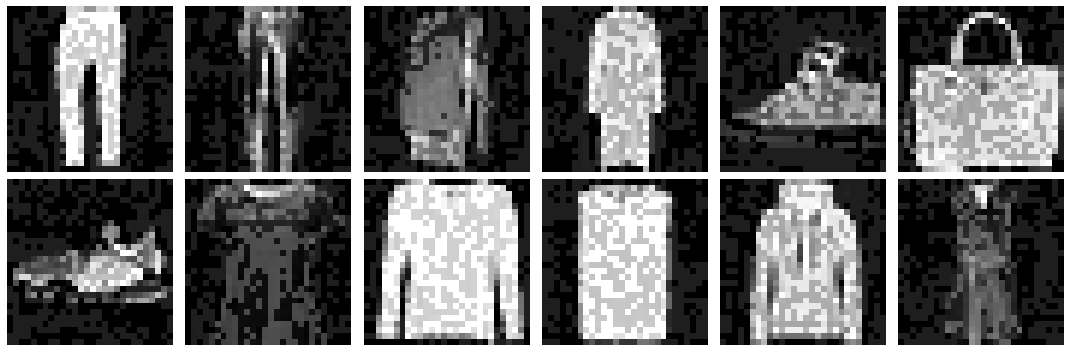

Attack Epsilon: 0.12; Whitebox Accuracy: 0.7877
Done!
Initial Accuracy of Whitebox Model:  0.8868


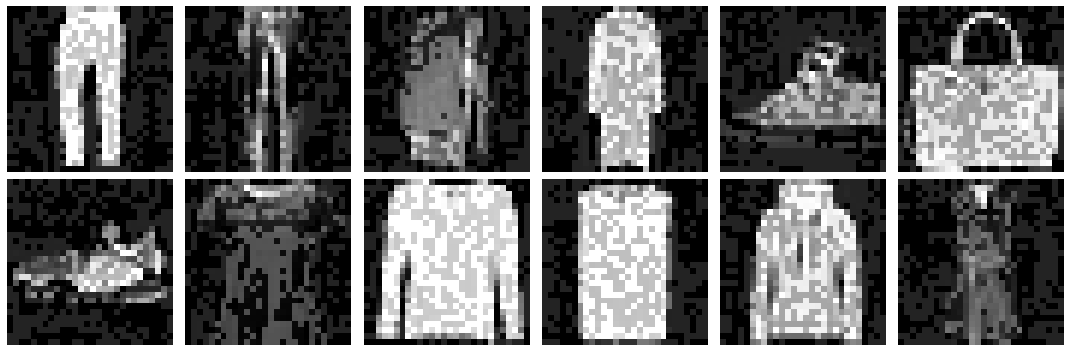

Attack Epsilon: 0.14; Whitebox Accuracy: 0.6598
Done!


In [69]:
rfgsm_trained_fgsm_whitebox_accs = get_robust_accuracies(new_epsilon_range, rfgsm_model_name, attack_type = 'FGSM')

Initial Accuracy of Whitebox Model:  0.8868


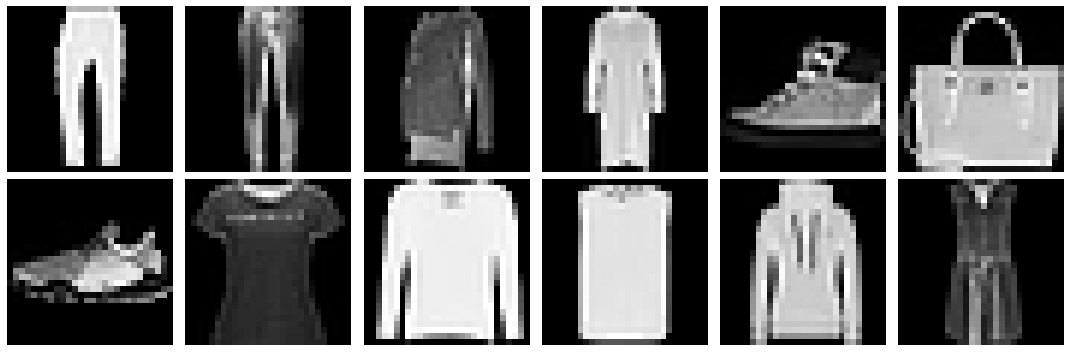

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8868
Done!
Initial Accuracy of Whitebox Model:  0.8868


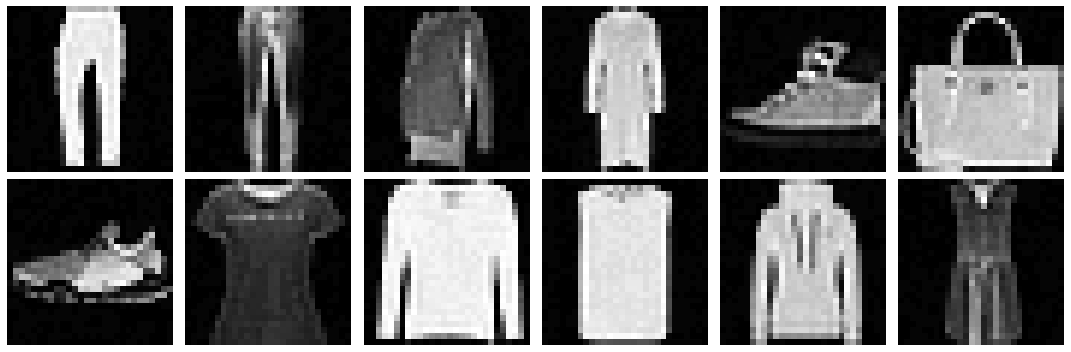

Attack Epsilon: 0.02; Whitebox Accuracy: 0.8695
Done!
Initial Accuracy of Whitebox Model:  0.8868


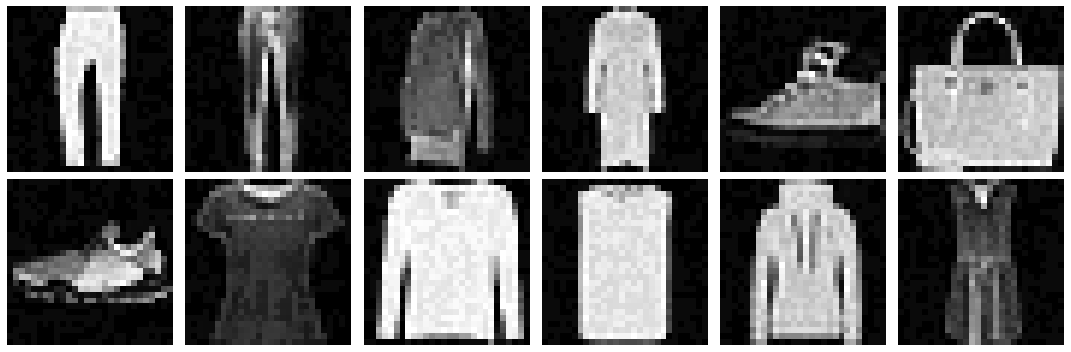

Attack Epsilon: 0.04; Whitebox Accuracy: 0.8547
Done!
Initial Accuracy of Whitebox Model:  0.8868


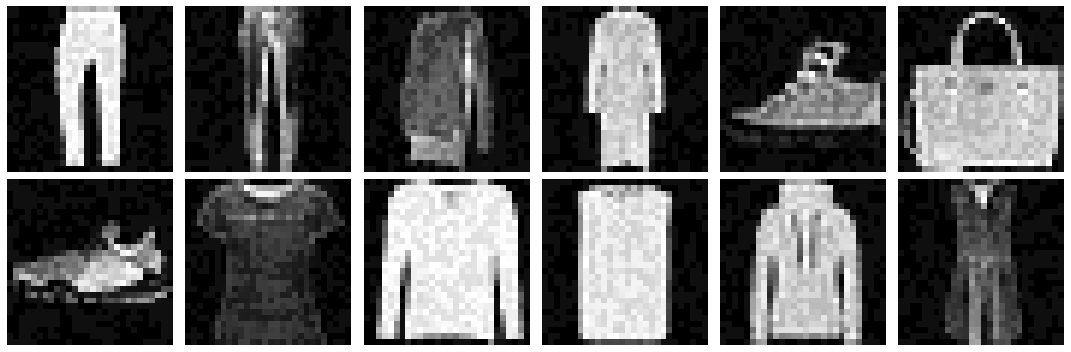

Attack Epsilon: 0.06; Whitebox Accuracy: 0.8424
Done!
Initial Accuracy of Whitebox Model:  0.8868


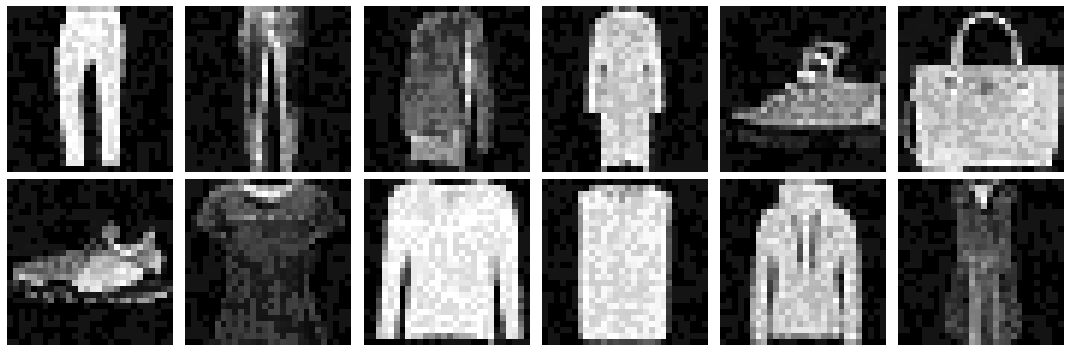

Attack Epsilon: 0.08; Whitebox Accuracy: 0.8321
Done!
Initial Accuracy of Whitebox Model:  0.8868


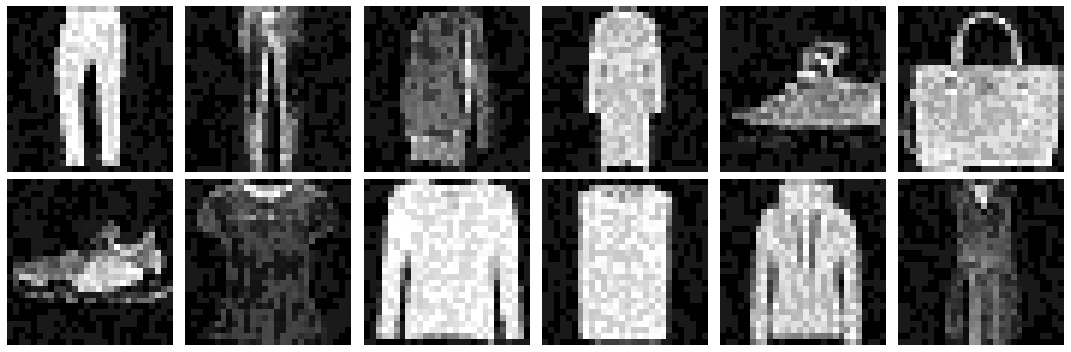

Attack Epsilon: 0.1; Whitebox Accuracy: 0.8202
Done!
Initial Accuracy of Whitebox Model:  0.8868


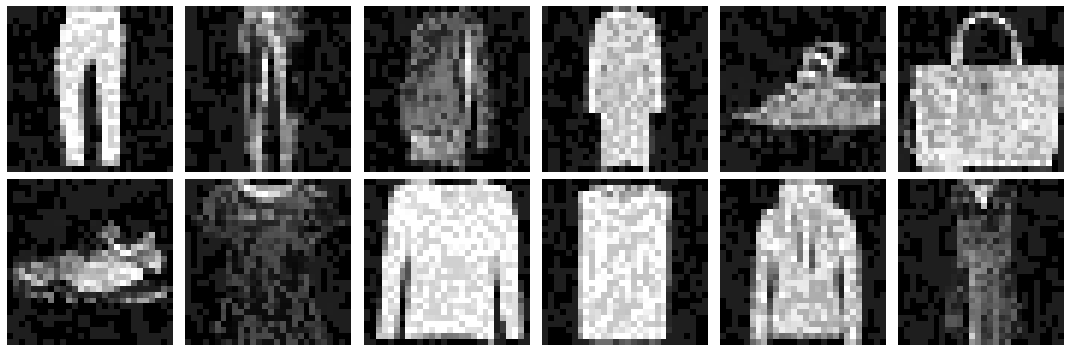

Attack Epsilon: 0.12; Whitebox Accuracy: 0.7607
Done!
Initial Accuracy of Whitebox Model:  0.8868


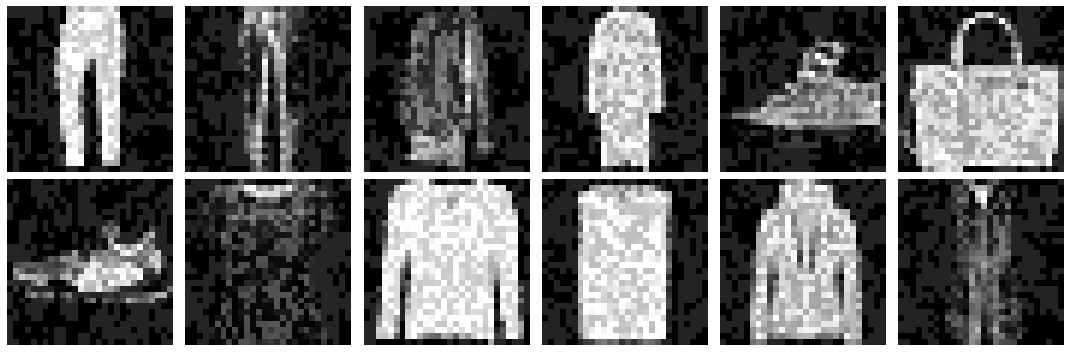

Attack Epsilon: 0.14; Whitebox Accuracy: 0.5742
Done!


In [70]:
rfgsm_trained_rfgsm_whitebox_accs = get_robust_accuracies(new_epsilon_range, rfgsm_model_name, attack_type = 'rFGSM')

Initial Accuracy of Whitebox Model:  0.8868


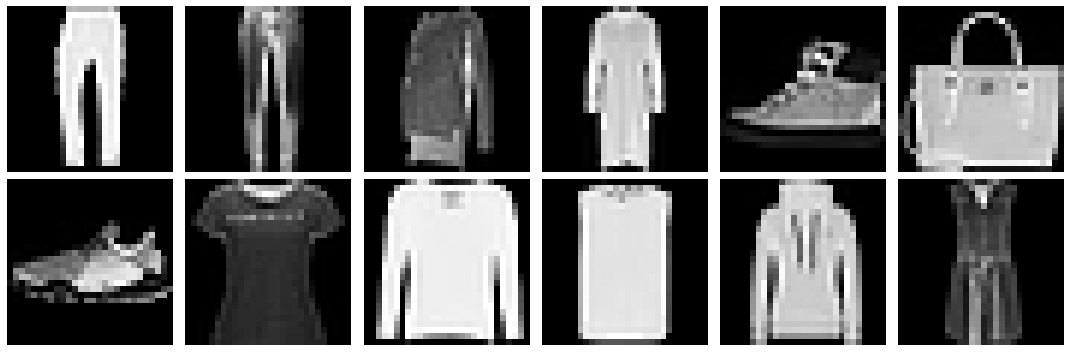

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8868
Done!
Initial Accuracy of Whitebox Model:  0.8868


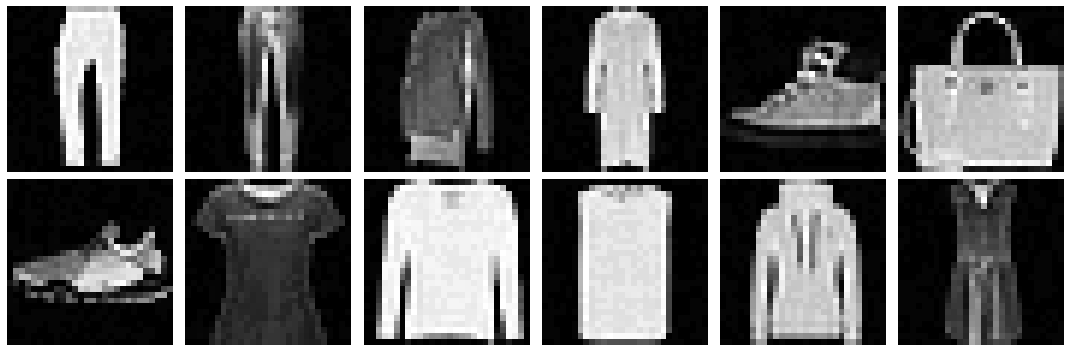

Attack Epsilon: 0.02; Whitebox Accuracy: 0.8641
Done!
Initial Accuracy of Whitebox Model:  0.8868


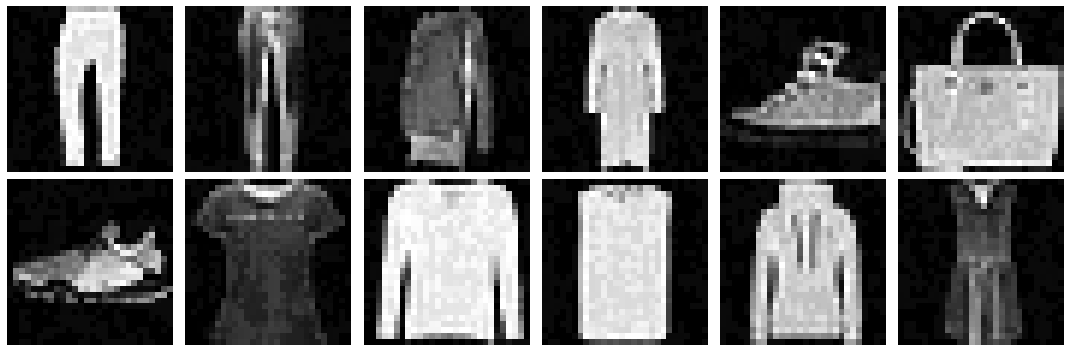

Attack Epsilon: 0.04; Whitebox Accuracy: 0.8392
Done!
Initial Accuracy of Whitebox Model:  0.8868


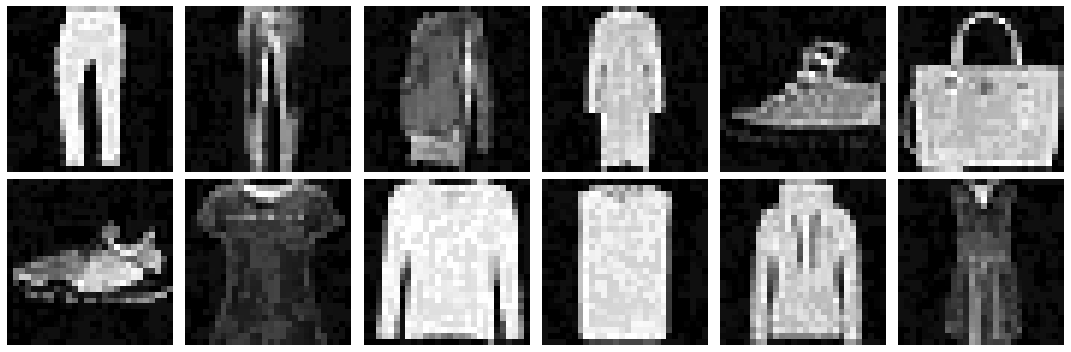

Attack Epsilon: 0.06; Whitebox Accuracy: 0.8129
Done!
Initial Accuracy of Whitebox Model:  0.8868


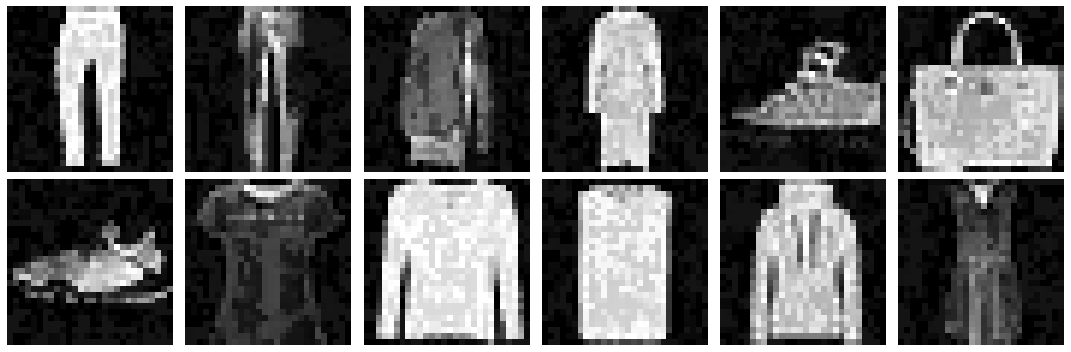

Attack Epsilon: 0.08; Whitebox Accuracy: 0.7836
Done!
Initial Accuracy of Whitebox Model:  0.8868


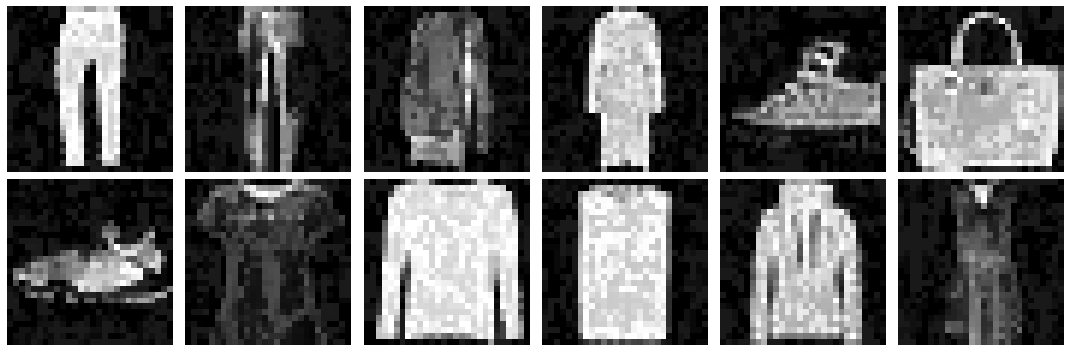

Attack Epsilon: 0.1; Whitebox Accuracy: 0.7431
Done!
Initial Accuracy of Whitebox Model:  0.8868


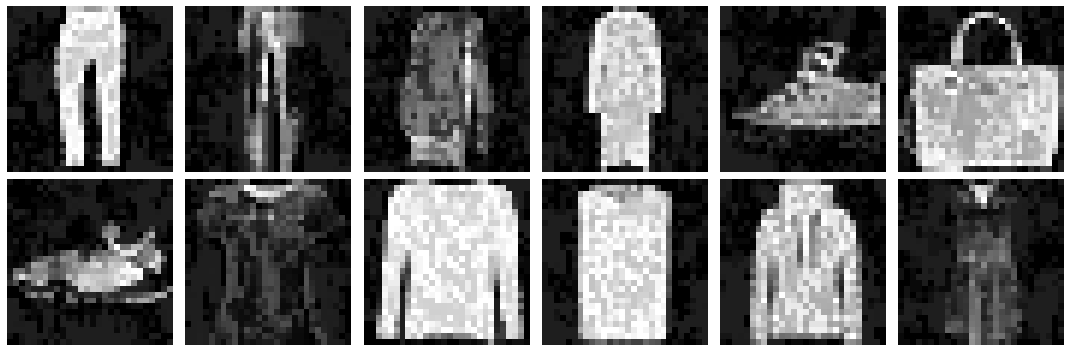

Attack Epsilon: 0.12; Whitebox Accuracy: 0.4728
Done!
Initial Accuracy of Whitebox Model:  0.8868


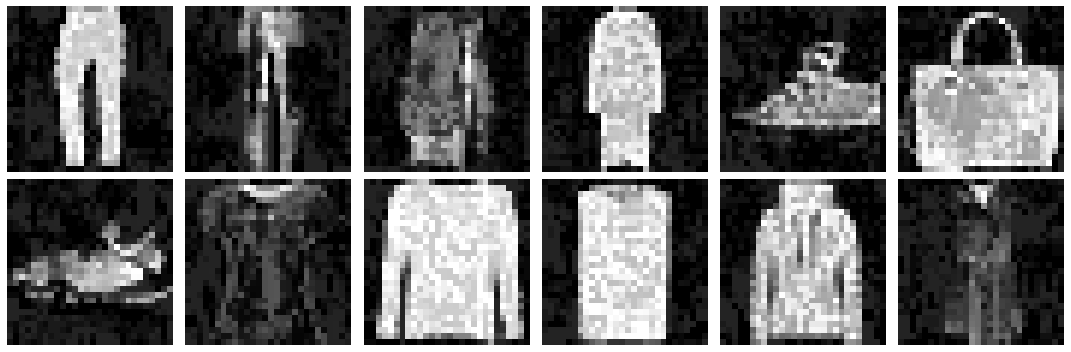

Attack Epsilon: 0.14; Whitebox Accuracy: 0.2354
Done!


In [71]:
rfgsm_trained_pgd_whitebox_accs = get_robust_accuracies(new_epsilon_range, rfgsm_model_name, attack_type = 'PGD')

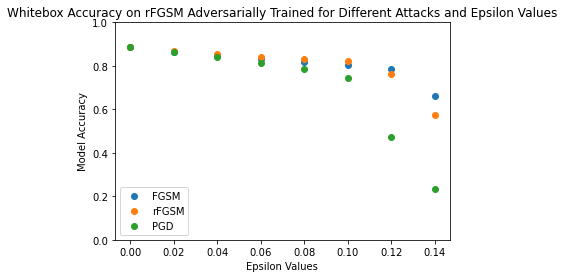

In [72]:
plot_AT_epsilon_performance_comparison(new_epsilon_range, rfgsm_trained_fgsm_whitebox_accs, rfgsm_trained_rfgsm_whitebox_accs, rfgsm_trained_pgd_whitebox_accs, train_type = 'rFGSM')

In [73]:
pgd_model_name = 'netA_advtrain_pgd0p1.pt'

Initial Accuracy of Whitebox Model:  0.8719


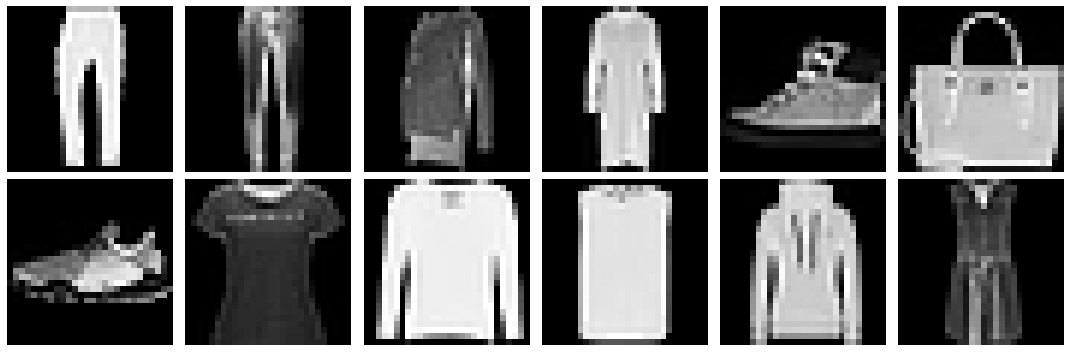

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8719
Done!
Initial Accuracy of Whitebox Model:  0.8719


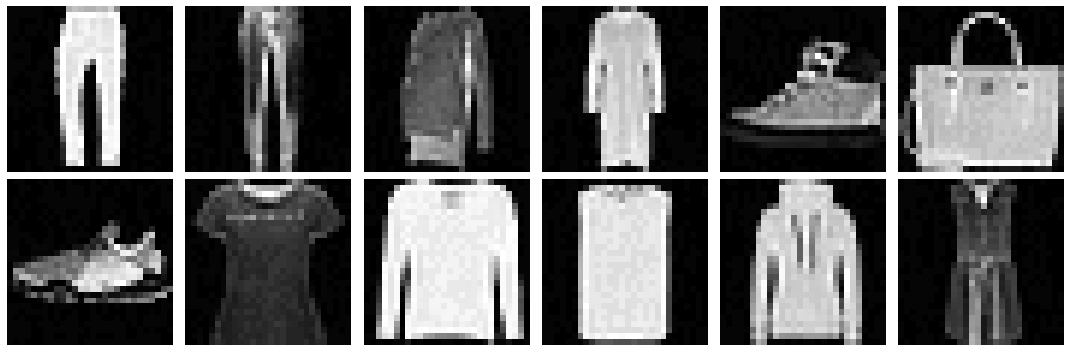

Attack Epsilon: 0.02; Whitebox Accuracy: 0.8548
Done!
Initial Accuracy of Whitebox Model:  0.8719


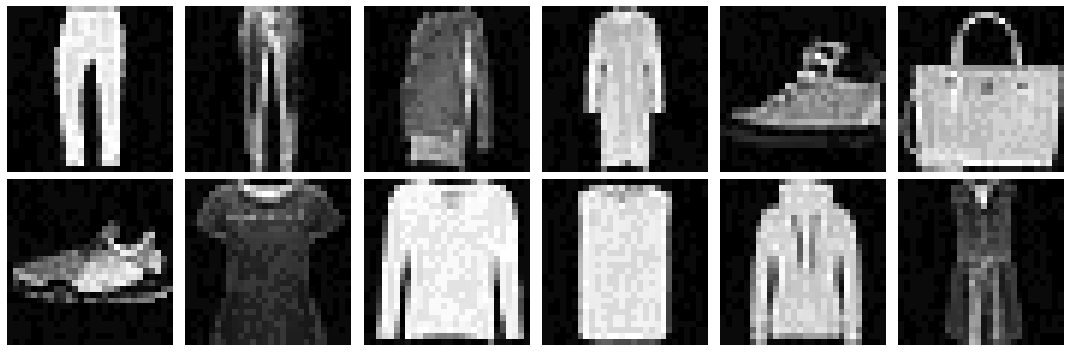

Attack Epsilon: 0.04; Whitebox Accuracy: 0.8424
Done!
Initial Accuracy of Whitebox Model:  0.8719


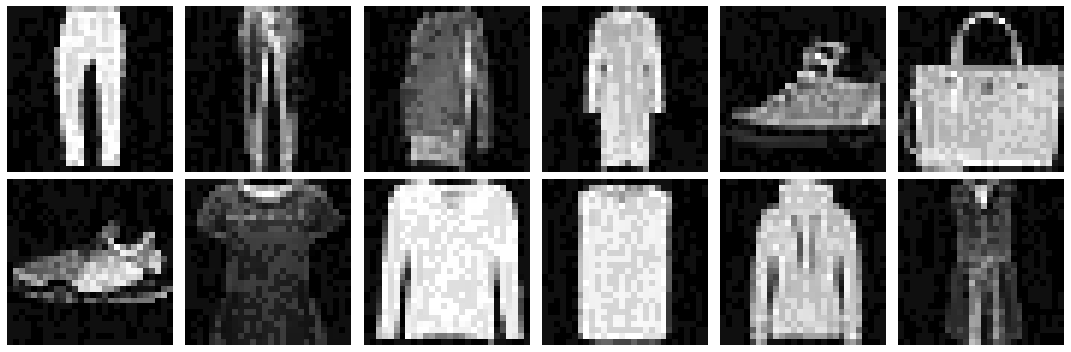

Attack Epsilon: 0.06; Whitebox Accuracy: 0.8312
Done!
Initial Accuracy of Whitebox Model:  0.8719


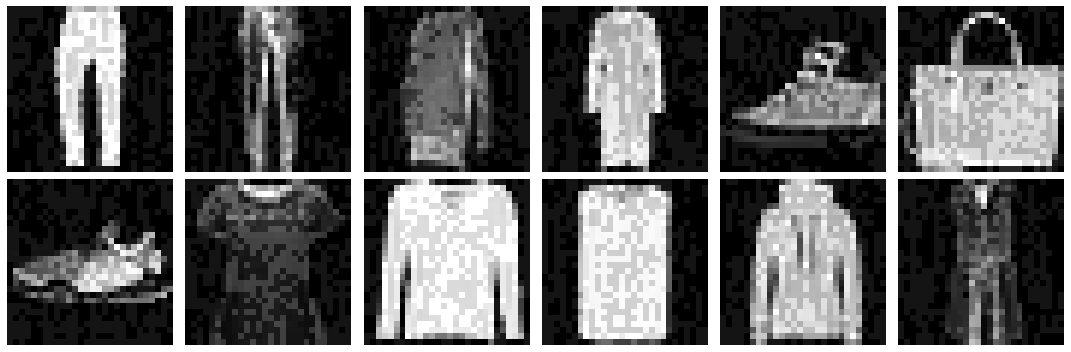

Attack Epsilon: 0.08; Whitebox Accuracy: 0.8227
Done!
Initial Accuracy of Whitebox Model:  0.8719


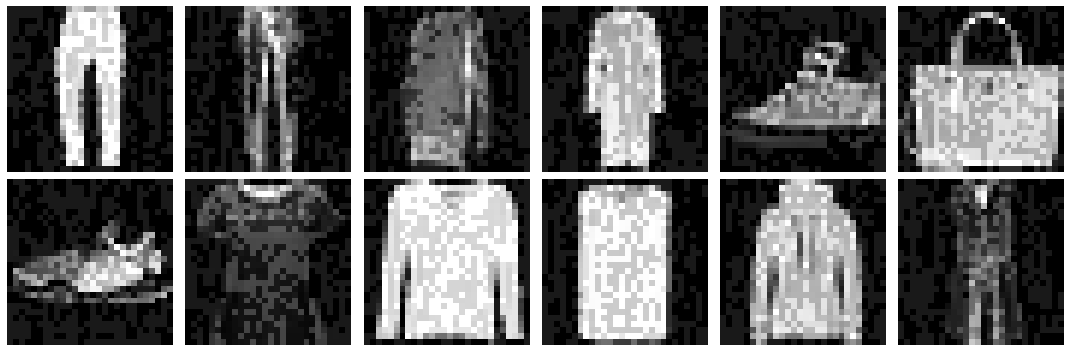

Attack Epsilon: 0.1; Whitebox Accuracy: 0.8126
Done!
Initial Accuracy of Whitebox Model:  0.8719


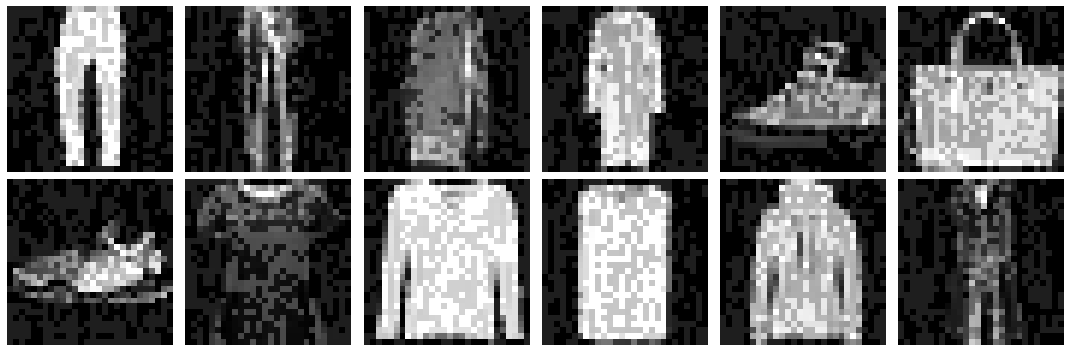

Attack Epsilon: 0.12; Whitebox Accuracy: 0.731
Done!
Initial Accuracy of Whitebox Model:  0.8719


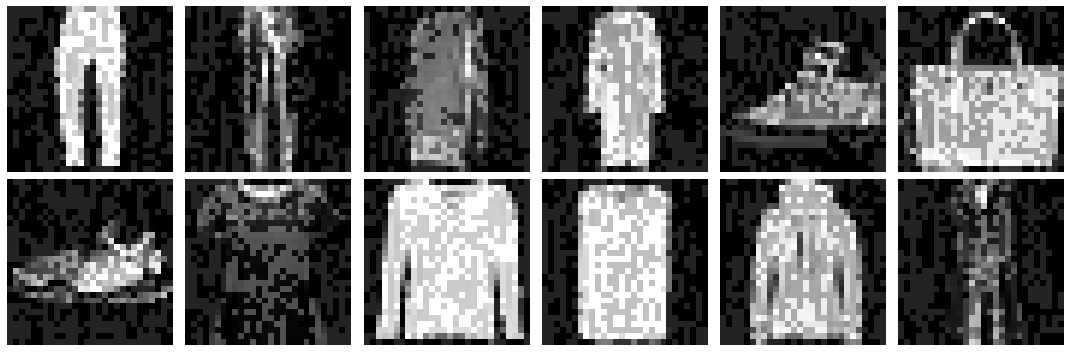

Attack Epsilon: 0.14; Whitebox Accuracy: 0.5082
Done!


In [74]:
pgd_trained_fgsm_whitebox_accs = get_robust_accuracies(new_epsilon_range, pgd_model_name, attack_type = 'FGSM')

Initial Accuracy of Whitebox Model:  0.8719


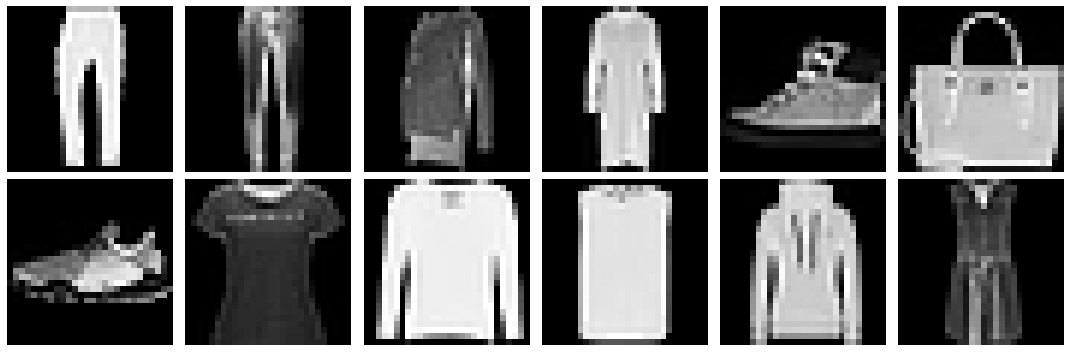

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8719
Done!
Initial Accuracy of Whitebox Model:  0.8719


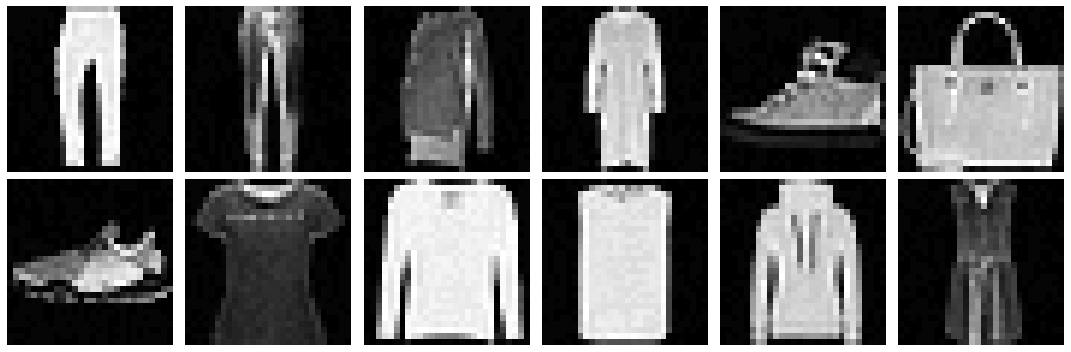

Attack Epsilon: 0.02; Whitebox Accuracy: 0.8591
Done!
Initial Accuracy of Whitebox Model:  0.8719


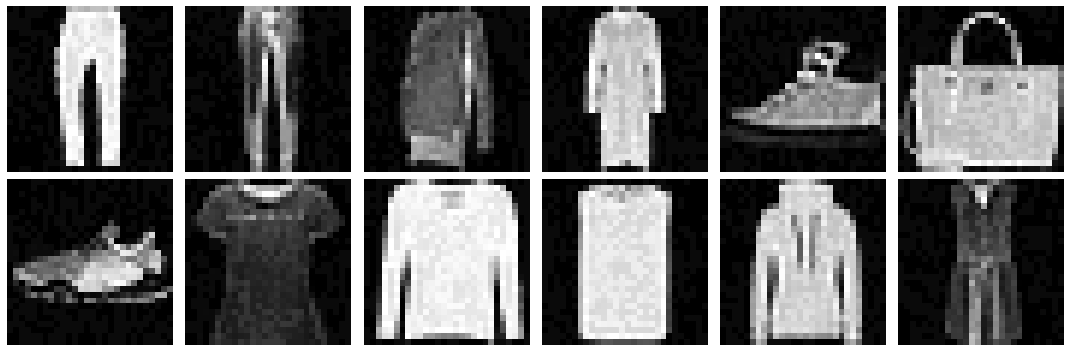

Attack Epsilon: 0.04; Whitebox Accuracy: 0.8481
Done!
Initial Accuracy of Whitebox Model:  0.8719


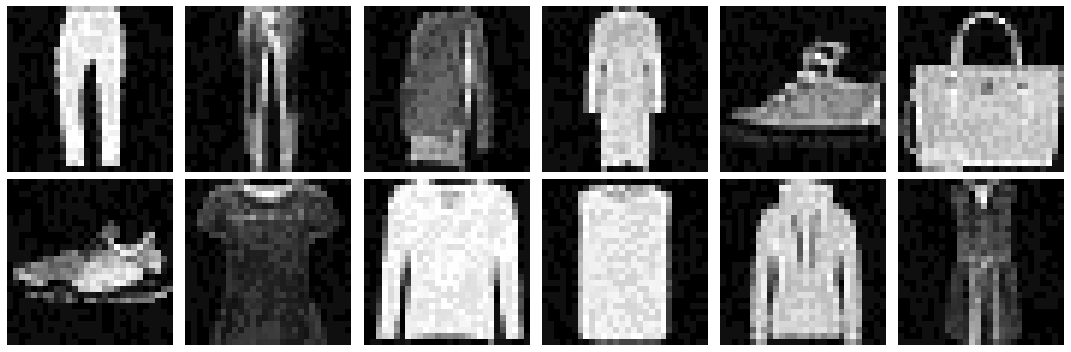

Attack Epsilon: 0.06; Whitebox Accuracy: 0.8403
Done!
Initial Accuracy of Whitebox Model:  0.8719


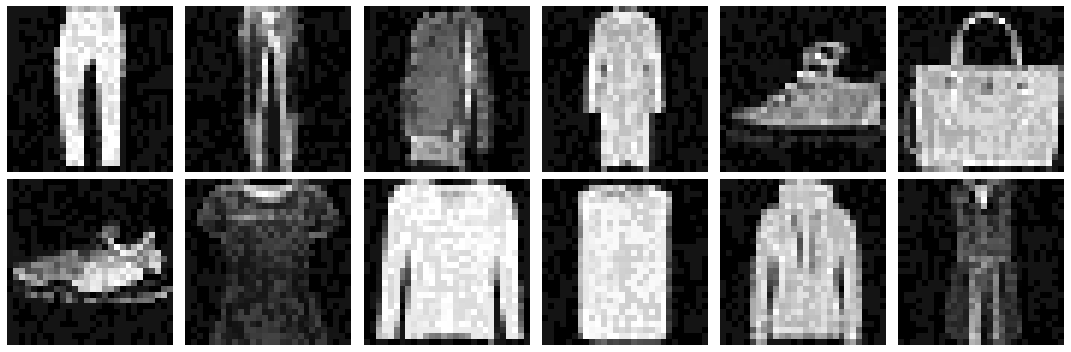

Attack Epsilon: 0.08; Whitebox Accuracy: 0.8319
Done!
Initial Accuracy of Whitebox Model:  0.8719


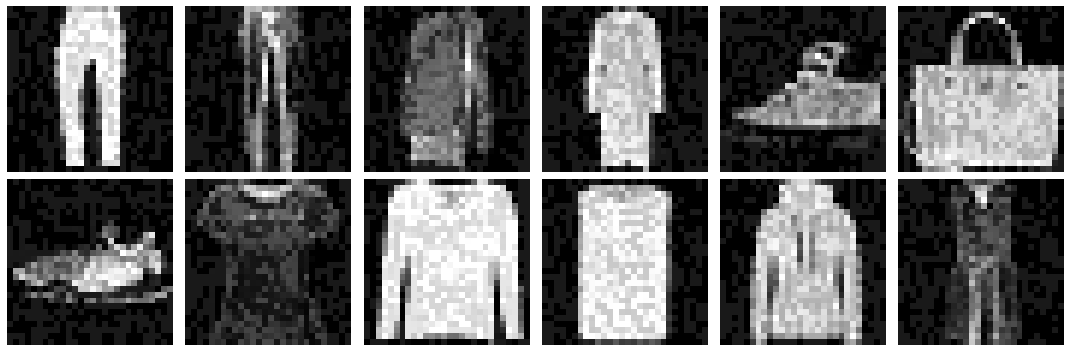

Attack Epsilon: 0.1; Whitebox Accuracy: 0.8244
Done!
Initial Accuracy of Whitebox Model:  0.8719


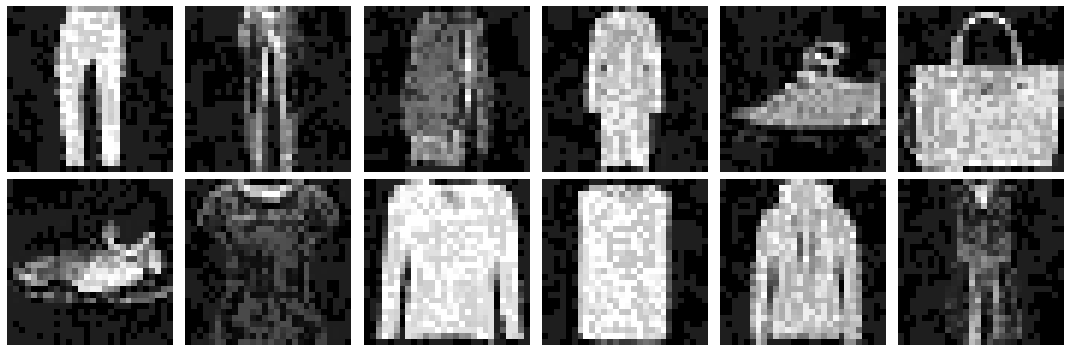

Attack Epsilon: 0.12; Whitebox Accuracy: 0.7008
Done!
Initial Accuracy of Whitebox Model:  0.8719


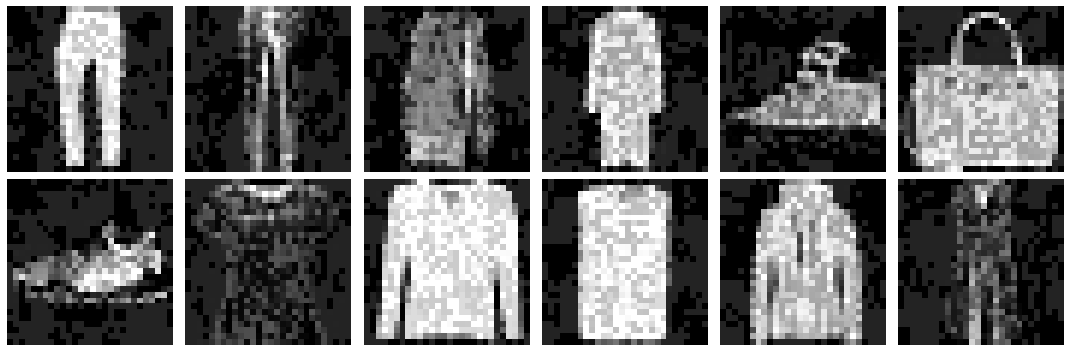

Attack Epsilon: 0.14; Whitebox Accuracy: 0.4253
Done!


In [75]:
pgd_trained_rfgsm_whitebox_accs = get_robust_accuracies(new_epsilon_range, pgd_model_name, attack_type = 'rFGSM')

Initial Accuracy of Whitebox Model:  0.8719


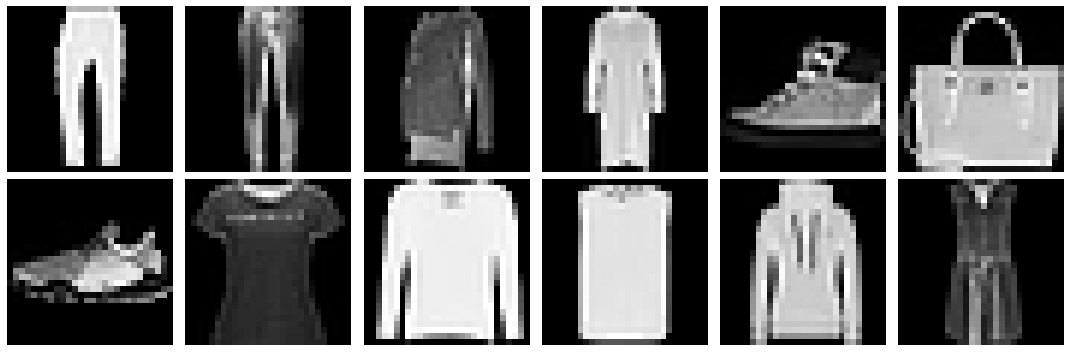

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8719
Done!
Initial Accuracy of Whitebox Model:  0.8719


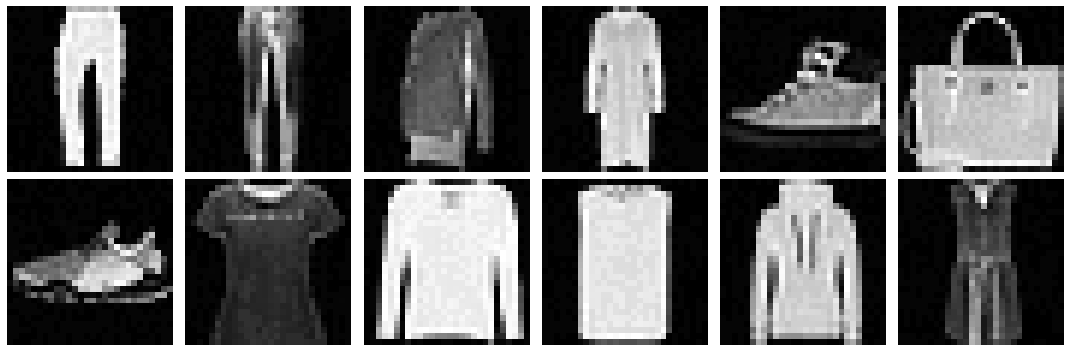

Attack Epsilon: 0.02; Whitebox Accuracy: 0.8548
Done!
Initial Accuracy of Whitebox Model:  0.8719


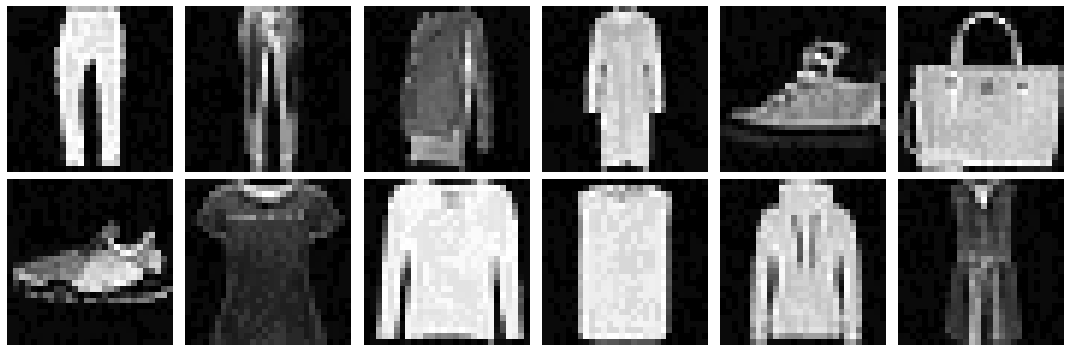

Attack Epsilon: 0.04; Whitebox Accuracy: 0.8393
Done!
Initial Accuracy of Whitebox Model:  0.8719


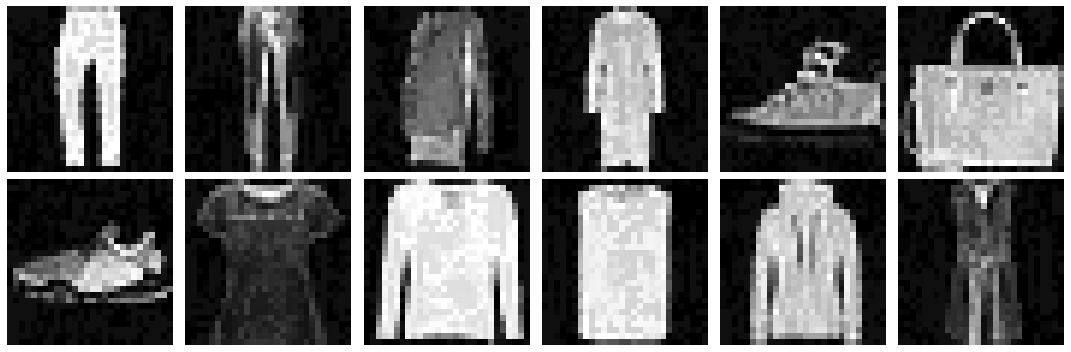

Attack Epsilon: 0.06; Whitebox Accuracy: 0.8212
Done!
Initial Accuracy of Whitebox Model:  0.8719


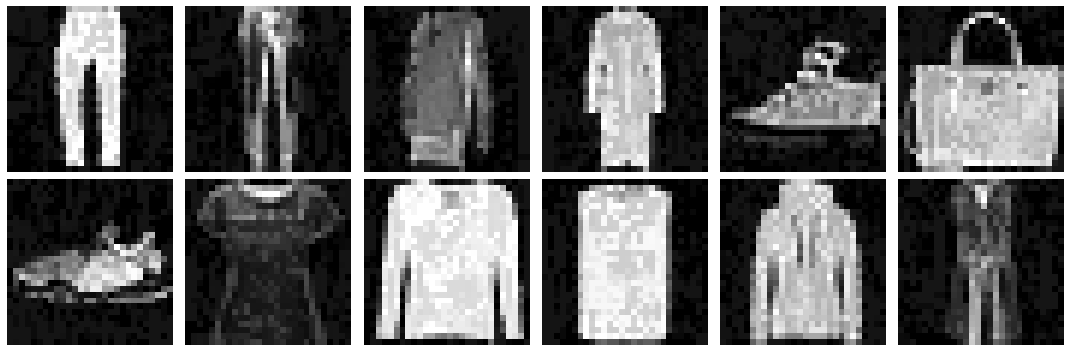

Attack Epsilon: 0.08; Whitebox Accuracy: 0.8046
Done!
Initial Accuracy of Whitebox Model:  0.8719


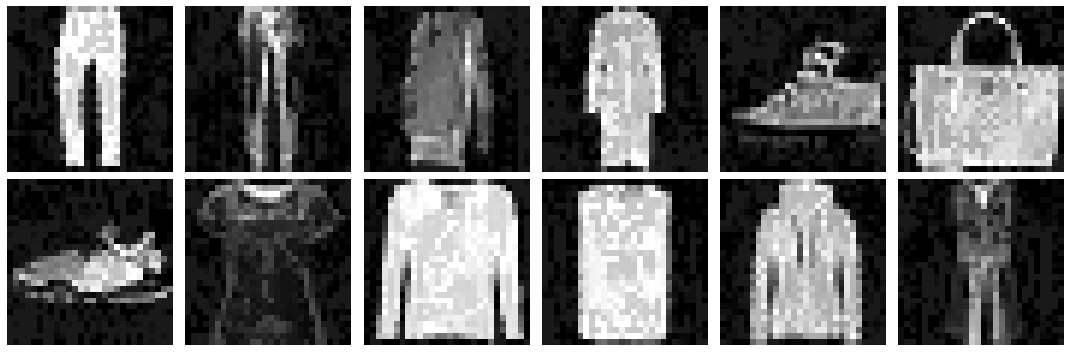

Attack Epsilon: 0.1; Whitebox Accuracy: 0.7759
Done!
Initial Accuracy of Whitebox Model:  0.8719


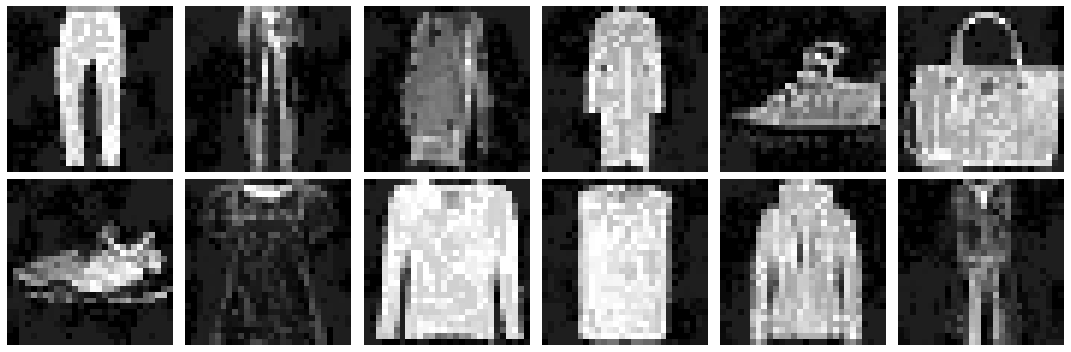

Attack Epsilon: 0.12; Whitebox Accuracy: 0.3817
Done!
Initial Accuracy of Whitebox Model:  0.8719


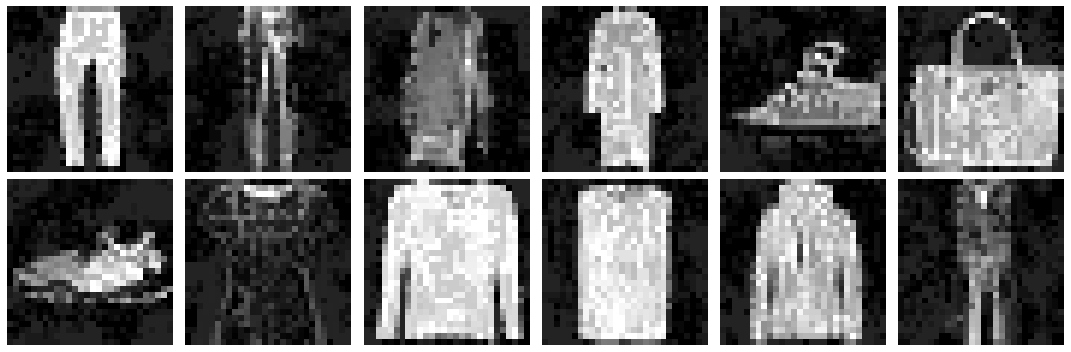

Attack Epsilon: 0.14; Whitebox Accuracy: 0.1331
Done!


In [76]:
pgd_trained_pgd_whitebox_accs = get_robust_accuracies(new_epsilon_range, pgd_model_name, attack_type = 'PGD')

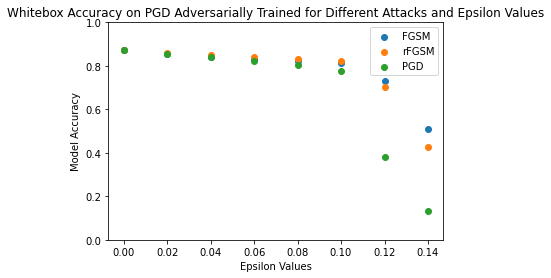

In [77]:
plot_AT_epsilon_performance_comparison(new_epsilon_range, pgd_trained_fgsm_whitebox_accs, pgd_trained_rfgsm_whitebox_accs, pgd_trained_pgd_whitebox_accs, train_type = 'PGD')

Bonus Points

In [105]:
bonus_epsilon_range = np.linspace(0,0.25,6)

In [106]:
def test_robustness(epsilon_range, model_name):
    pgd_accs = get_robust_accuracies(epsilon_range, model_name, attack_type = 'PGD')
    fgsm_accs = get_robust_accuracies(epsilon_range, model_name, attack_type = 'FGSM')
    rfgsm_accs = get_robust_accuracies(epsilon_range, model_name, attack_type = 'rFGSM')
    print(len(pgd_accs), len(fgsm_accs), len(rfgsm_accs), len(bonus_epsilon_range))
    plot_AT_epsilon_performance_comparison(epsilon_range, fgsm_accs, rfgsm_accs, pgd_accs, train_type = 'PGD eps 0.05')

In [107]:
eps_05_model_name = 'netA_advtrain_pgd0p1_eps05.pt'
eps_15_model_name = 'netA_advtrain_pgd0p1_eps15.pt'
eps_20_model_name = 'netA_advtrain_pgd0p1_eps20.pt'

Initial Accuracy of Whitebox Model:  0.8952


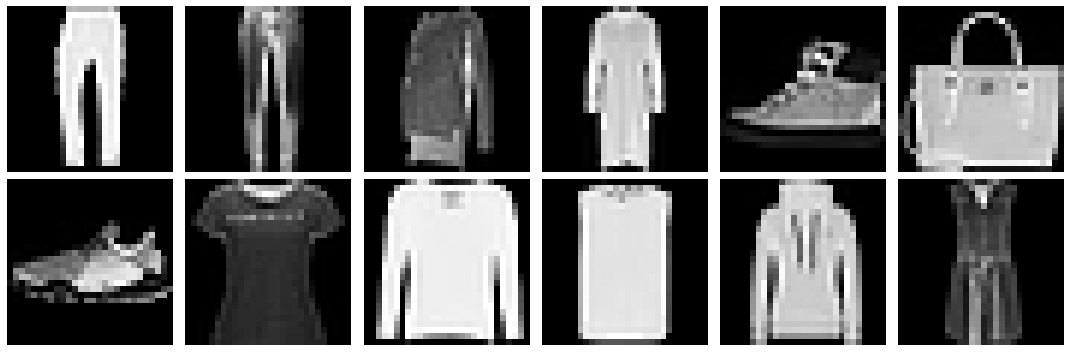

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8952
Done!
Initial Accuracy of Whitebox Model:  0.8952


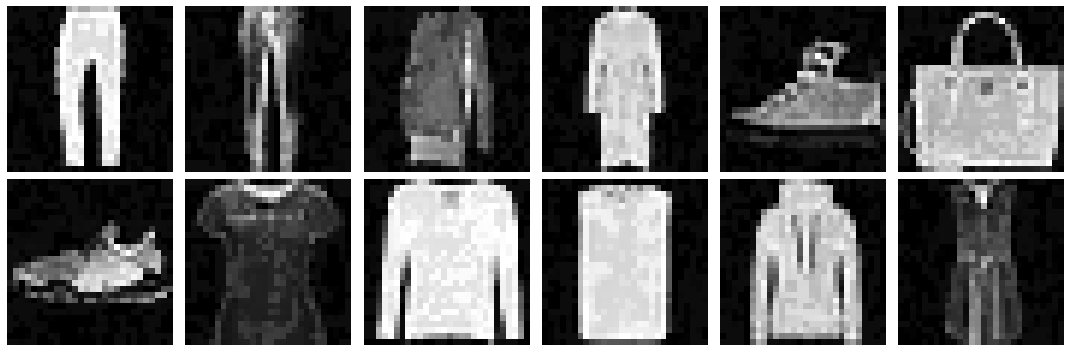

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8271
Done!
Initial Accuracy of Whitebox Model:  0.8952


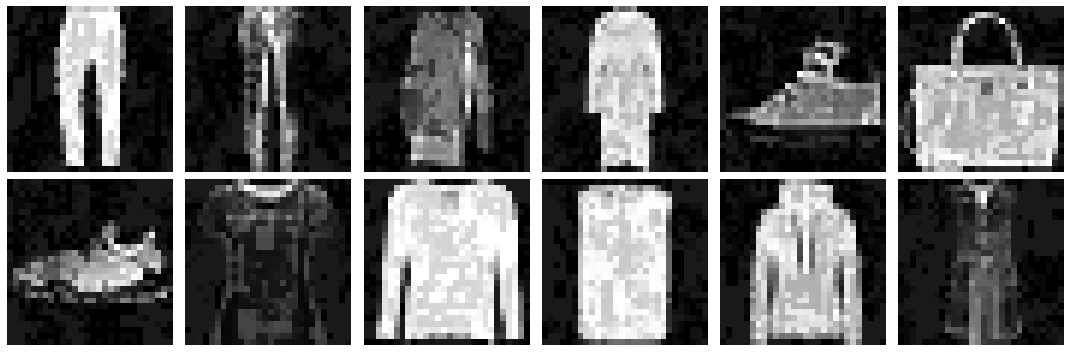

Attack Epsilon: 0.1; Whitebox Accuracy: 0.4316
Done!
Initial Accuracy of Whitebox Model:  0.8952


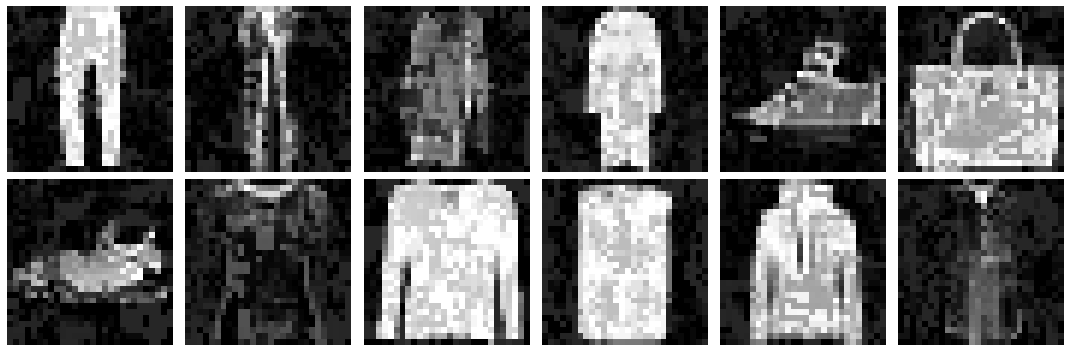

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.0901
Done!
Initial Accuracy of Whitebox Model:  0.8952


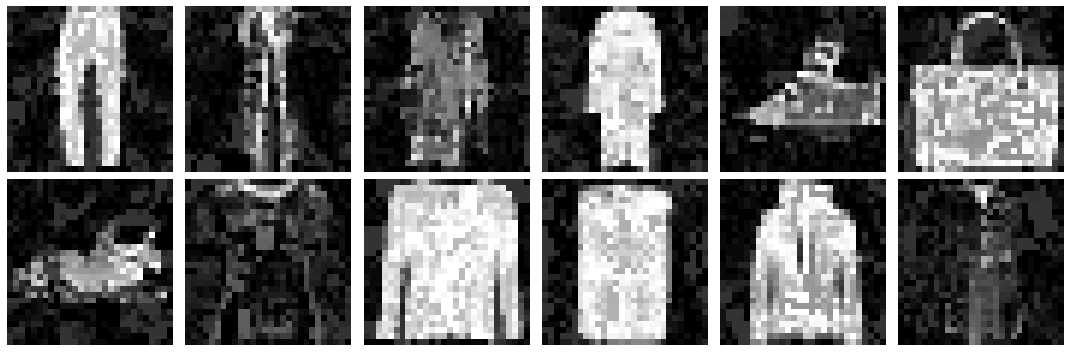

Attack Epsilon: 0.2; Whitebox Accuracy: 0.0238
Done!
Initial Accuracy of Whitebox Model:  0.8952


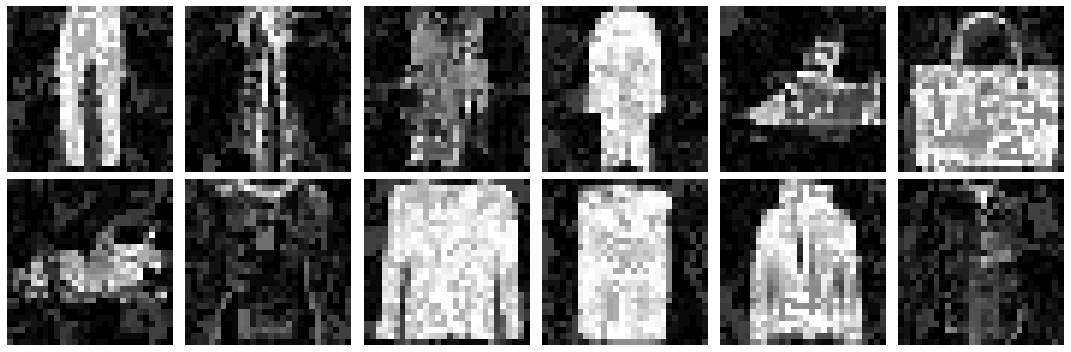

Attack Epsilon: 0.25; Whitebox Accuracy: 0.0056
Done!
Initial Accuracy of Whitebox Model:  0.8952


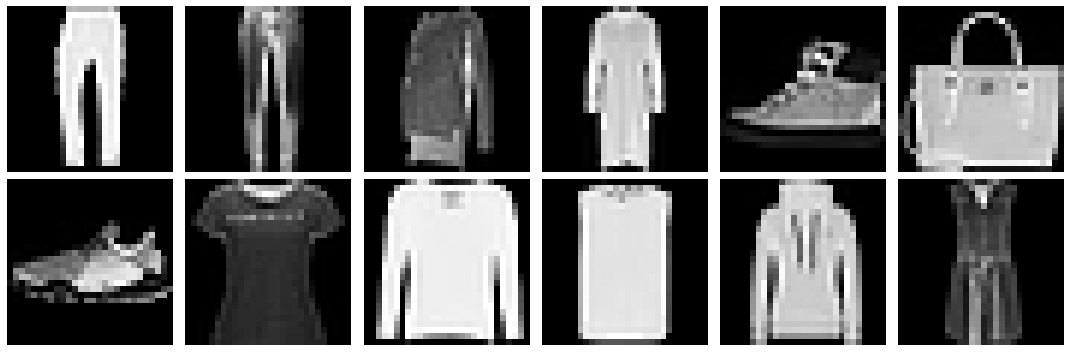

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8952
Done!
Initial Accuracy of Whitebox Model:  0.8952


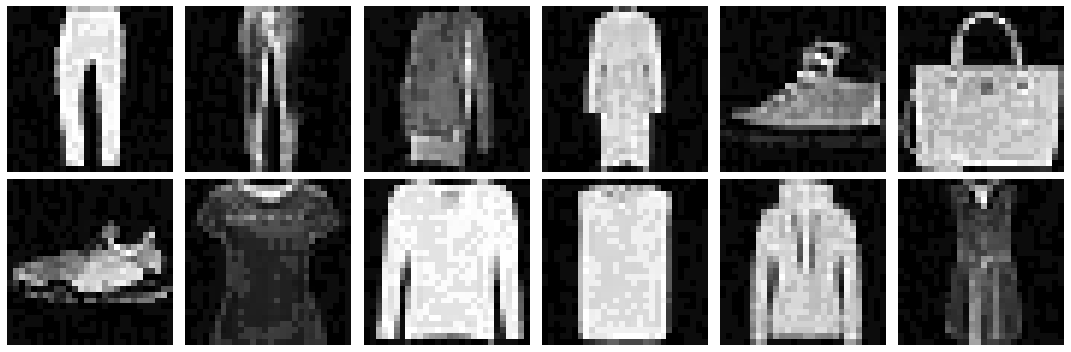

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8395
Done!
Initial Accuracy of Whitebox Model:  0.8952


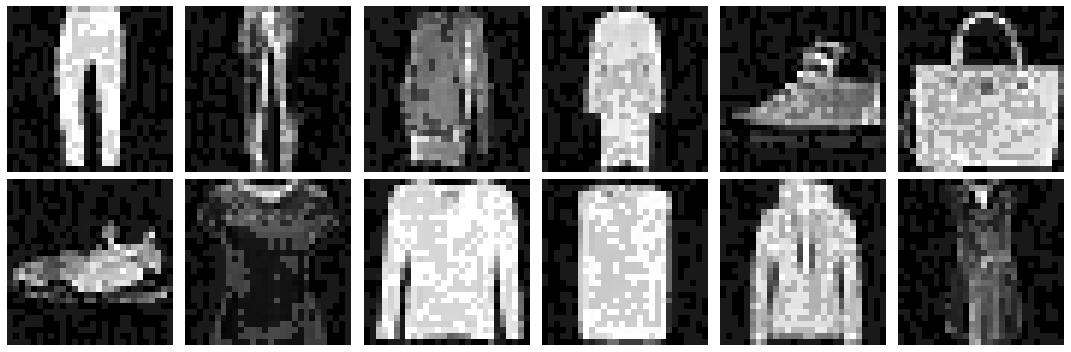

Attack Epsilon: 0.1; Whitebox Accuracy: 0.7508
Done!
Initial Accuracy of Whitebox Model:  0.8952


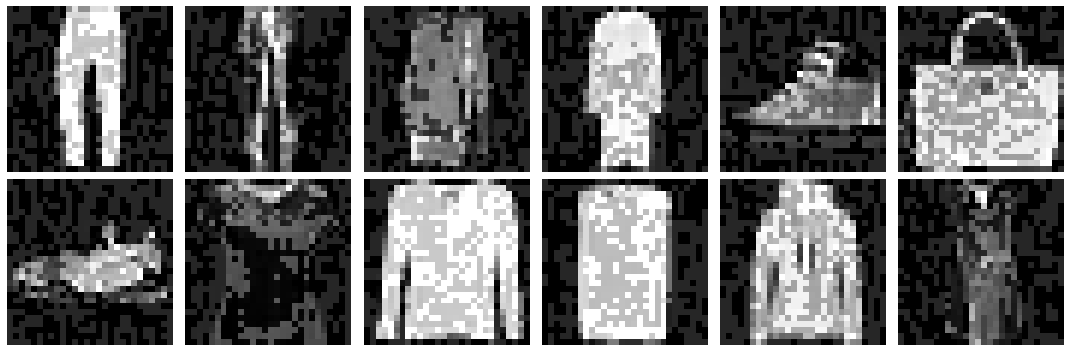

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.4689
Done!
Initial Accuracy of Whitebox Model:  0.8952


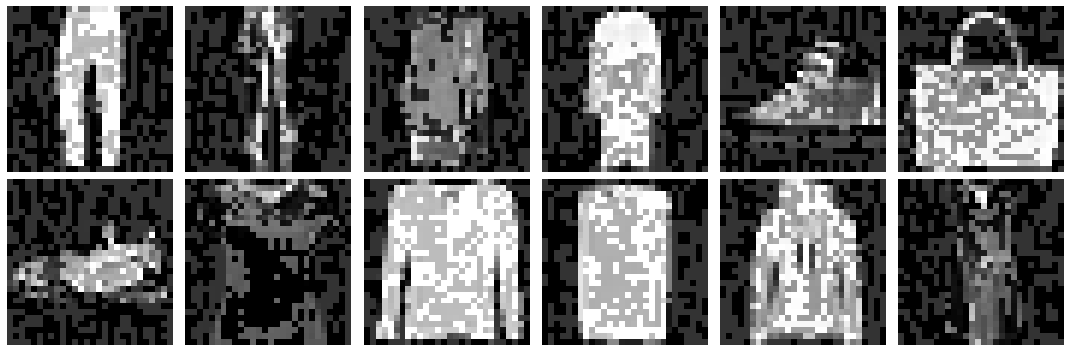

Attack Epsilon: 0.2; Whitebox Accuracy: 0.2712
Done!
Initial Accuracy of Whitebox Model:  0.8952


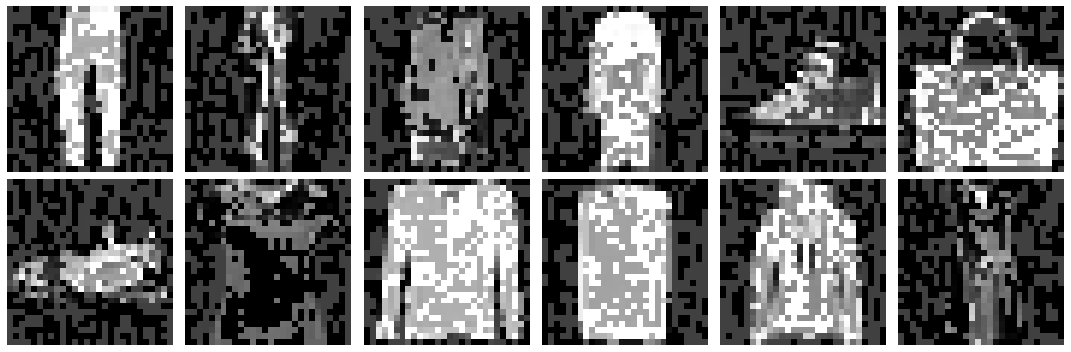

Attack Epsilon: 0.25; Whitebox Accuracy: 0.1915
Done!
Initial Accuracy of Whitebox Model:  0.8952


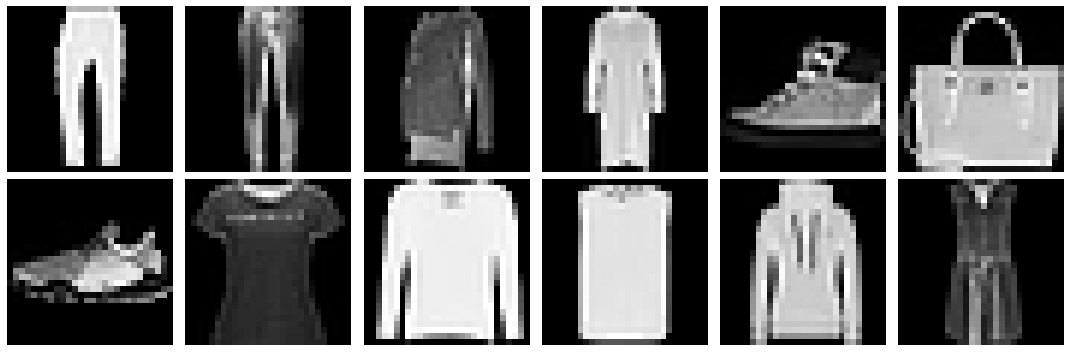

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8952
Done!
Initial Accuracy of Whitebox Model:  0.8952


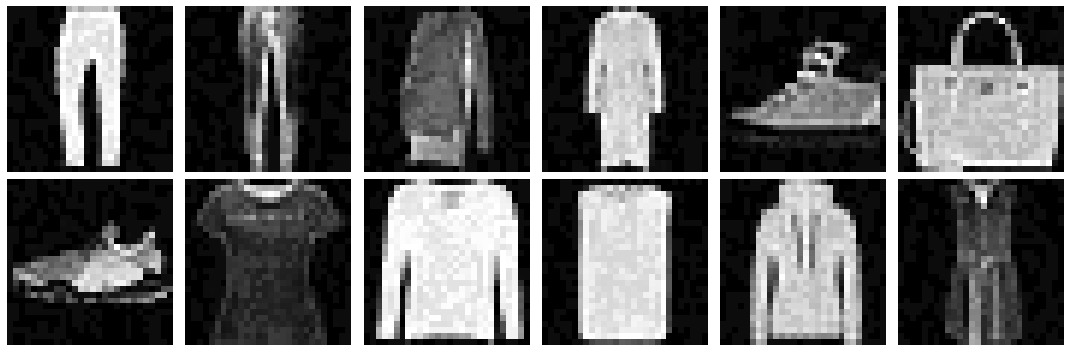

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8536
Done!
Initial Accuracy of Whitebox Model:  0.8952


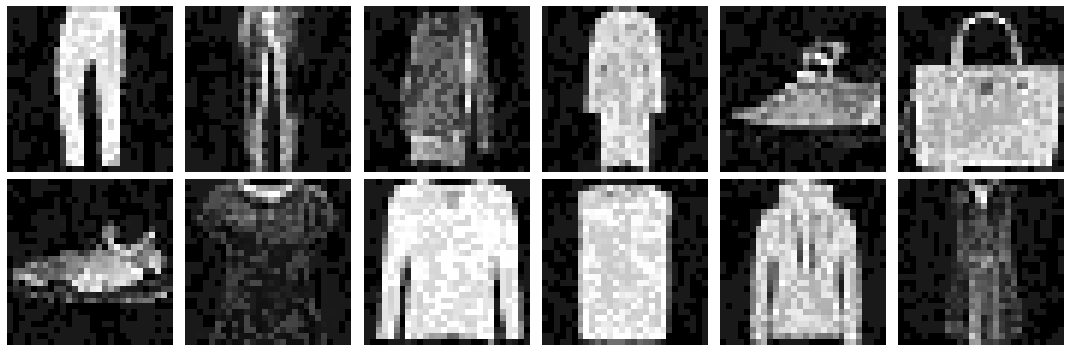

Attack Epsilon: 0.1; Whitebox Accuracy: 0.7133
Done!
Initial Accuracy of Whitebox Model:  0.8952


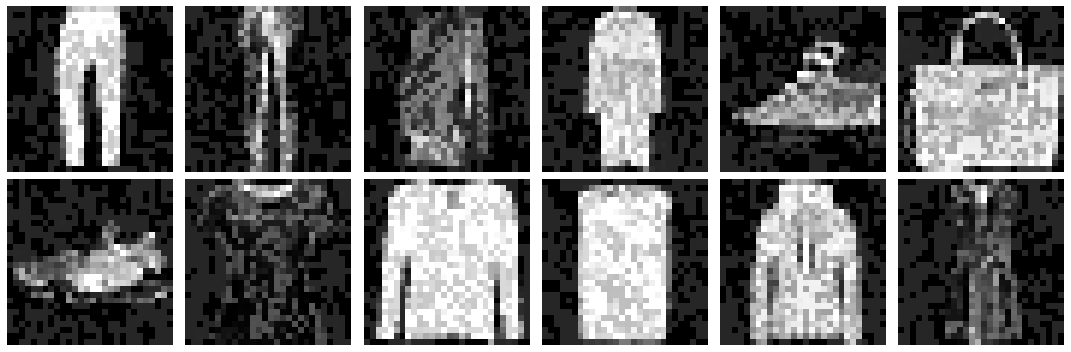

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.3508
Done!
Initial Accuracy of Whitebox Model:  0.8952


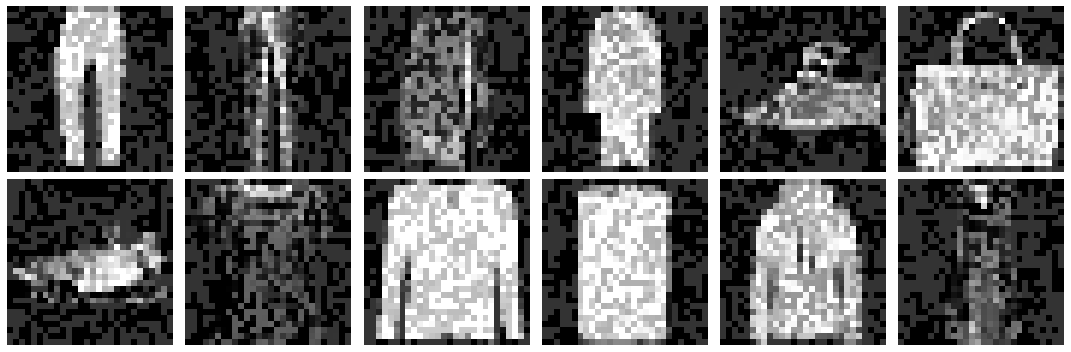

Attack Epsilon: 0.2; Whitebox Accuracy: 0.1434
Done!
Initial Accuracy of Whitebox Model:  0.8952


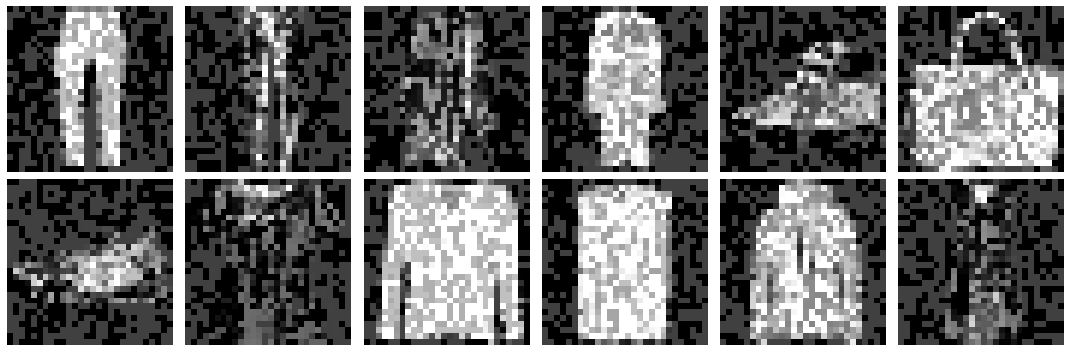

Attack Epsilon: 0.25; Whitebox Accuracy: 0.073
Done!
6 6 6 6


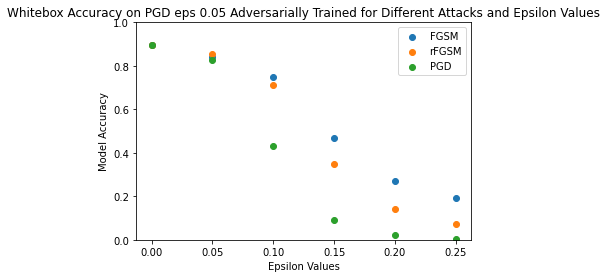

In [108]:
test_robustness(bonus_epsilon_range, eps_05_model_name)

Initial Accuracy of Whitebox Model:  0.8555


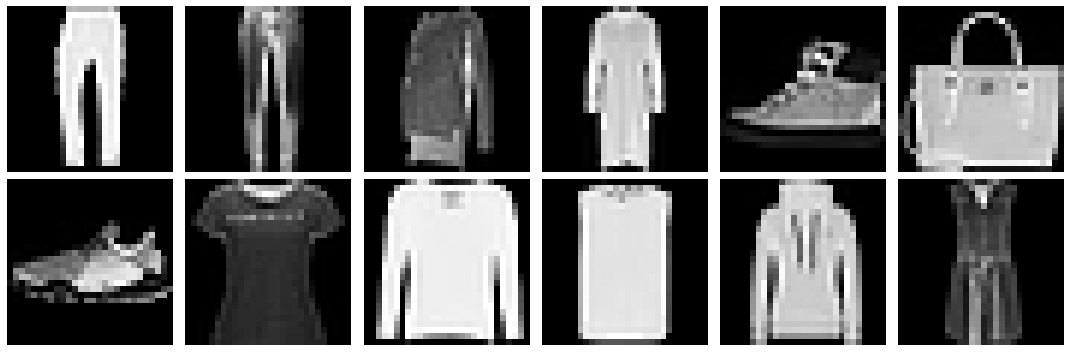

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8555
Done!
Initial Accuracy of Whitebox Model:  0.8555


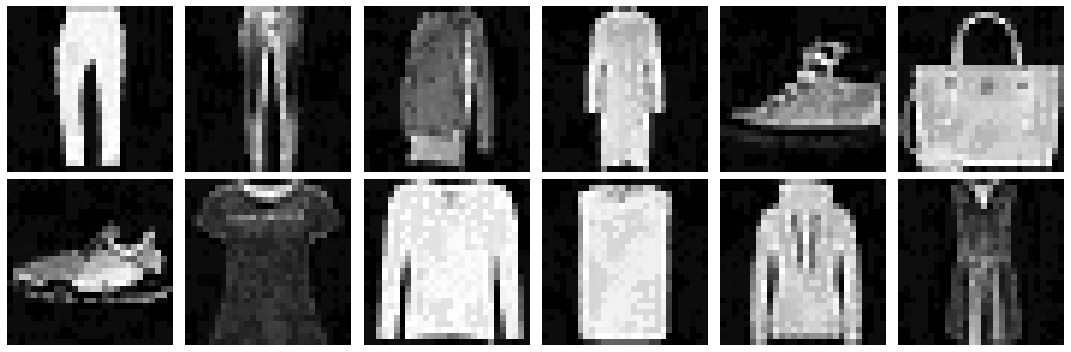

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8216
Done!
Initial Accuracy of Whitebox Model:  0.8555


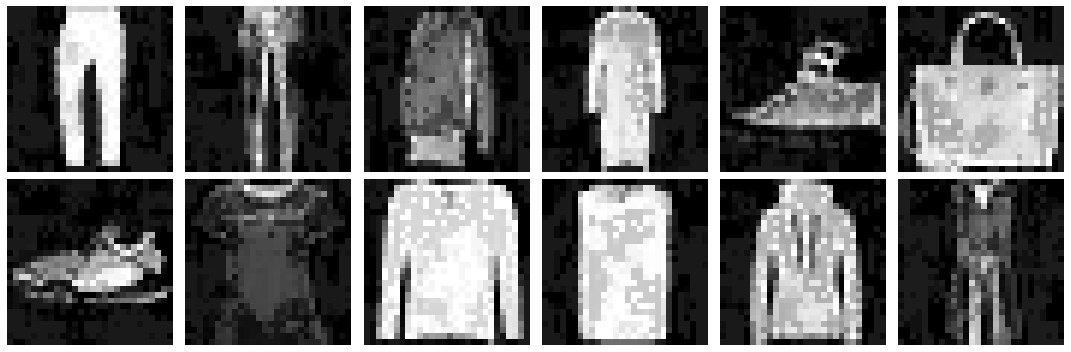

Attack Epsilon: 0.1; Whitebox Accuracy: 0.7947
Done!
Initial Accuracy of Whitebox Model:  0.8555


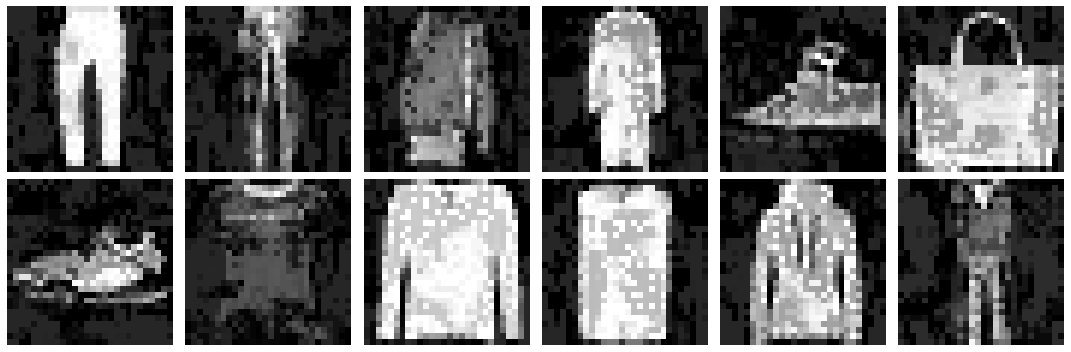

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.7598
Done!
Initial Accuracy of Whitebox Model:  0.8555


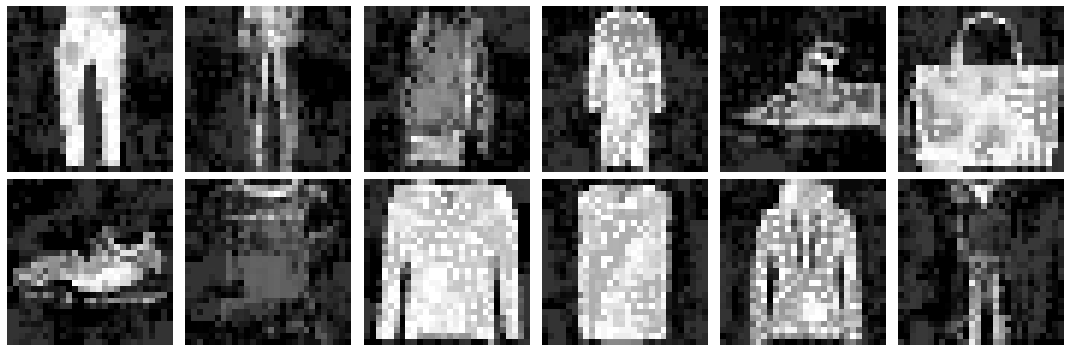

Attack Epsilon: 0.2; Whitebox Accuracy: 0.0157
Done!
Initial Accuracy of Whitebox Model:  0.8555


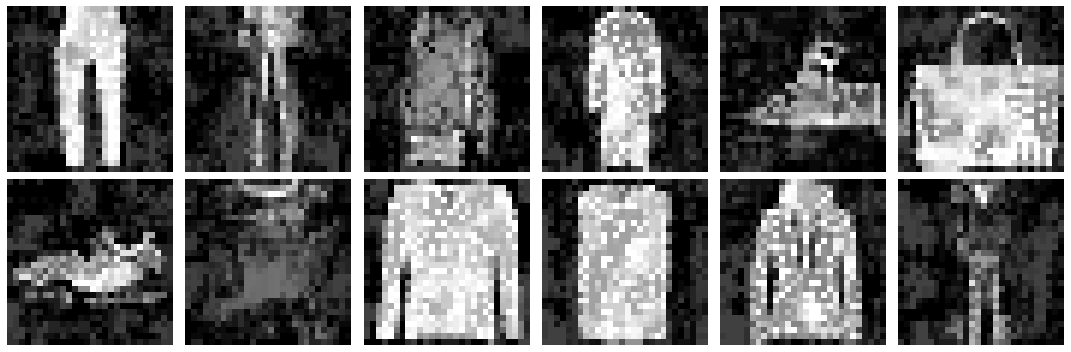

Attack Epsilon: 0.25; Whitebox Accuracy: 0.0075
Done!
Initial Accuracy of Whitebox Model:  0.8555


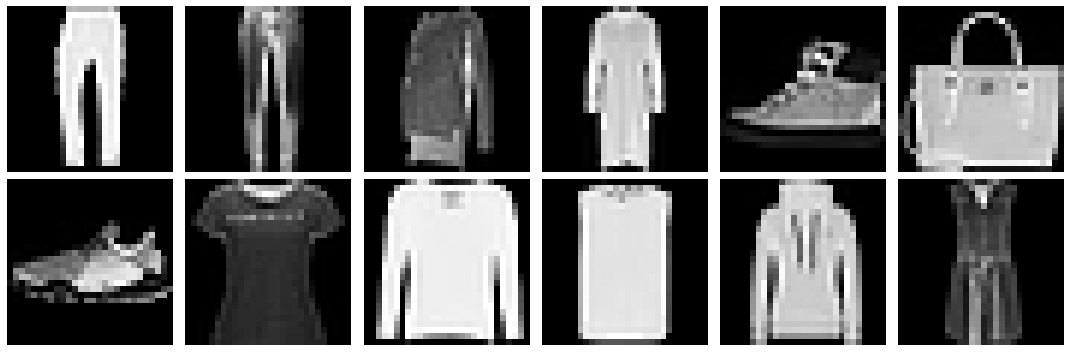

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8555
Done!
Initial Accuracy of Whitebox Model:  0.8555


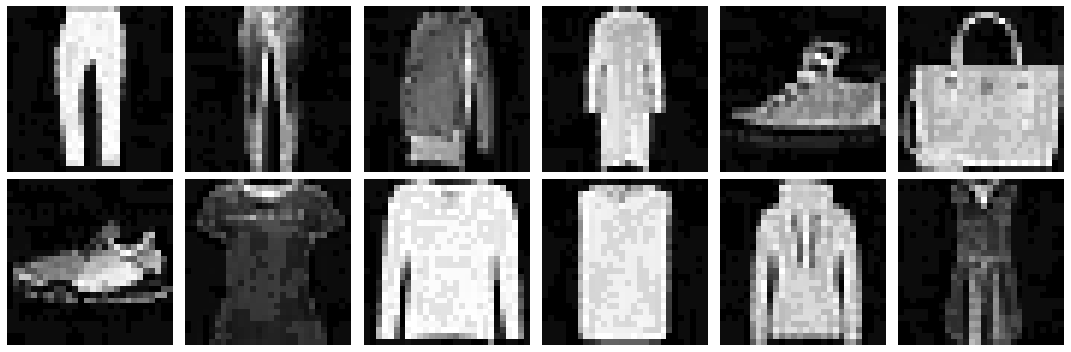

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8327
Done!
Initial Accuracy of Whitebox Model:  0.8555


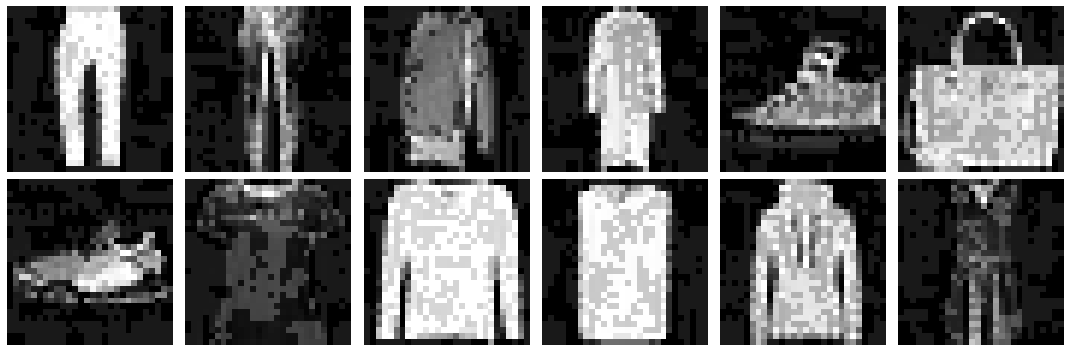

Attack Epsilon: 0.1; Whitebox Accuracy: 0.8248
Done!
Initial Accuracy of Whitebox Model:  0.8555


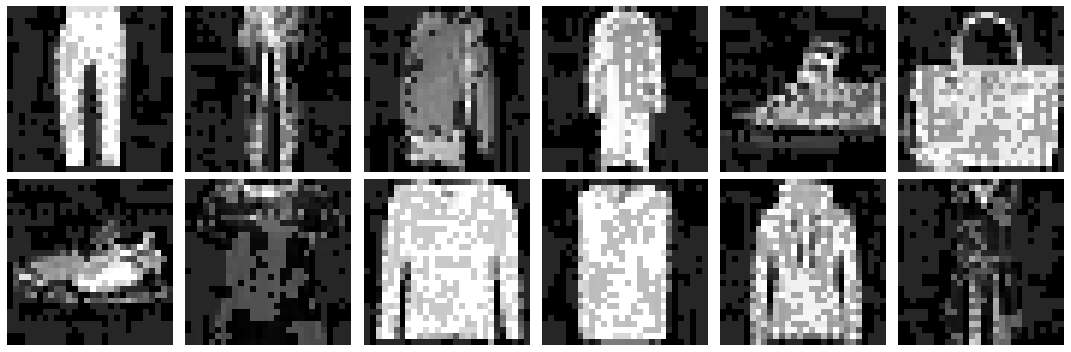

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.815
Done!
Initial Accuracy of Whitebox Model:  0.8555


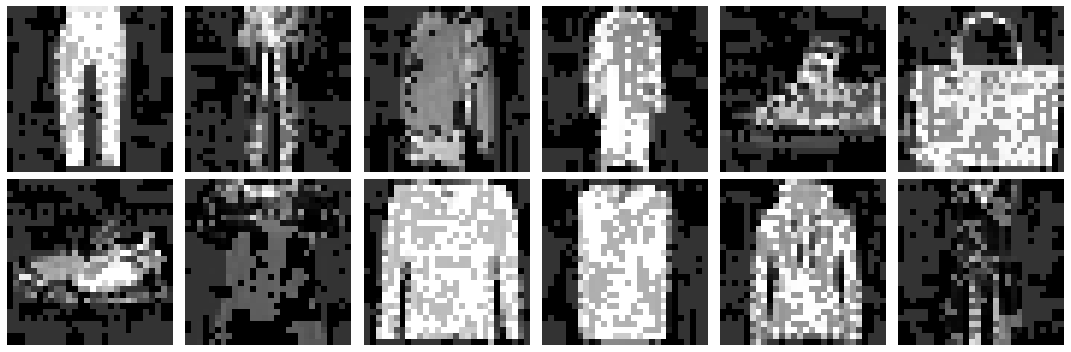

Attack Epsilon: 0.2; Whitebox Accuracy: 0.2059
Done!
Initial Accuracy of Whitebox Model:  0.8555


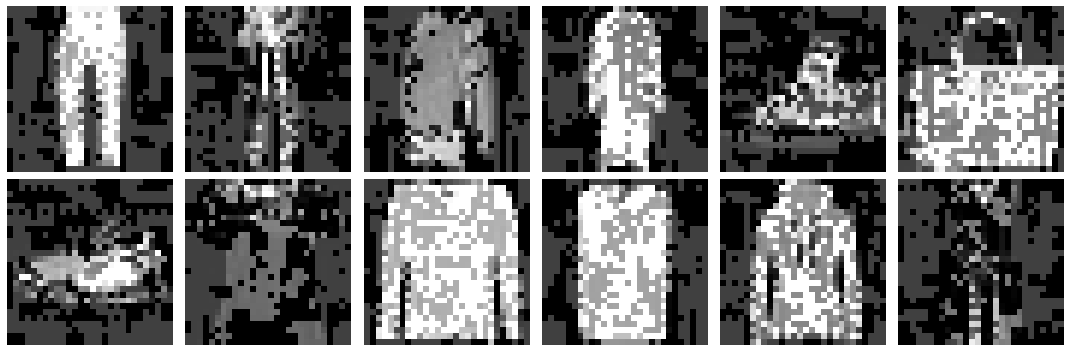

Attack Epsilon: 0.25; Whitebox Accuracy: 0.1701
Done!
Initial Accuracy of Whitebox Model:  0.8555


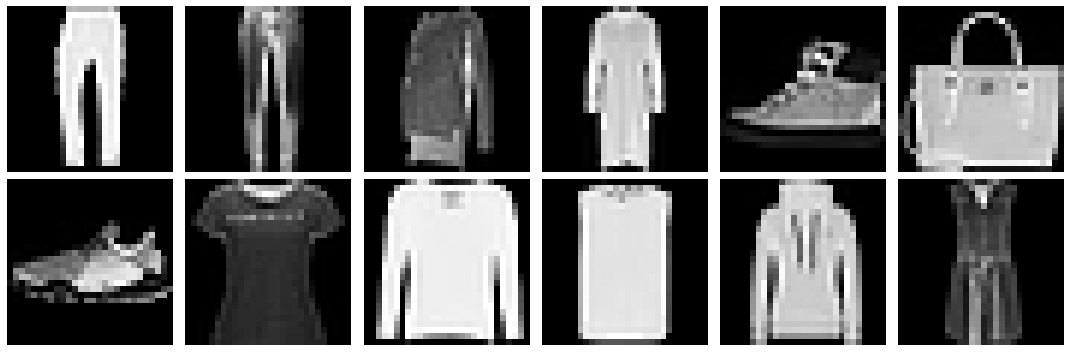

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8555
Done!
Initial Accuracy of Whitebox Model:  0.8555


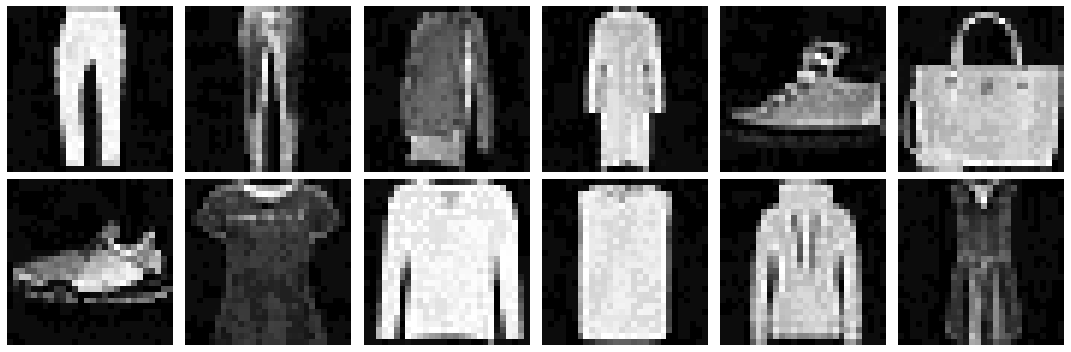

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8362
Done!
Initial Accuracy of Whitebox Model:  0.8555


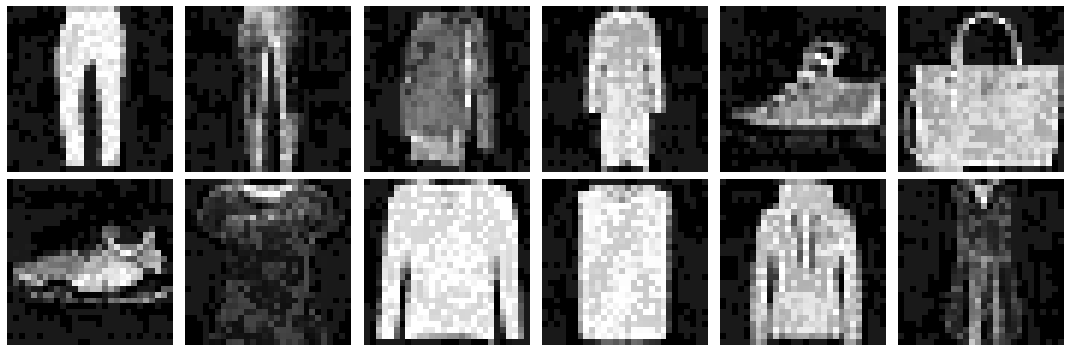

Attack Epsilon: 0.1; Whitebox Accuracy: 0.8321
Done!
Initial Accuracy of Whitebox Model:  0.8555


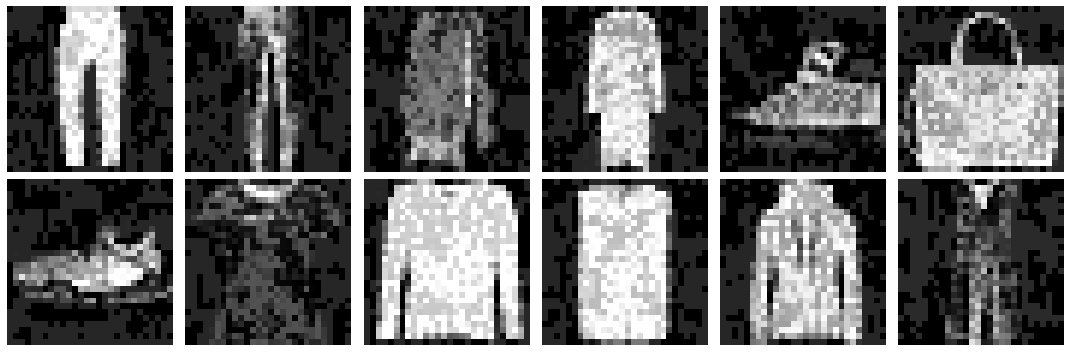

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.8243
Done!
Initial Accuracy of Whitebox Model:  0.8555


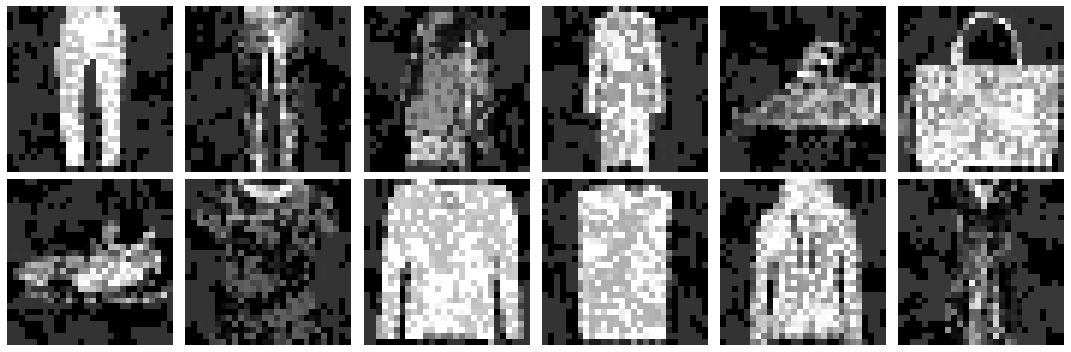

Attack Epsilon: 0.2; Whitebox Accuracy: 0.1587
Done!
Initial Accuracy of Whitebox Model:  0.8555


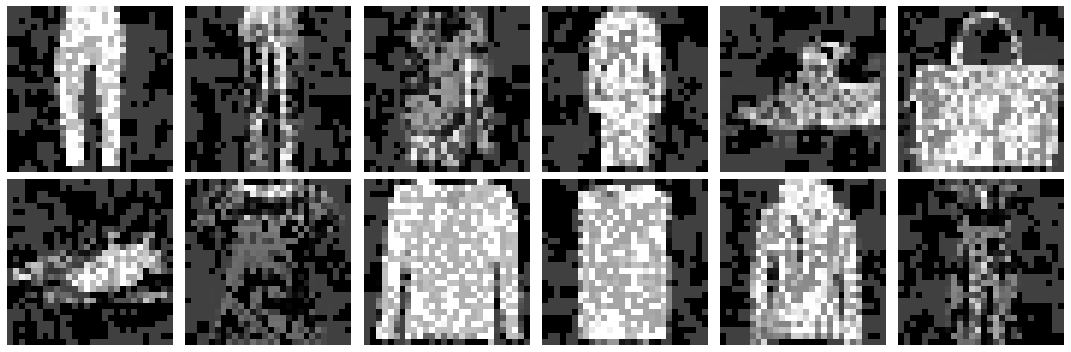

Attack Epsilon: 0.25; Whitebox Accuracy: 0.1119
Done!
6 6 6 6


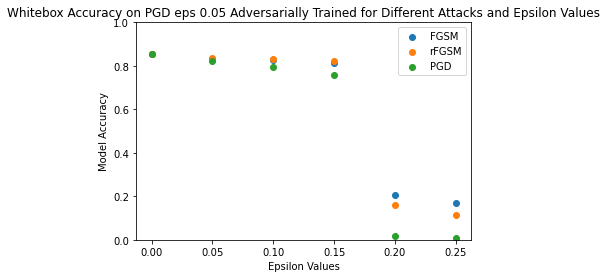

In [109]:
test_robustness(bonus_epsilon_range, eps_15_model_name)

Initial Accuracy of Whitebox Model:  0.8374


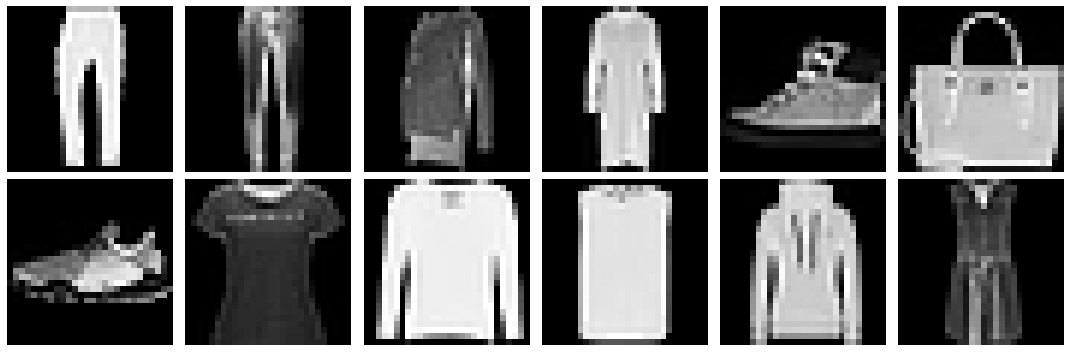

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8374
Done!
Initial Accuracy of Whitebox Model:  0.8374


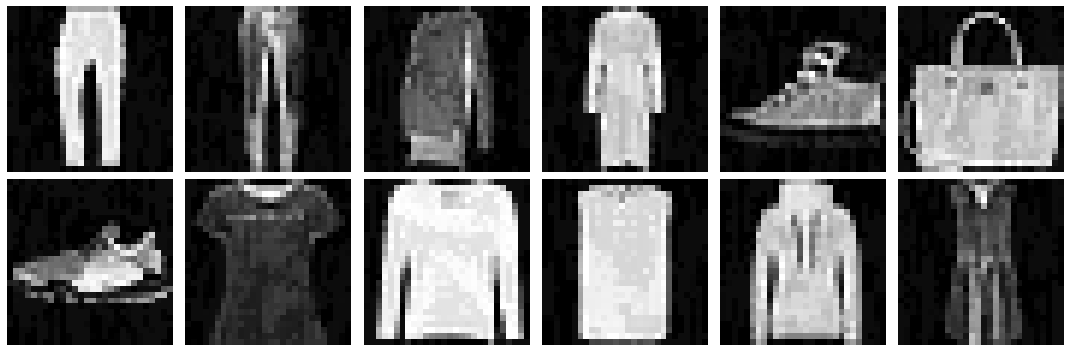

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8029
Done!
Initial Accuracy of Whitebox Model:  0.8374


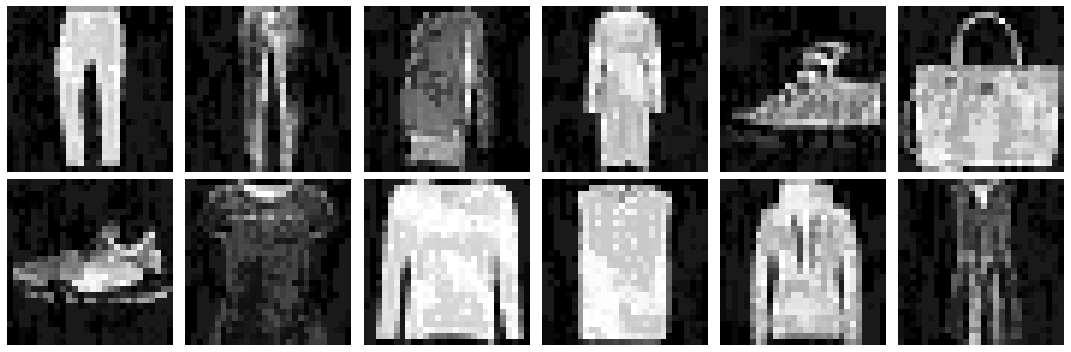

Attack Epsilon: 0.1; Whitebox Accuracy: 0.7789
Done!
Initial Accuracy of Whitebox Model:  0.8374


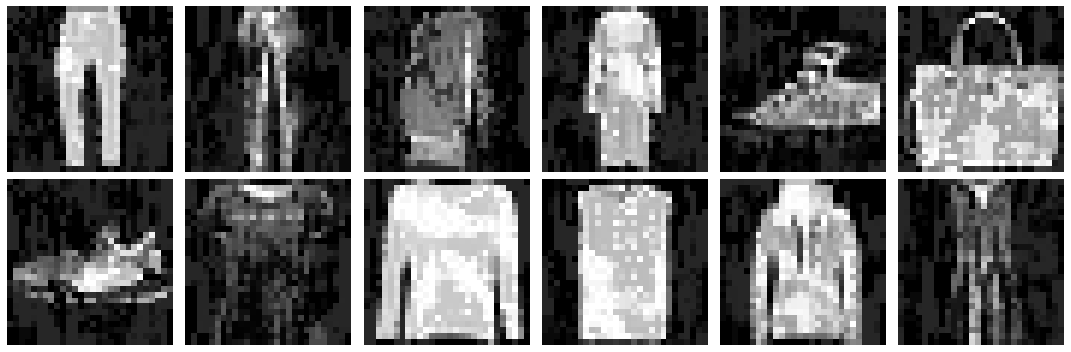

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.7541
Done!
Initial Accuracy of Whitebox Model:  0.8374


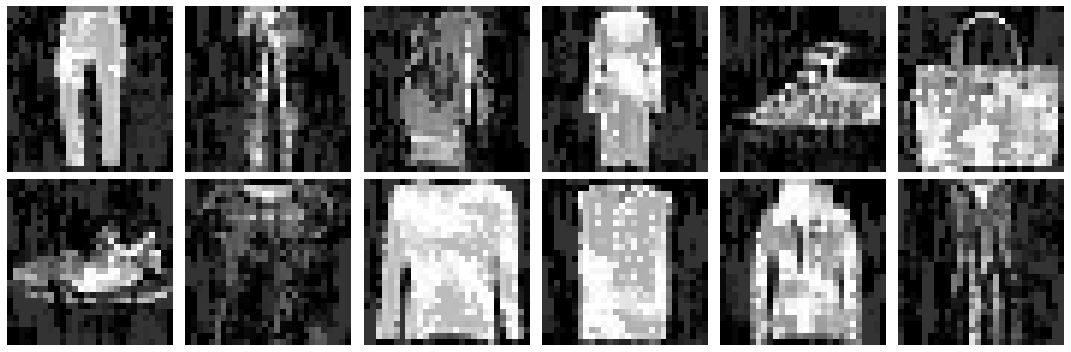

Attack Epsilon: 0.2; Whitebox Accuracy: 0.7272
Done!
Initial Accuracy of Whitebox Model:  0.8374


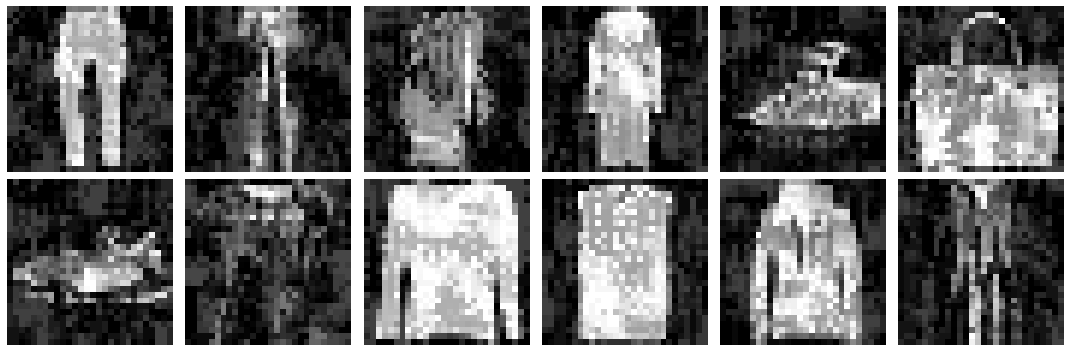

Attack Epsilon: 0.25; Whitebox Accuracy: 0.0259
Done!
Initial Accuracy of Whitebox Model:  0.8374


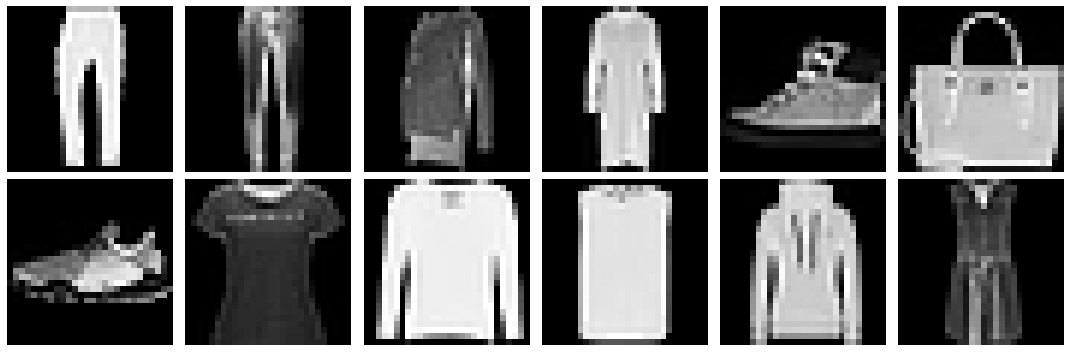

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8374
Done!
Initial Accuracy of Whitebox Model:  0.8374


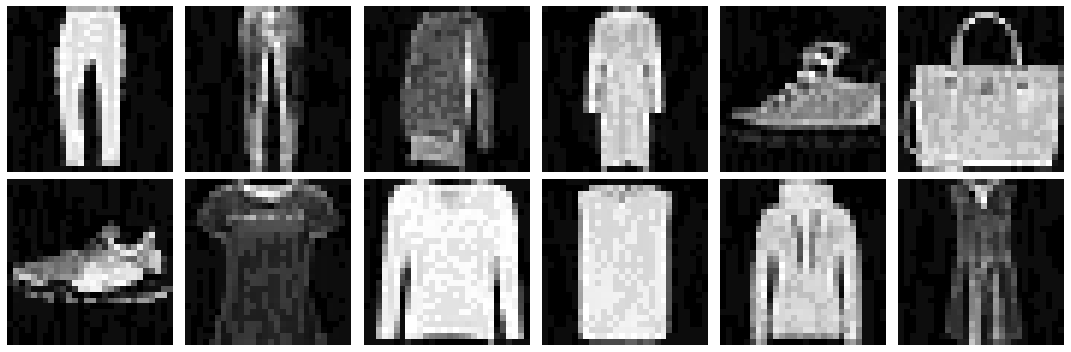

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8165
Done!
Initial Accuracy of Whitebox Model:  0.8374


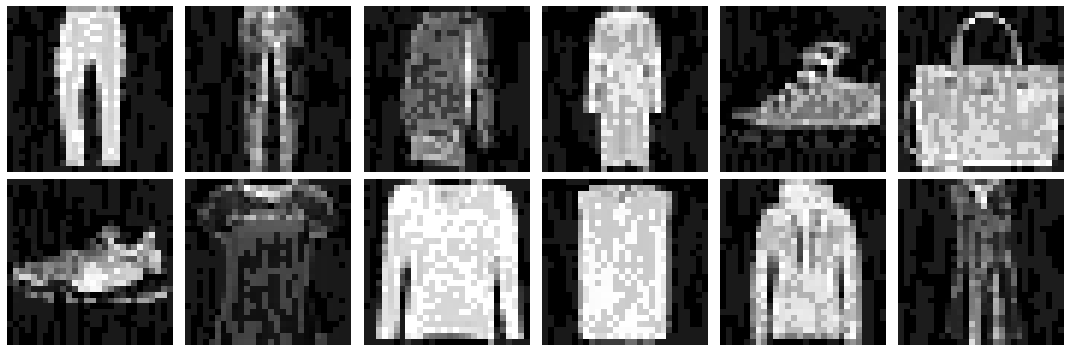

Attack Epsilon: 0.1; Whitebox Accuracy: 0.8123
Done!
Initial Accuracy of Whitebox Model:  0.8374


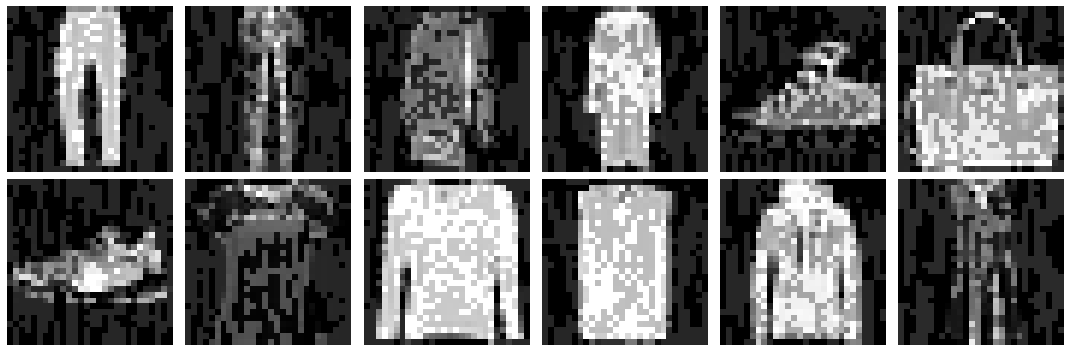

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.8111
Done!
Initial Accuracy of Whitebox Model:  0.8374


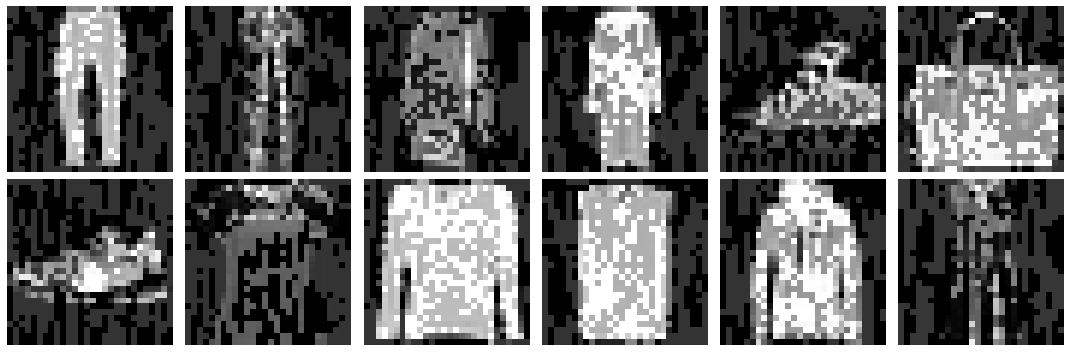

Attack Epsilon: 0.2; Whitebox Accuracy: 0.8002
Done!
Initial Accuracy of Whitebox Model:  0.8374


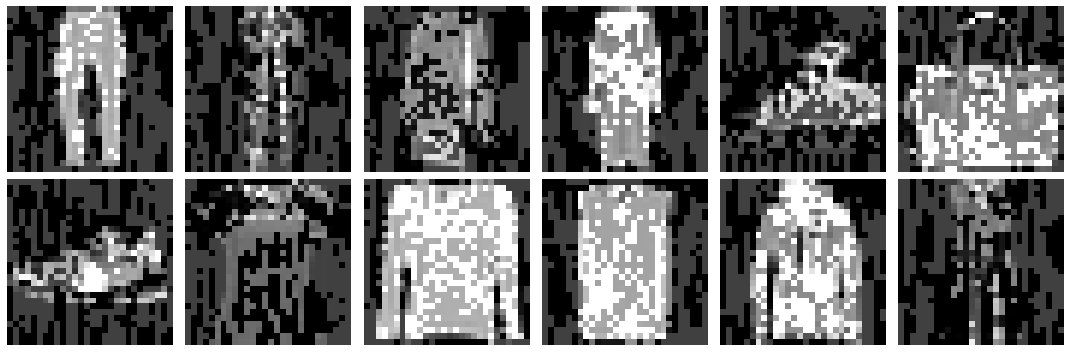

Attack Epsilon: 0.25; Whitebox Accuracy: 0.3102
Done!
Initial Accuracy of Whitebox Model:  0.8374


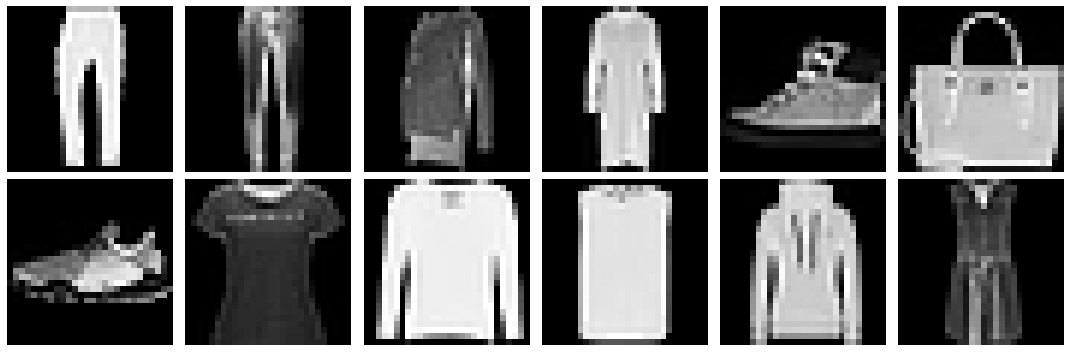

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8374
Done!
Initial Accuracy of Whitebox Model:  0.8374


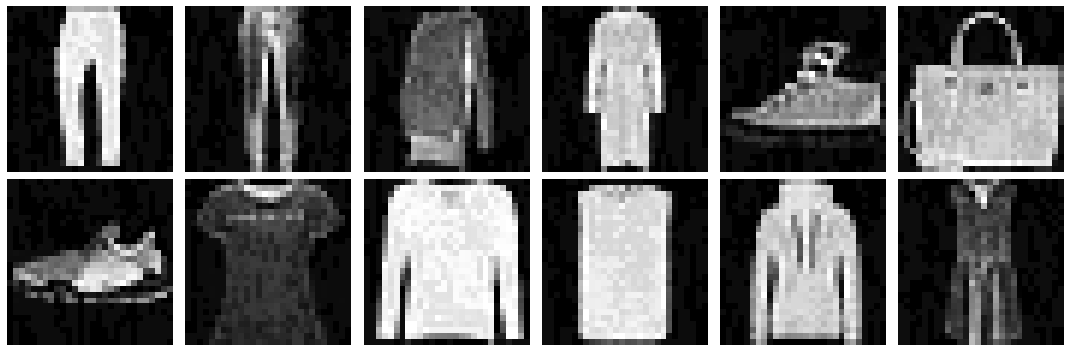

Attack Epsilon: 0.05; Whitebox Accuracy: 0.818
Done!
Initial Accuracy of Whitebox Model:  0.8374


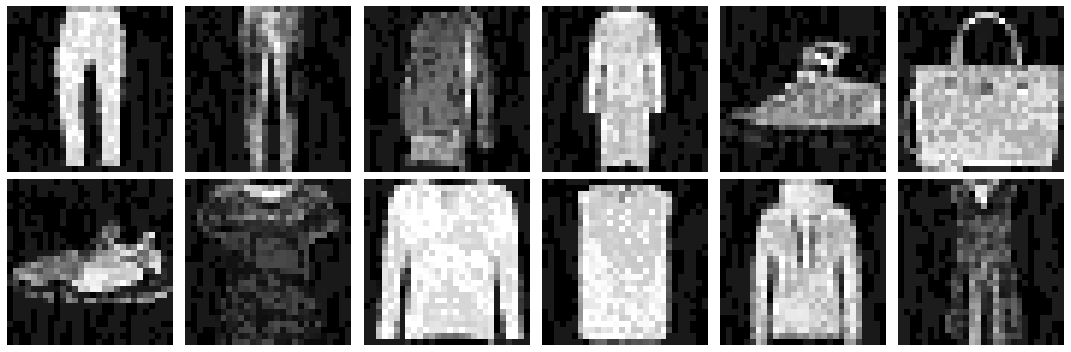

Attack Epsilon: 0.1; Whitebox Accuracy: 0.8163
Done!
Initial Accuracy of Whitebox Model:  0.8374


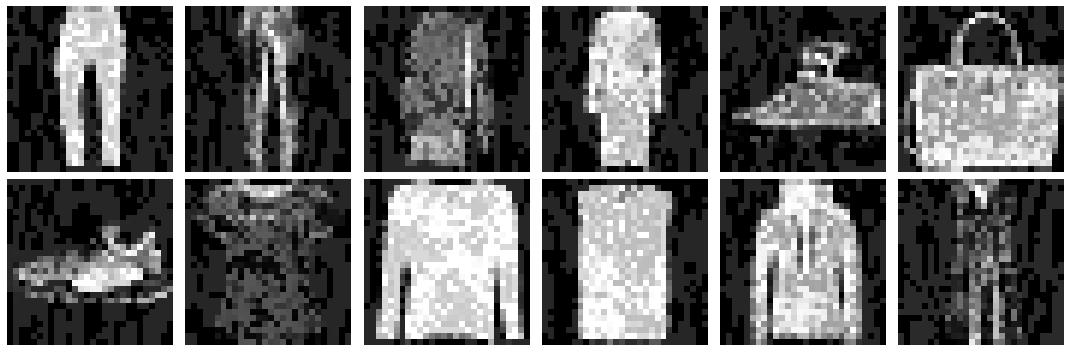

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.8121
Done!
Initial Accuracy of Whitebox Model:  0.8374


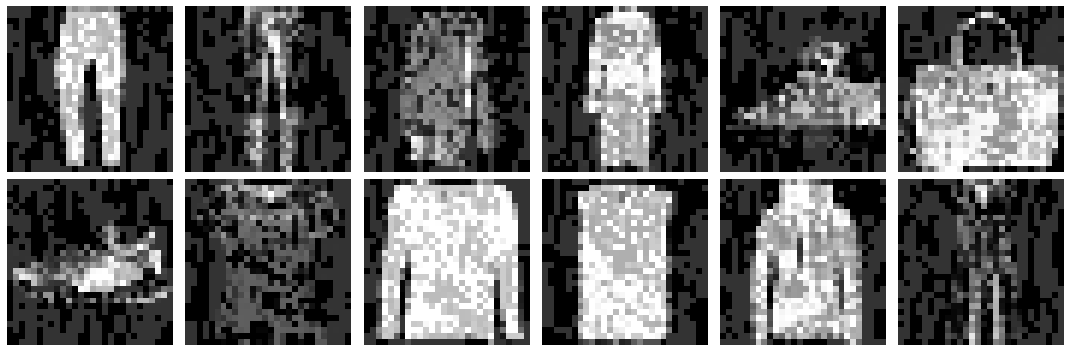

Attack Epsilon: 0.2; Whitebox Accuracy: 0.8081
Done!
Initial Accuracy of Whitebox Model:  0.8374


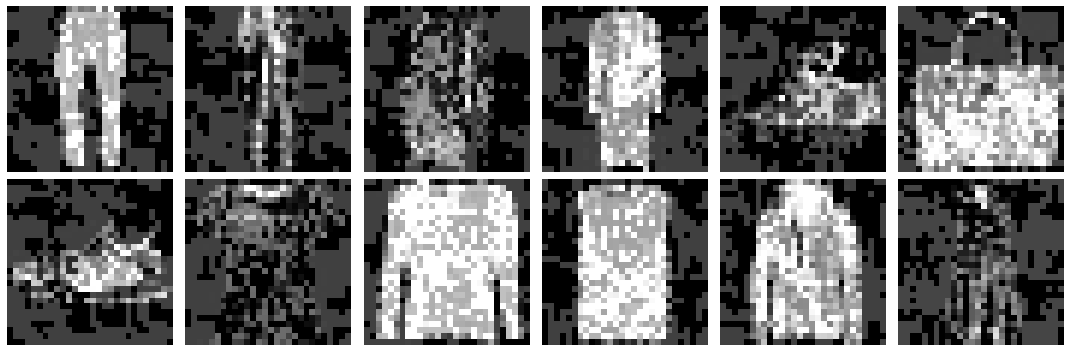

Attack Epsilon: 0.25; Whitebox Accuracy: 0.2673
Done!
6 6 6 6


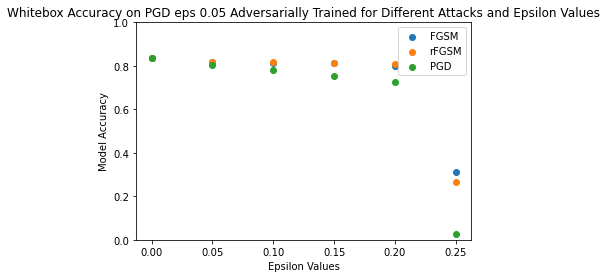

In [110]:
test_robustness(bonus_epsilon_range, eps_20_model_name)

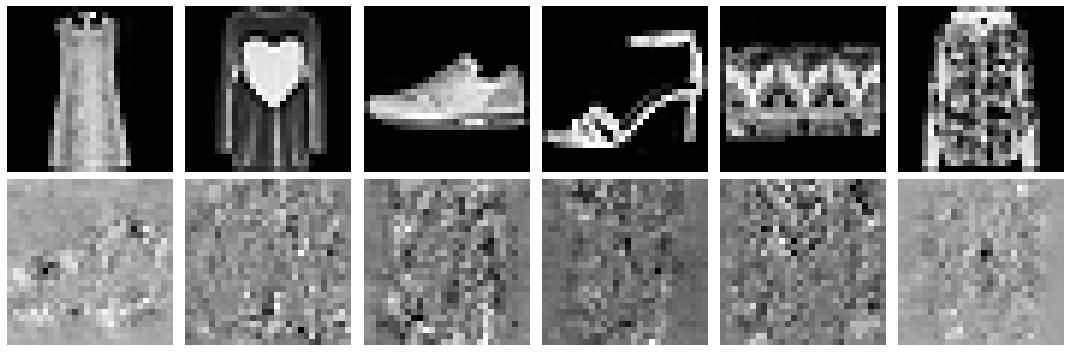

In [123]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load('netA_standard.pt')) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval(); 

for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    current_grad = attacks.gradient_wrt_data(whitebox,device,data,labels)
    
    plt.figure(figsize=(15,5))
    for jj in range(6):
        plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
    
    for jj in range(6): 
        plt.subplot(2,6,jj+7);plt.imshow(current_grad[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    break

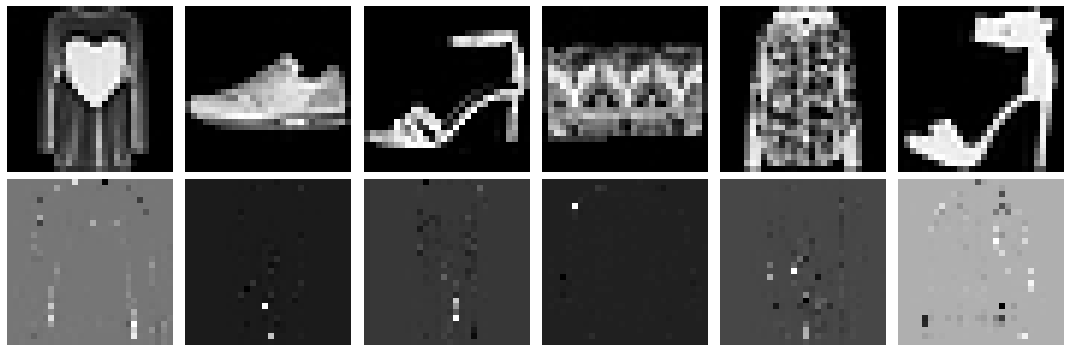

In [136]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load('netA_advtrain_pgd0p1.pt')) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval(); 

for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)
    
    current_grad = attacks.gradient_wrt_data(whitebox,device,data,labels)
    
    plt.figure(figsize=(15,5))
    for jj in range(1,7):
        plt.subplot(2,6,jj);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
    
    for jj in range(1,7): 
        plt.subplot(2,6,jj+6);plt.imshow(current_grad[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    break

Initial Accuracy of Whitebox Model:  0.8952


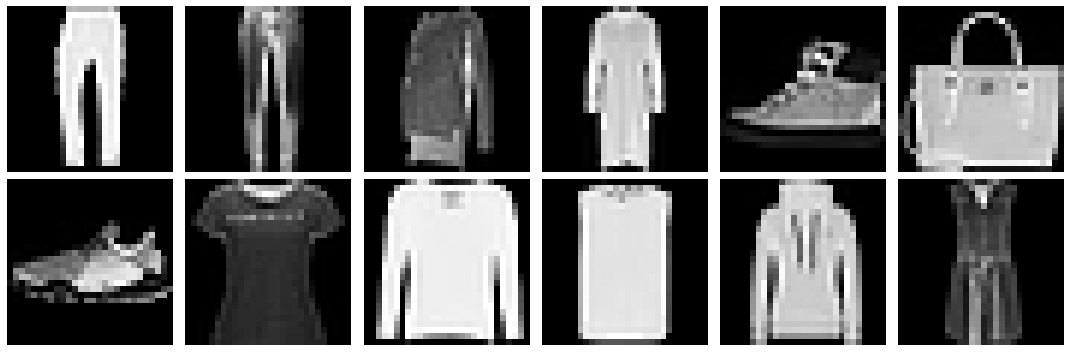

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8952
Done!
Initial Accuracy of Whitebox Model:  0.8952


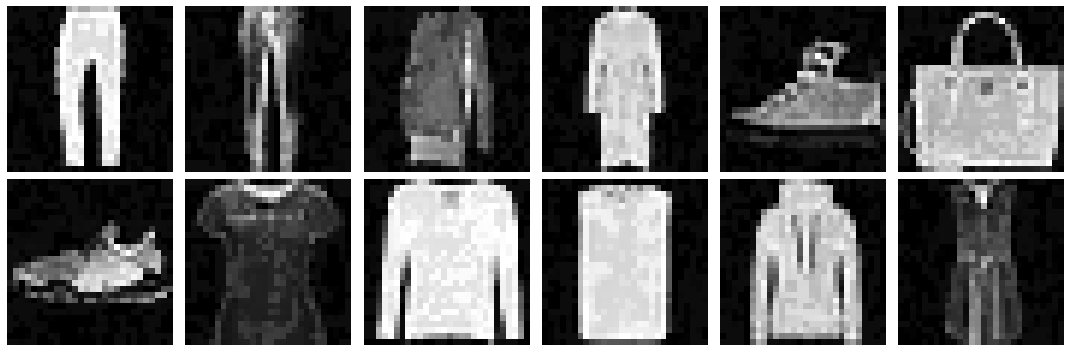

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8271
Done!
Initial Accuracy of Whitebox Model:  0.8952


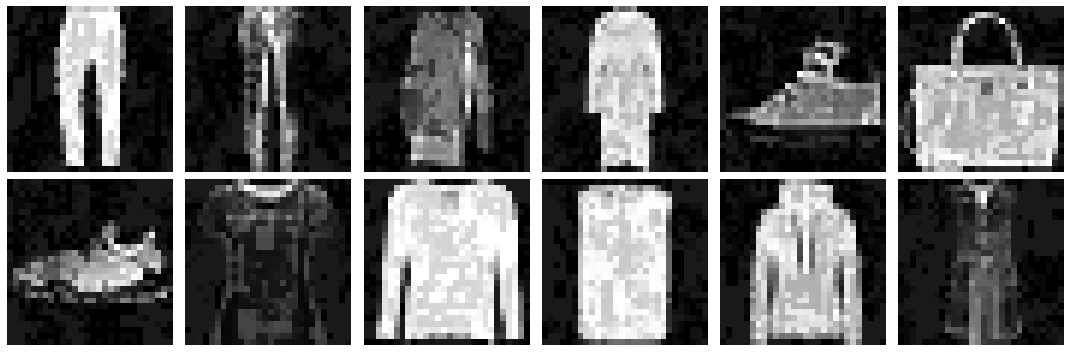

Attack Epsilon: 0.1; Whitebox Accuracy: 0.4316
Done!
Initial Accuracy of Whitebox Model:  0.8952


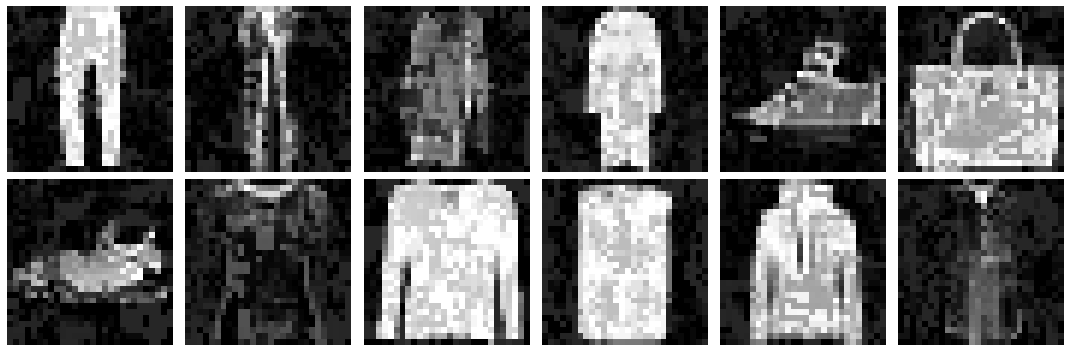

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.0901
Done!
Initial Accuracy of Whitebox Model:  0.8952


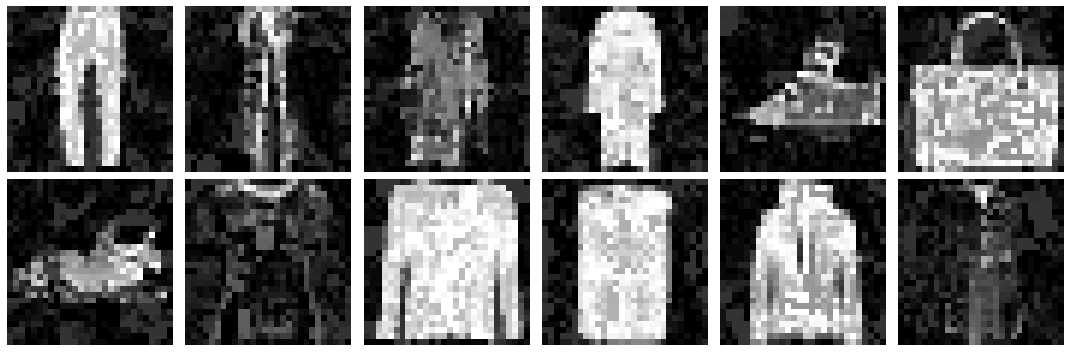

Attack Epsilon: 0.2; Whitebox Accuracy: 0.0238
Done!
Initial Accuracy of Whitebox Model:  0.8952


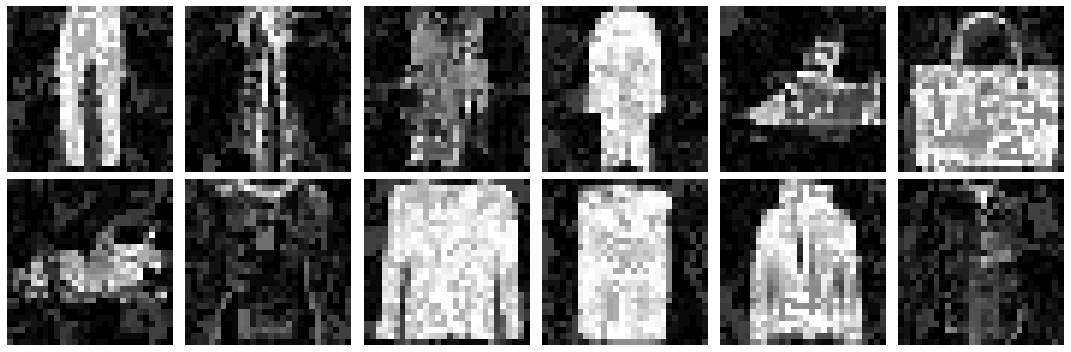

Attack Epsilon: 0.25; Whitebox Accuracy: 0.0056
Done!
Initial Accuracy of Whitebox Model:  0.8719


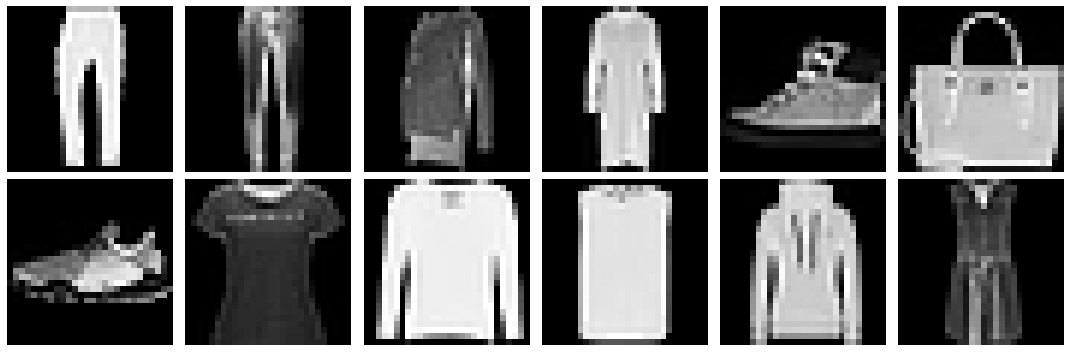

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8719
Done!
Initial Accuracy of Whitebox Model:  0.8719


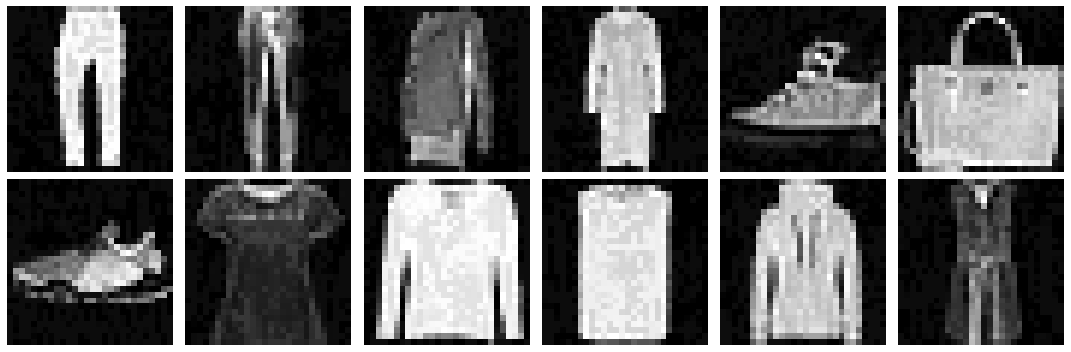

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8308
Done!
Initial Accuracy of Whitebox Model:  0.8719


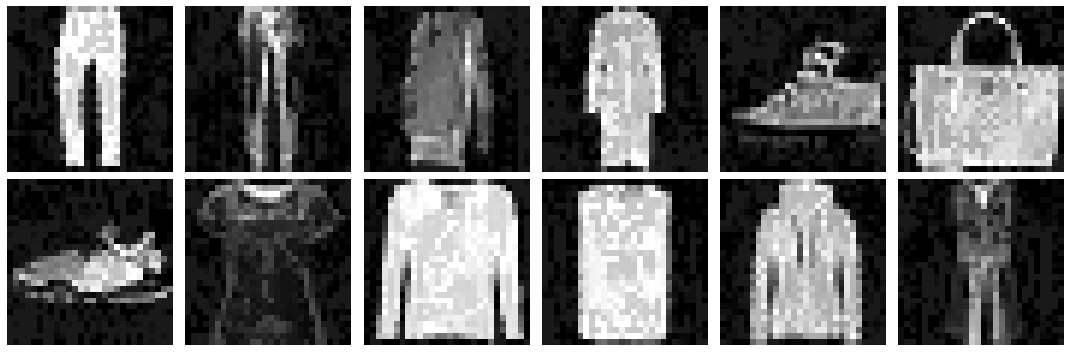

Attack Epsilon: 0.1; Whitebox Accuracy: 0.7759
Done!
Initial Accuracy of Whitebox Model:  0.8719


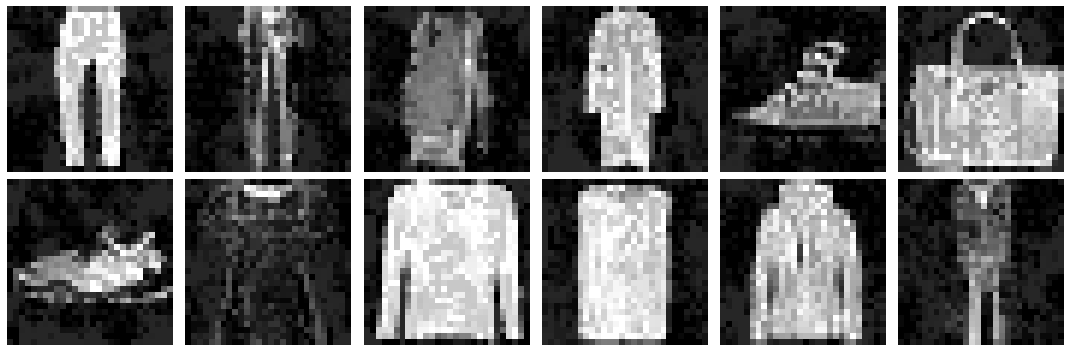

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.0723
Done!
Initial Accuracy of Whitebox Model:  0.8719


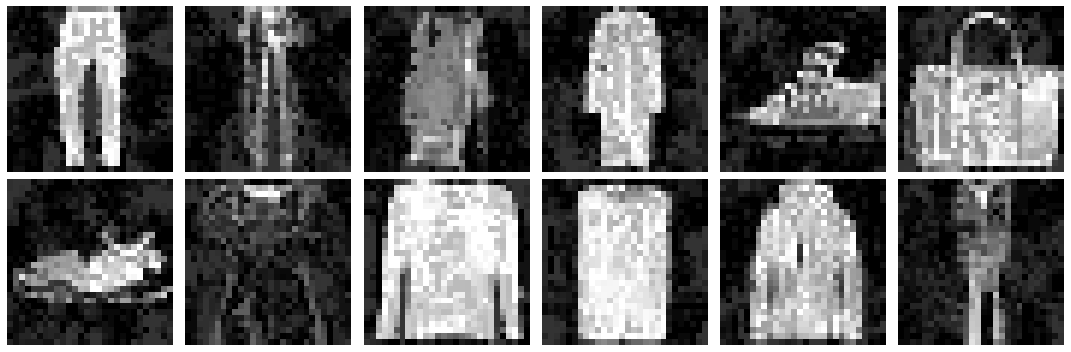

Attack Epsilon: 0.2; Whitebox Accuracy: 0.0141
Done!
Initial Accuracy of Whitebox Model:  0.8719


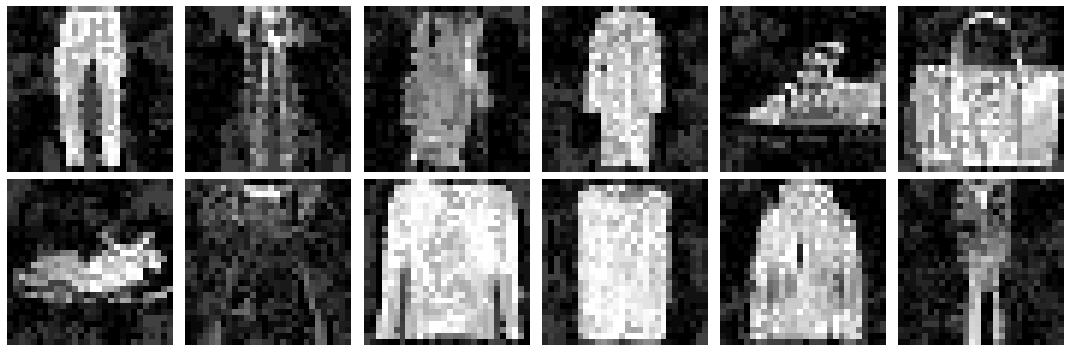

Attack Epsilon: 0.25; Whitebox Accuracy: 0.0032
Done!
Initial Accuracy of Whitebox Model:  0.8555


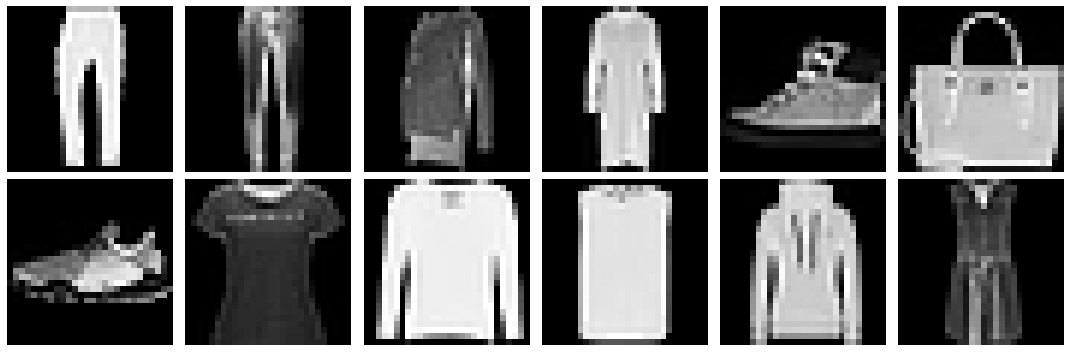

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8555
Done!
Initial Accuracy of Whitebox Model:  0.8555


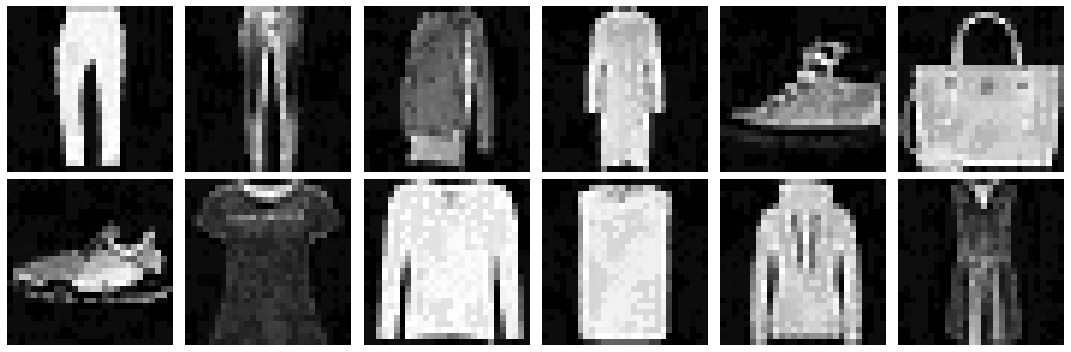

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8216
Done!
Initial Accuracy of Whitebox Model:  0.8555


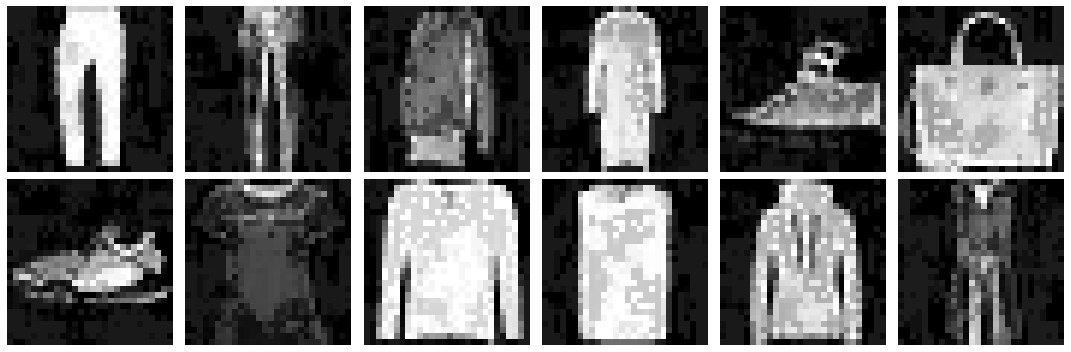

Attack Epsilon: 0.1; Whitebox Accuracy: 0.7947
Done!
Initial Accuracy of Whitebox Model:  0.8555


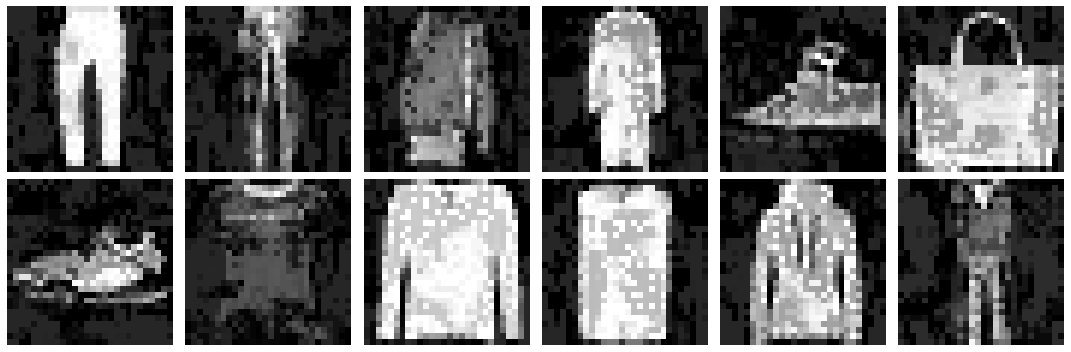

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.7598
Done!
Initial Accuracy of Whitebox Model:  0.8555


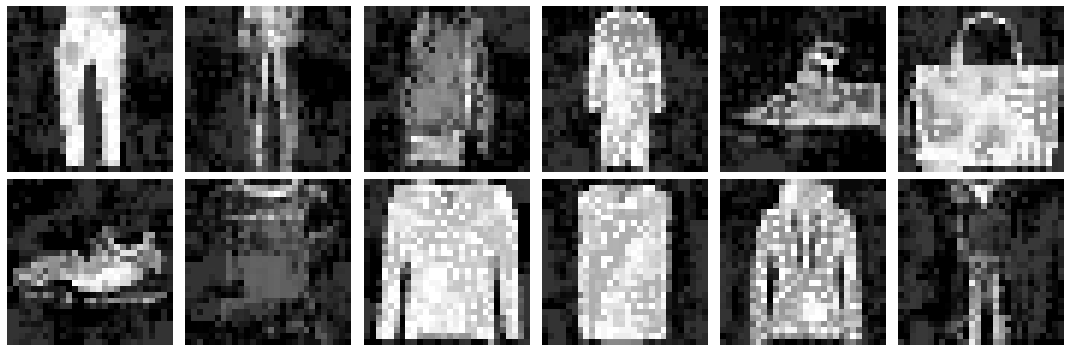

Attack Epsilon: 0.2; Whitebox Accuracy: 0.0157
Done!
Initial Accuracy of Whitebox Model:  0.8555


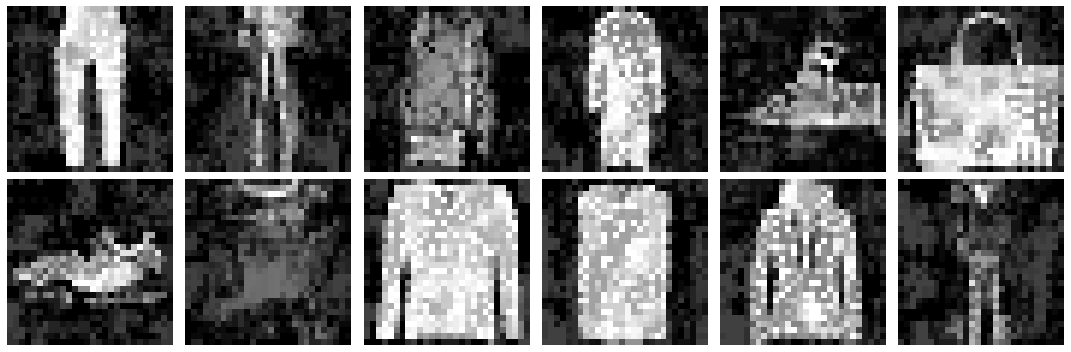

Attack Epsilon: 0.25; Whitebox Accuracy: 0.0075
Done!


NameError: name 'pgd_20_accs' is not defined

In [137]:
pgd_05_accs = get_robust_accuracies(bonus_epsilon_range, eps_05_model_name, attack_type = 'PGD')
pgd_10_accs = get_robust_accuracies(bonus_epsilon_range, 'netA_advtrain_pgd0p1.pt', attack_type = 'PGD')
pgd_15_accs = get_robust_accuracies(bonus_epsilon_range, eps_15_model_name, attack_type = 'PGD')

Initial Accuracy of Whitebox Model:  0.8374


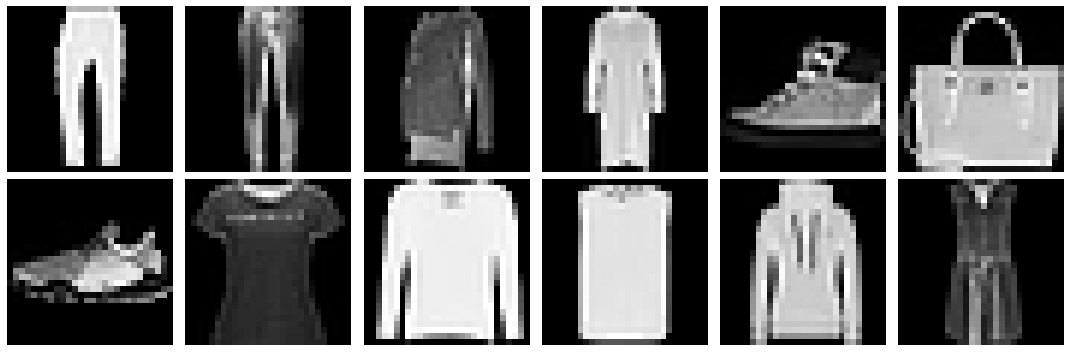

Attack Epsilon: 0.0; Whitebox Accuracy: 0.8374
Done!
Initial Accuracy of Whitebox Model:  0.8374


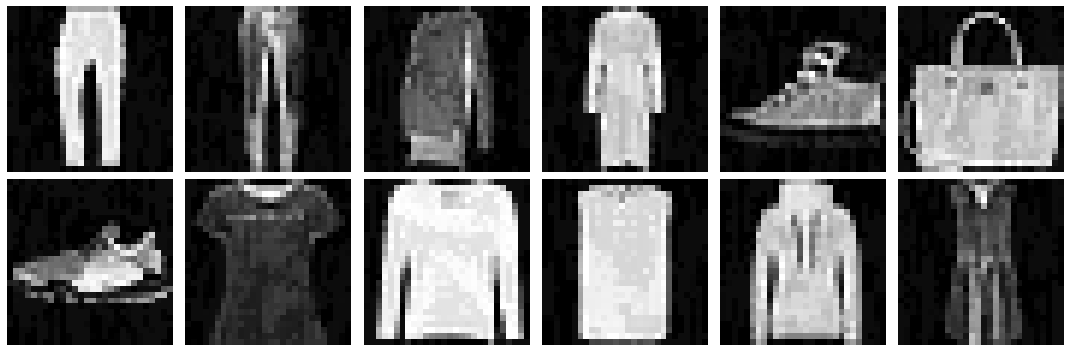

Attack Epsilon: 0.05; Whitebox Accuracy: 0.8029
Done!
Initial Accuracy of Whitebox Model:  0.8374


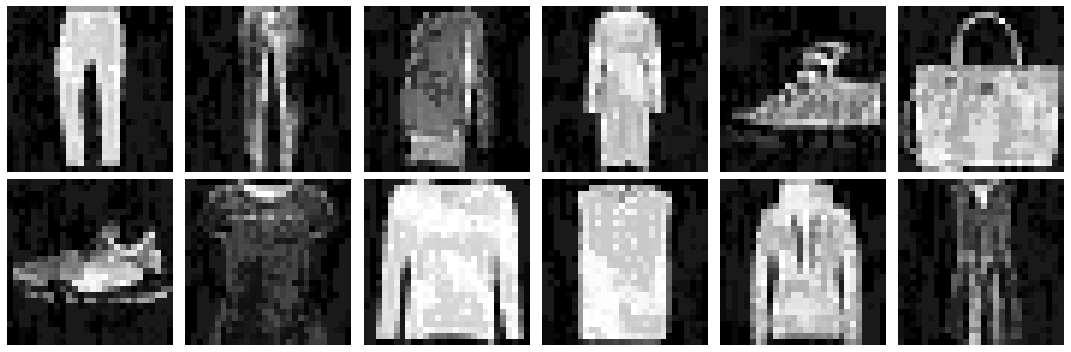

Attack Epsilon: 0.1; Whitebox Accuracy: 0.7789
Done!
Initial Accuracy of Whitebox Model:  0.8374


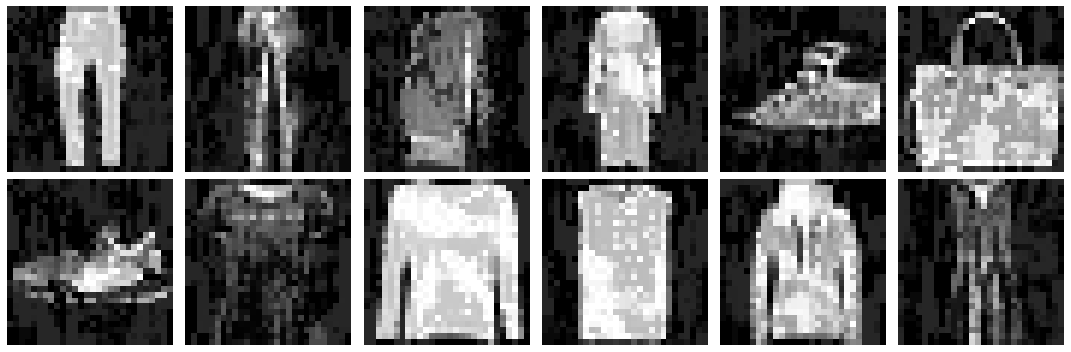

Attack Epsilon: 0.15000000000000002; Whitebox Accuracy: 0.7541
Done!
Initial Accuracy of Whitebox Model:  0.8374


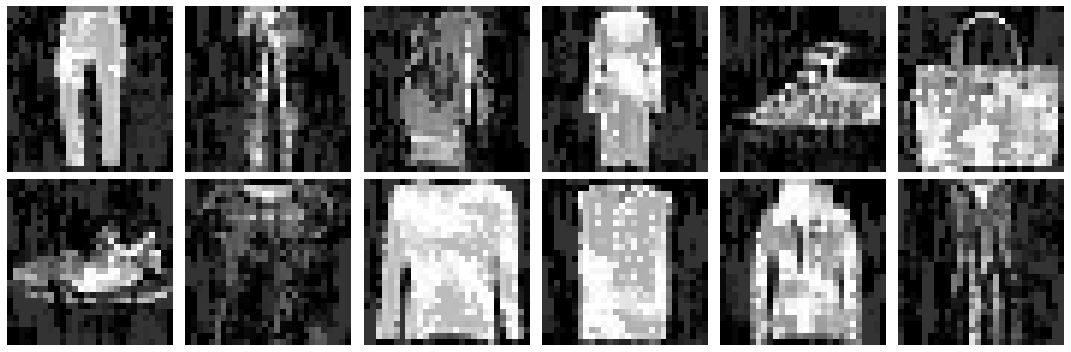

Attack Epsilon: 0.2; Whitebox Accuracy: 0.7272
Done!
Initial Accuracy of Whitebox Model:  0.8374


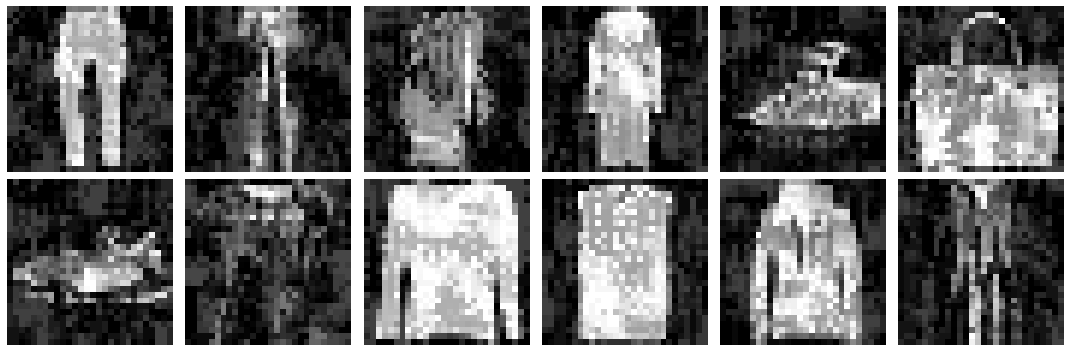

Attack Epsilon: 0.25; Whitebox Accuracy: 0.0259
Done!


In [139]:
pgd_20_accs = get_robust_accuracies(bonus_epsilon_range, eps_20_model_name, attack_type = 'PGD')

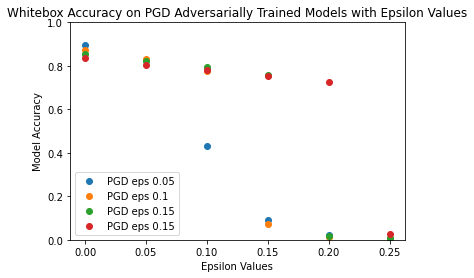

In [140]:
plt.title(f'Whitebox Accuracy on PGD Adversarially Trained Models with Epsilon Values')
plt.xlabel('Epsilon Values')
plt.ylabel('Model Accuracy')
plt.ylim(0,1)
plt.scatter(bonus_epsilon_range, pgd_05_accs, label = 'PGD eps 0.05')
plt.scatter(bonus_epsilon_range, pgd_10_accs, label = 'PGD eps 0.1')
plt.scatter(bonus_epsilon_range, pgd_15_accs, label = 'PGD eps 0.15')
plt.scatter(bonus_epsilon_range, pgd_20_accs, label = 'PGD eps 0.15')
plt.legend()